# DFS2TIF


from osgeo import gdal
import mikeio
import numpy as np

# ----------------------------- 步骤1：读取模板TIFF文件 -----------------------------
template_tif_path = r"H:\MIKE\DEM\slope.tif"  # 任选一个现有TIFF作为模板
template_ds = gdal.Open(template_tif_path)

# 获取模板地理参数
geo_transform = template_ds.GetGeoTransform()
projection = template_ds.GetProjection()
cols = template_ds.RasterXSize
rows = template_ds.RasterYSize

# ----------------------------- 步骤2：读取DFS2数据 -----------------------------
ds_dem = mikeio.read(r"H:\MIKE\SHP\modified1.dfs2")
dem_data=np.flip(ds_dem.to_numpy().squeeze(),axis=0)
dem_data[dem_data==dem_data[0,0]]=np.nan

# 验证数据维度是否匹配模板
if dem_data.shape != (rows, cols):
    raise ValueError(f"数据维度不匹配！DFS2数据形状为{dem_data.shape}，模板TIFF形状为{(rows, cols)}")

# ----------------------------- 步骤3：创建新TIFF -----------------------------
driver = gdal.GetDriverByName("GTiff")
output_path = r"H:\MIKE\DEM\output_dem.tif"

# 创建文件（继承模板参数）
ds_out = driver.Create(
    output_path,
    cols,
    rows,
    1,
    gdal.GDT_Float32  # 根据实际数据类型调整
)
ds_out.SetGeoTransform(geo_transform)
ds_out.SetProjection(projection)

# 写入数据
band = ds_out.GetRasterBand(1)
band.WriteArray(dem_data)
band.SetNoDataValue(np.nan)  # 设置空值标记
band.FlushCache()

# 释放资源
ds_out = None
template_ds = None


# train_test

In [1]:
from osgeo import gdal,osr
import glob
import os
from tqdm import *
import mikeio
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import gc
from scipy import stats
import flaml
import shap
import pickle
import seaborn as sns
from pygam import LinearGAM, s
from scipy.signal import argrelextrema
import zarr
import numcodecs


In [2]:
ds_curvature=gdal.Open(r"H:\MIKE\DEM_Features\curvature1.tif")
ds_slope=gdal.Open(r"H:\MIKE\DEM\slope.tif")
ds_aspect=gdal.Open(r"H:\MIKE\DEM\aspect.tif")
ds_density=gdal.Open(r"H:\MIKE\DEM\kernel_density.tif")
ds_twi=gdal.Open(r"H:\MIKE\DEM_Features\SAGA Topographic Wetness Index.tif")
ds_lucc=gdal.Open(r"H:\MIKE\DEM\LUCC2.tif")
ds_dem=gdal.Open(r"H:\MIKE\DEM_Features\output_dem.tif")

D:\Anaconda\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [3]:
arr_curvature=ds_curvature.ReadAsArray()
arr_slope=ds_slope.ReadAsArray()
arr_aspect=ds_aspect.ReadAsArray()
arr_density=ds_density.ReadAsArray()
arr_twi=ds_twi.ReadAsArray()
arr_lucc=ds_lucc.ReadAsArray()
arr_dem=ds_dem.ReadAsArray()

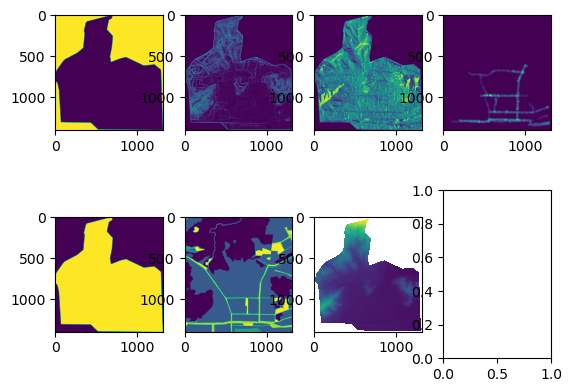

In [4]:
fig,ax=plt.subplots(2,4)
ax[0,0].imshow(arr_curvature)
ax[0,1].imshow(arr_slope)
ax[0,2].imshow(arr_aspect)
ax[0,3].imshow(arr_density)
ax[1,0].imshow(arr_twi)
ax[1,1].imshow(arr_lucc)
ax[1,2].imshow(arr_dem)
plt.show()

In [5]:
for v in [arr_curvature,arr_aspect,arr_slope,arr_dem,arr_density,arr_twi,arr_lucc]:
    print(np.nanmax(v),np.max(v),np.nanmin(v),np.min(v))

3.4e+38 3.4e+38 -551.4977 -551.4977
360.0 360.0 -1.0 -1.0
89.219734 89.219734 0.0 0.0
310.3914 nan 63.4014 nan
2973000.8 2973000.8 0.0 0.0
19.92094 19.92094 -99999.0 -99999.0
8 8 1 1


In [6]:
for v in [arr_curvature,arr_aspect,arr_slope,arr_dem,arr_density,arr_twi,arr_lucc]:
    print(v.shape)

(1398, 1315)
(1398, 1315)
(1398, 1315)
(1398, 1315)
(1398, 1315)
(1398, 1315)
(1398, 1315)


In [7]:
dem_feature=np.ones((1,arr_slope.shape[0],arr_slope.shape[1]))
for v in [arr_curvature,arr_aspect,arr_slope,arr_dem,arr_density,arr_twi,arr_lucc]:
    v=np.expand_dims(v,axis=0)
    dem_feature=np.concatenate((dem_feature,v),axis=0)

In [8]:
dem_feature=dem_feature[1:,:,:]
dem_feature.shape

(7, 1398, 1315)

In [9]:
np.nanmax(np.nanmax(dem_feature,axis=1),axis=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_91932\195100053.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.nanmax(dem_feature,axis=1),axis=1)


array([3.39999995e+38, 3.60000000e+02, 8.92197342e+01, 3.10391388e+02,
       2.97300075e+06, 1.99209404e+01, 8.00000000e+00])

In [10]:
np.nanmin(np.nanmin(dem_feature,axis=1),axis=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_91932\2583239383.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmin(np.nanmin(dem_feature,axis=1),axis=1)


array([-5.51497681e+02, -1.00000000e+00,  0.00000000e+00,  6.34014015e+01,
        0.00000000e+00, -9.99990000e+04,  1.00000000e+00])

In [11]:
dem_feature=np.nan_to_num(dem_feature)

In [12]:
nums=np.where(dem_feature==-99999)
dem_feature[nums[0],nums[1],nums[2]]=0

In [13]:
nums=np.where(dem_feature>3e+38)
dem_feature[nums[0],nums[1],nums[2]]=0

In [14]:
np.max(np.max(dem_feature,axis=1),axis=1)

array([5.69997742e+02, 3.60000000e+02, 8.92197342e+01, 3.10391388e+02,
       2.97300075e+06, 1.99209404e+01, 8.00000000e+00])

In [15]:
np.min(np.min(dem_feature,axis=1),axis=1)

array([-5.51497681e+02, -1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.00645053e-01,  1.00000000e+00])

In [16]:
test_files=[r'E:\60Min\2A60Min167MAXA01.dfs2',
 r'E:\60Min\5A60Min700MAXA01.dfs2',
 r'E:\60Min\10A60Min382MAXA01.dfs2',
r'E:\60Min\20A60Min167MAXA01.dfs2',
 r'E:\60Min\50A60Min500MAXA01.dfs2',
 r'E:\60Min\100A60Min500MAXA01.dfs2',]

In [17]:
files=[]
for f in glob.glob(r"E:\60Min\*60Min*MAX*.dfs2"):
    if f not in test_files:
        files.append(f)

In [18]:
len(files),len(test_files)

(18, 6)

In [19]:
files

['E:\\60Min\\100A60Min167MAXA01.dfs2',
 'E:\\60Min\\100A60Min382MAXA01.dfs2',
 'E:\\60Min\\100A60Min700MAXA01.dfs2',
 'E:\\60Min\\10A60Min167MAXA01.dfs2',
 'E:\\60Min\\10A60Min500MAXA01.dfs2',
 'E:\\60Min\\10A60Min700MAXA01.dfs2',
 'E:\\60Min\\20A60Min382MAXA01.dfs2',
 'E:\\60Min\\20A60Min500MAXA01.dfs2',
 'E:\\60Min\\20A60Min700MAXA01.dfs2',
 'E:\\60Min\\2A60Min382MAXA01.dfs2',
 'E:\\60Min\\2A60Min500MAXA01.dfs2',
 'E:\\60Min\\2A60Min700MAXA01.dfs2',
 'E:\\60Min\\50A60Min167MAXA01.dfs2',
 'E:\\60Min\\50A60Min382MAXA01.dfs2',
 'E:\\60Min\\50A60Min700MAXA01.dfs2',
 'E:\\60Min\\5A60Min167MAXA01.dfs2',
 'E:\\60Min\\5A60Min382MAXA01.dfs2',
 'E:\\60Min\\5A60Min500MAXA01.dfs2']

In [20]:
test_files

['E:\\60Min\\2A60Min167MAXA01.dfs2',
 'E:\\60Min\\5A60Min700MAXA01.dfs2',
 'E:\\60Min\\10A60Min382MAXA01.dfs2',
 'E:\\60Min\\20A60Min167MAXA01.dfs2',
 'E:\\60Min\\50A60Min500MAXA01.dfs2',
 'E:\\60Min\\100A60Min500MAXA01.dfs2']

In [21]:
from tqdm import *
import matplotlib.pyplot as plt
import scienceplots

In [22]:
cols=["Curvature","Aspect","Slope","Elevation","Manhole density","TWI","Land use","Rainfall"]
for i in range(len(cols),68):
    cols.append(f"Rain_{i}")
cols.append("Y")

In [23]:
df=pd.DataFrame()

for f in tqdm(files):
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    df=pd.concat([df,df1],axis=0)



100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.88it/s]


In [24]:
df=df.values.astype(np.float32)

In [25]:
import zarr
from numcodecs import Blosc # 导入 Blosc 库以进行详细配置

compressor = Blosc(cname='zstd', clevel=5, shuffle=Blosc.SHUFFLE)

chunks = (10000, None) # None 表示在该维度上不分割

z_array = zarr.open(
    'train.zarr', 
    mode='w', 
    shape=df.shape, 
    dtype=df.dtype, 
    chunks=chunks, 
    compressor=[compressor],
    #zarr_format=2  # <-- ADD THIS LINE
)

# 4. 将您的数据写入Zarr数组
z_array[:] = df

print("数据已使用 zarr.open() 和自定义压缩保存到 'my_advanced_data.zarr'")



数据已使用 zarr.open() 和自定义压缩保存到 'my_advanced_data.zarr'


In [26]:
del df
gc.collect()

0

In [27]:
df_test=pd.DataFrame()

for f in tqdm(test_files):
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    df_test=pd.concat([df_test,df1],axis=0)



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.78it/s]


In [28]:
df_test = df_test.values.astype(np.float32)

In [29]:
z_array = zarr.open(
    'test.zarr', 
    mode='w', 
    shape=df_test.shape, 
    dtype=df_test.dtype, 
    chunks=chunks, 
    compressor=compressor,
    zarr_format=2  # <-- ADD THIS LINE
)

# 4. 将您的数据写入Zarr数组
z_array[:] = df_test



In [28]:
df.shape,df_test.shape

NameError: name 'df' is not defined

In [26]:
df_test.max()[:7],df_test.min()[:7]

(Curvature          8.249936e+01
 Aspect             3.599999e+02
 Slope              8.921973e+01
 Elevation          9.711140e+01
 Manhole density    2.973001e+06
 TWI                1.992094e+01
 Land use           8.000000e+00
 dtype: float64,
 Curvature         -210.499298
 Aspect              -1.000000
 Slope                0.000000
 Elevation           67.371399
 Manhole density      0.000000
 TWI                  2.223469
 Land use             1.000000
 dtype: float64)

In [27]:
df.max()[:7],df.min()[:7]

(Curvature          8.249936e+01
 Aspect             3.599999e+02
 Slope              8.921973e+01
 Elevation          9.711140e+01
 Manhole density    2.973001e+06
 TWI                1.992094e+01
 Land use           8.000000e+00
 dtype: float64,
 Curvature         -210.499298
 Aspect              -1.000000
 Slope                0.000000
 Elevation           67.371399
 Manhole density      0.000000
 TWI                  2.223469
 Land use             1.000000
 dtype: float64)

In [28]:
from sklearn.utils import shuffle
df = shuffle(df)

In [29]:
import xgboost
import joblib
import pickle

In [30]:
df

Curvature      Aspect     Slope  Elevation  Manhole density  \
111304   0.000191  104.034958  0.295269  75.851402            0.000   
48054    2.999675   85.603355  0.466854  84.011398            0.000   
197583  -1.499933   16.557365  1.381992  79.981400      1196573.125   
156835   2.000419  149.034958  1.669997  74.961403       693095.750   
28757   -1.750367  109.884918  1.789193  87.371399            0.000   
...           ...         ...       ...        ...              ...   
91427    0.000381  347.008820  0.477734  75.821404            0.000   
80491   -0.500296  241.700851  1.057323  78.611397       212519.250   
94120    0.750157  167.905670  2.049985  77.381401      1382193.875   
94151    1.250071  330.523346  0.945956  76.311401            0.000   
137724  -1.250262  181.849426  1.110534  77.731400       462316.000   

              TWI  Land use  Rainfall  Rain_8  Rain_9  ...  Rain_59  Rain_60  \
111304  16.003128       3.0    0.6205  0.6323  0.6447  ...   0.9821   0.9124   
48054   14.722931       3.0    0.6906  0.7038  0.7176  ...   1.0931   1.0156   
197583  14.643458       7.0    0.6906  0.7038  0.7176  ...   1.0931   1.0156   
156835  12.823435       7.0    0.4576  0.4700  0.4831  ...   0.5838   0.5639   
28757   13.042747       3.0    0.5277  0.5378  0.5484  ...   0.8354   0.7761   
...           ...       ...       ...     ...     ...  ...      ...      ...   
91427   15.508139       3.0    0.4576  0.4664  0.4755  ...   0.7244   0.6730   
80491   14.207316       3.0    0.2948  0.3004  0.3063  ...   0.4666   0.4335   
94120   14.350019       8.0    0.3875  0.3980  0.4091  ...   0.4944   0.4774   
94151   16.761887       3.0    0.5277  0.5466  0.5670  ...   0.6388   0.6221   
137724  13.426879       8.0    0.6205  0.6739  0.7391  ...   0.7116   0.6986   

        Rain_61  Rain_62  Rain_63  Rain_64  Rain_65  Rain_66  Rain_67  \
111304   0.8528   0.8011   0.7559   0.7161   0.6807   0.6490   0.6205   
48054    0.9492   0.8916   0.8414   0.7970   0.7576   0.7223   0.6906   
197583   0.9492   0.8916   0.8414   0.7970   0.7576   0.7223   0.6906   
156835   0.5453   0.5281   0.5121   0.4971   0.4831   0.4700   0.4576   
28757    0.7253   0.6814   0.6430   0.6091   0.5790   0.5520   0.5277   
...         ...      ...      ...      ...      ...      ...      ...   
91427    0.6290   0.5909   0.5575   0.5281   0.5020   0.4787   0.4576   
80491    0.4052   0.3806   0.3591   0.3402   0.3234   0.3083   0.2948   
94120    0.4618   0.4472   0.4336   0.4210   0.4091   0.3980   0.3875   
94151    0.6063   0.5914   0.5773   0.5639   0.5513   0.5392   0.5277   
137724   0.6861   0.6741   0.6625   0.6514   0.6407   0.6304   0.6205   

               Y  
111304  0.019974  
48054   0.072201  
197583  0.338462  
156835  0.012975  
28757   0.070343  
...          ...  
91427   0.084534  
80491   0.152331  
94120   0.039596  
94151   0.113879  
137724  0.017041  

[2982696 rows x 69 columns]

In [31]:
file=r"H:\EXP2\AutoML\FLAML\ML\xgboost_gpu.pkl"
with open(file,'rb') as f:
        model=pickle.load(f)


D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [32]:
params=model.model.estimator.get_xgb_params()

In [33]:

model.model.estimator

XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.7062505566469163, colsample_bynode=None,
             colsample_bytree=0.8545232466874602, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.18356222762478946,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=812,
             min_child_weight=8.523586028158489, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=22034,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [34]:
sklearn_params = {
    'learning_rate': 0.18356222762478946,
    'max_leaves': 812,
    'max_depth': 0,          # 当使用lossguide策略时实际会被忽略
    'grow_policy': 'lossguide',
    "n_estimators":22034,
    'reg_alpha': 0.08220989842569502,
    'reg_lambda': 0.046287584257566475,
    'subsample': 1.0,
    'colsample_bytree': 0.8545232466874602,
    'colsample_bylevel': 0.7062505566469163,
    'min_child_weight': 8.523586028158489,
    'n_jobs': -1,
    'tree_method': 'hist',
    'verbosity': 1,
    # 需要特别处理的参数
    'booster': 'gbtree',     # 原生接口None默认使用gbtree
    'gamma': 0.0 }           # 原生接口None等价于0.0

model = xgboost.XGBRegressor(**sklearn_params,random_state=1234,device="gpu")


In [35]:
model.fit(df.iloc[:,:-1],
    df.iloc[:,-1],verbose=True)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7062505566469163, colsample_bynode=None,
             colsample_bytree=0.8545232466874602, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.18356222762478946,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=812,
             min_child_weight=8.523586028158489, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=22034,
             n_jobs=-1, num_parallel_tree=None, random_state=1234, ...)

In [37]:
from sklearn.metrics import r2_score as r2
pred=model.predict(df_test.iloc[:,:-1])
print(r2(df_test.iloc[:,-1],pred))

0.9608583182771372


In [38]:
model.feature_importances_

array([0.01494322, 0.01312305, 0.02133189, 0.09618383, 0.03807532,
       0.04487955, 0.08571403, 0.01009995, 0.0554399 , 0.01688626,
       0.05060859, 0.01797917, 0.02668508, 0.04801504, 0.03492046,
       0.02380032, 0.02227456, 0.02461706, 0.02628054, 0.00129193,
       0.03697879, 0.00420315, 0.00439904, 0.0041593 , 0.0064019 ,
       0.02955571, 0.0195359 , 0.00923175, 0.00080164, 0.00089674,
       0.00089113, 0.00044703, 0.00050295, 0.0004741 , 0.00080732,
       0.00077461, 0.00054416, 0.00043147, 0.00051361, 0.0006488 ,
       0.00072967, 0.00171572, 0.00330306, 0.00712948, 0.00256921,
       0.00431365, 0.00355816, 0.00240125, 0.00119811, 0.00075762,
       0.0009274 , 0.00094024, 0.00200537, 0.00233856, 0.00503365,
       0.02152476, 0.00629545, 0.003112  , 0.00187099, 0.00547951,
       0.02706217, 0.00308796, 0.03451389, 0.00923781, 0.01571225,
       0.00329502, 0.03331872, 0.00121952], dtype=float32)

In [39]:
df.columns[:8]

Index(['Curvature', 'Aspect', 'Slope', 'Elevation', 'Manhole density', 'TWI',
       'Land use', 'Rainfall'],
      dtype='object')

In [40]:
importance=[]
test=model.feature_importances_
for i,v in enumerate(test):
    if i<7:
        importance.append(v)

importance.append(np.sum(test[8:]))
importance=importance/np.sum(importance)

In [41]:
df.columns[:8]

Index(['Curvature', 'Aspect', 'Slope', 'Elevation', 'Manhole density', 'TWI',
       'Land use', 'Rainfall'],
      dtype='object')

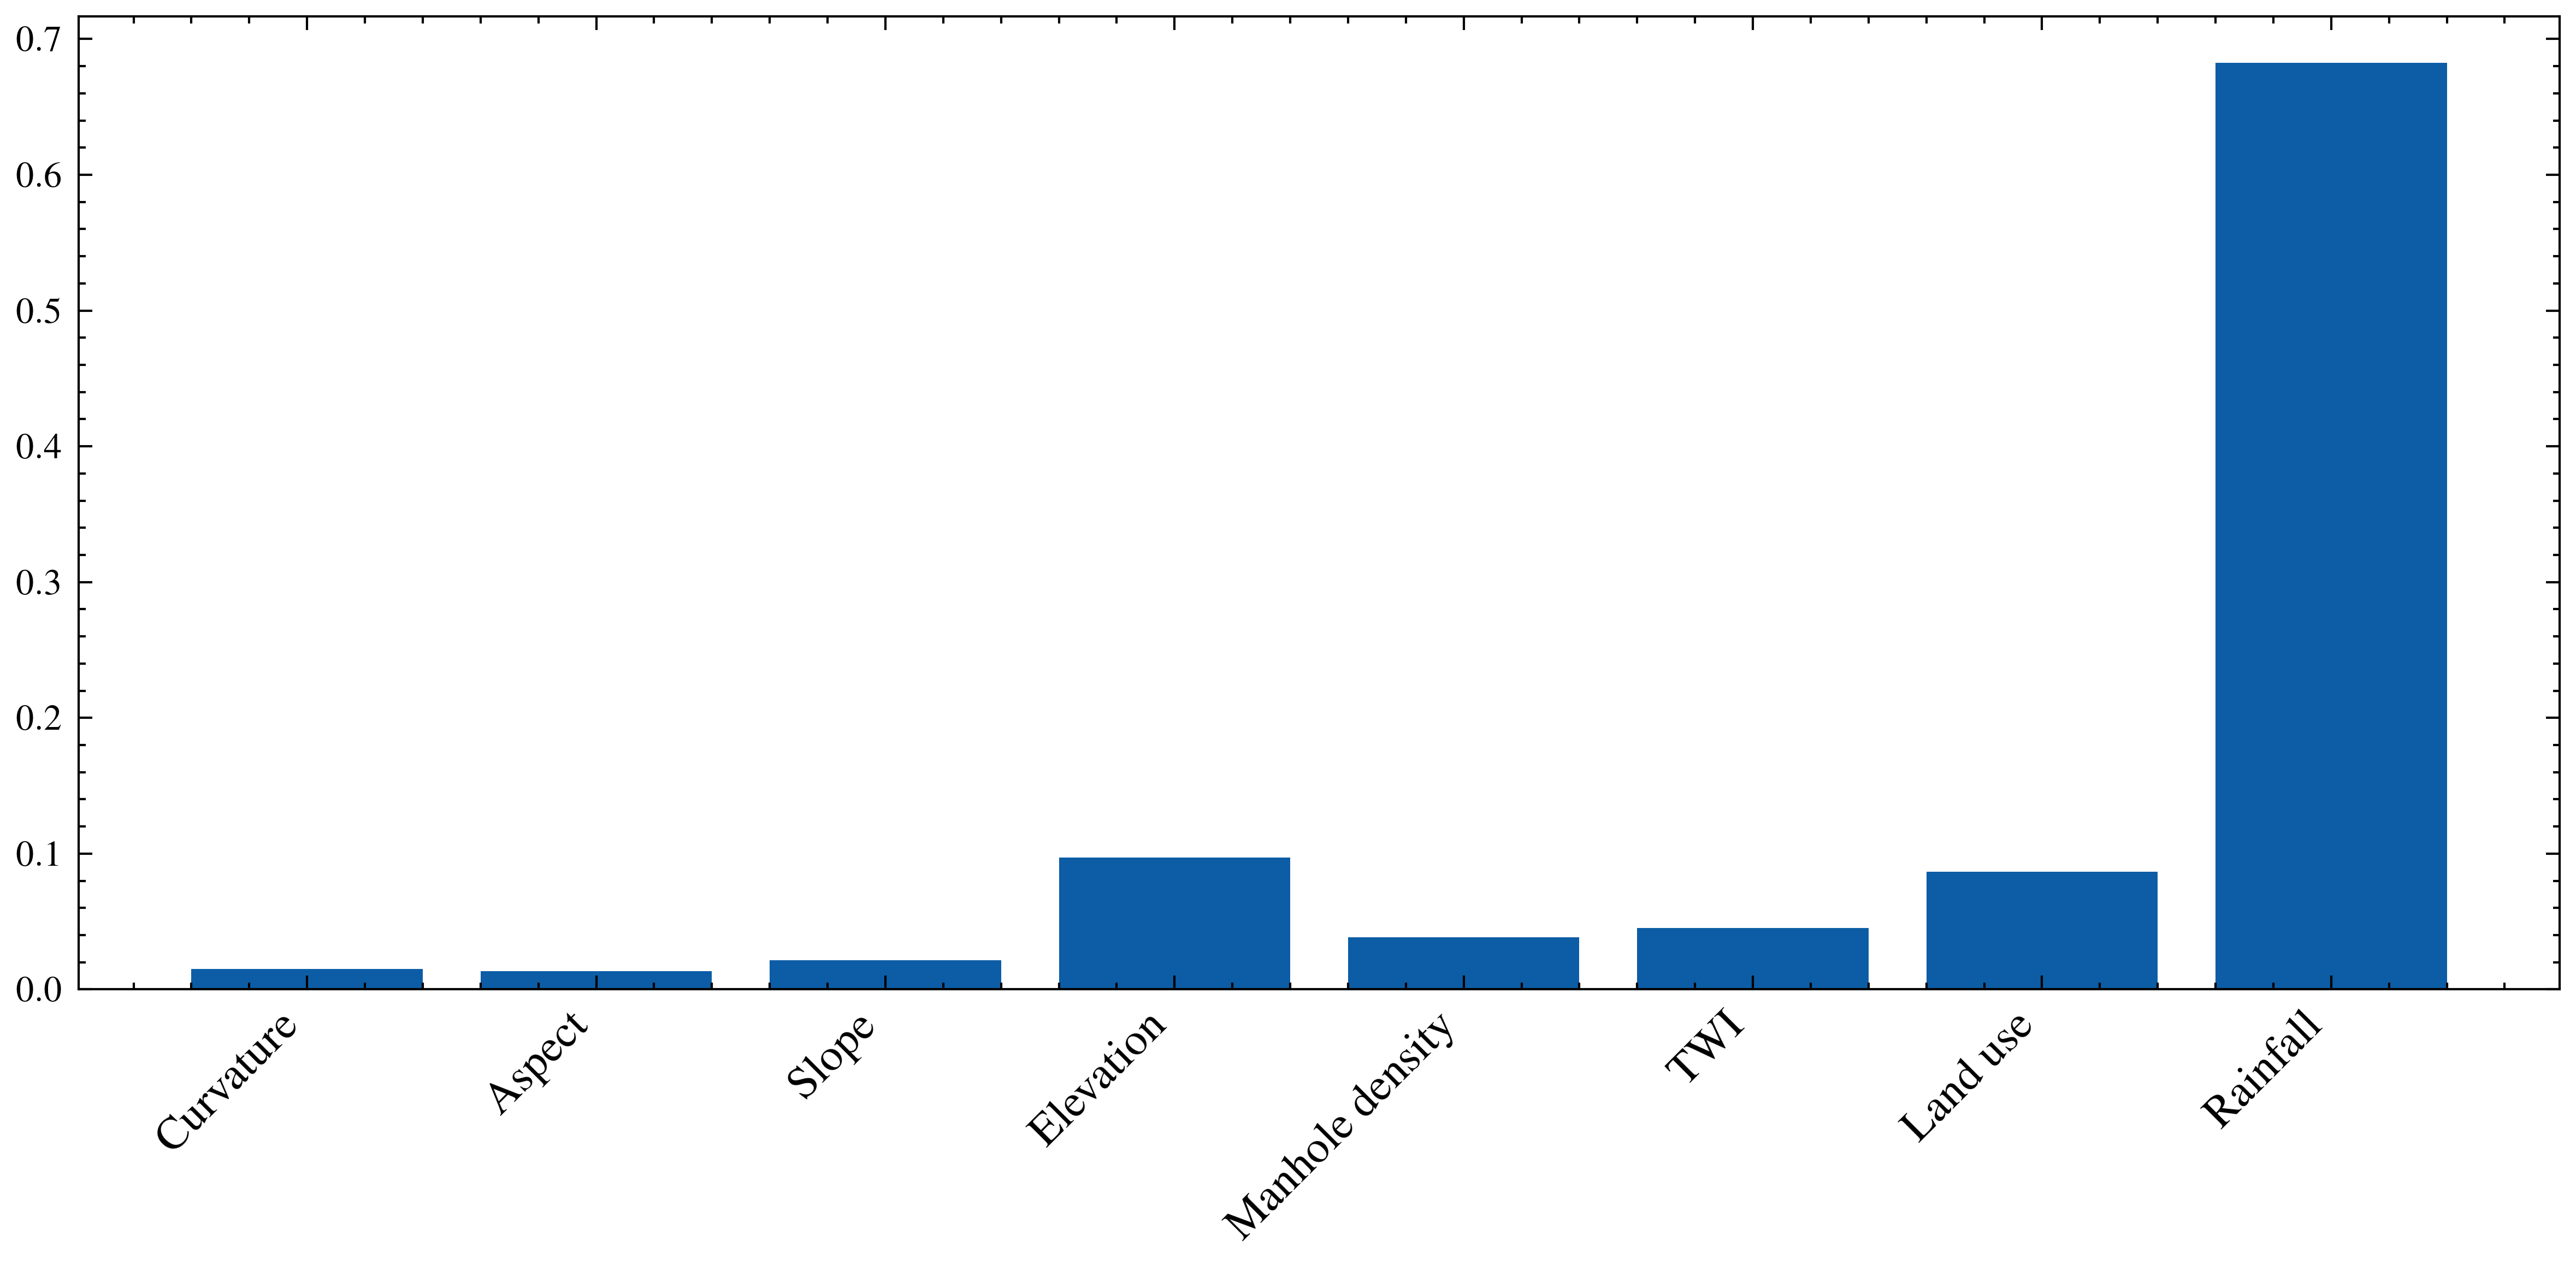

In [42]:


# 假设 importance 和 df 已定义
with plt.style.context(['ieee', "science"]):
    fig, ax = plt.subplots(figsize=(8, 4))  # 建议调整画布宽度
    
    # 绘制条形图
    bars = ax.bar(range(len(importance)), importance)
    
    # 设置x轴标签
    ax.set_xticks(range(len(importance)))  # 设置刻度位置
    ax.set_xticklabels(df.columns[:8].tolist(),  # 设置标签文本
                      rotation=45,              # 适当旋转防止重叠
                      ha='right',              # 对齐方式
                      fontsize=10)             # 字体大小
    
    # 自动调整布局
    plt.tight_layout()
    plt.show()


In [44]:
import joblib
joblib.dump(model,r"H:\EXP2\RETRAIN\xgb.pkl")

['H:\\EXP2\\RETRAIN\\xgb.pkl']

In [45]:
model.save_model(r'H:\EXP2\RETRAIN\xgbr_model.model')  # 二进制格式，兼容性好

D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [31]:
import joblib
model=joblib.load(r"H:\EXP2\RETRAIN\xgb.pkl")
model


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7062505566469163, colsample_bynode=None,
             colsample_bytree=0.8545232466874602, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.18356222762478946,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=812,
             min_child_weight=8.523586028158489, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=22034,
             n_jobs=-1, num_parallel_tree=None, random_state=1234, ...)

In [32]:
import shap

In [33]:
from sklearn.metrics import r2_score as r2

In [34]:
explainer=shap.TreeExplainer(model)

In [35]:
import scienceplots

In [36]:
features=[["Elevation"],["Manhole density"],["Land use"], ["Curvature"],["Aspect"],["Slope"],["TWI"],]

In [37]:
test_files[::-1]

['E:\\60Min\\100A60Min500MAXA01.dfs2',
 'E:\\60Min\\50A60Min500MAXA01.dfs2',
 'E:\\60Min\\20A60Min167MAXA01.dfs2',
 'E:\\60Min\\10A60Min382MAXA01.dfs2',
 'E:\\60Min\\5A60Min700MAXA01.dfs2',
 'E:\\60Min\\2A60Min167MAXA01.dfs2']

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

E:\60Min\100A60Min500MAXA01.dfs2
0.9664196011004981


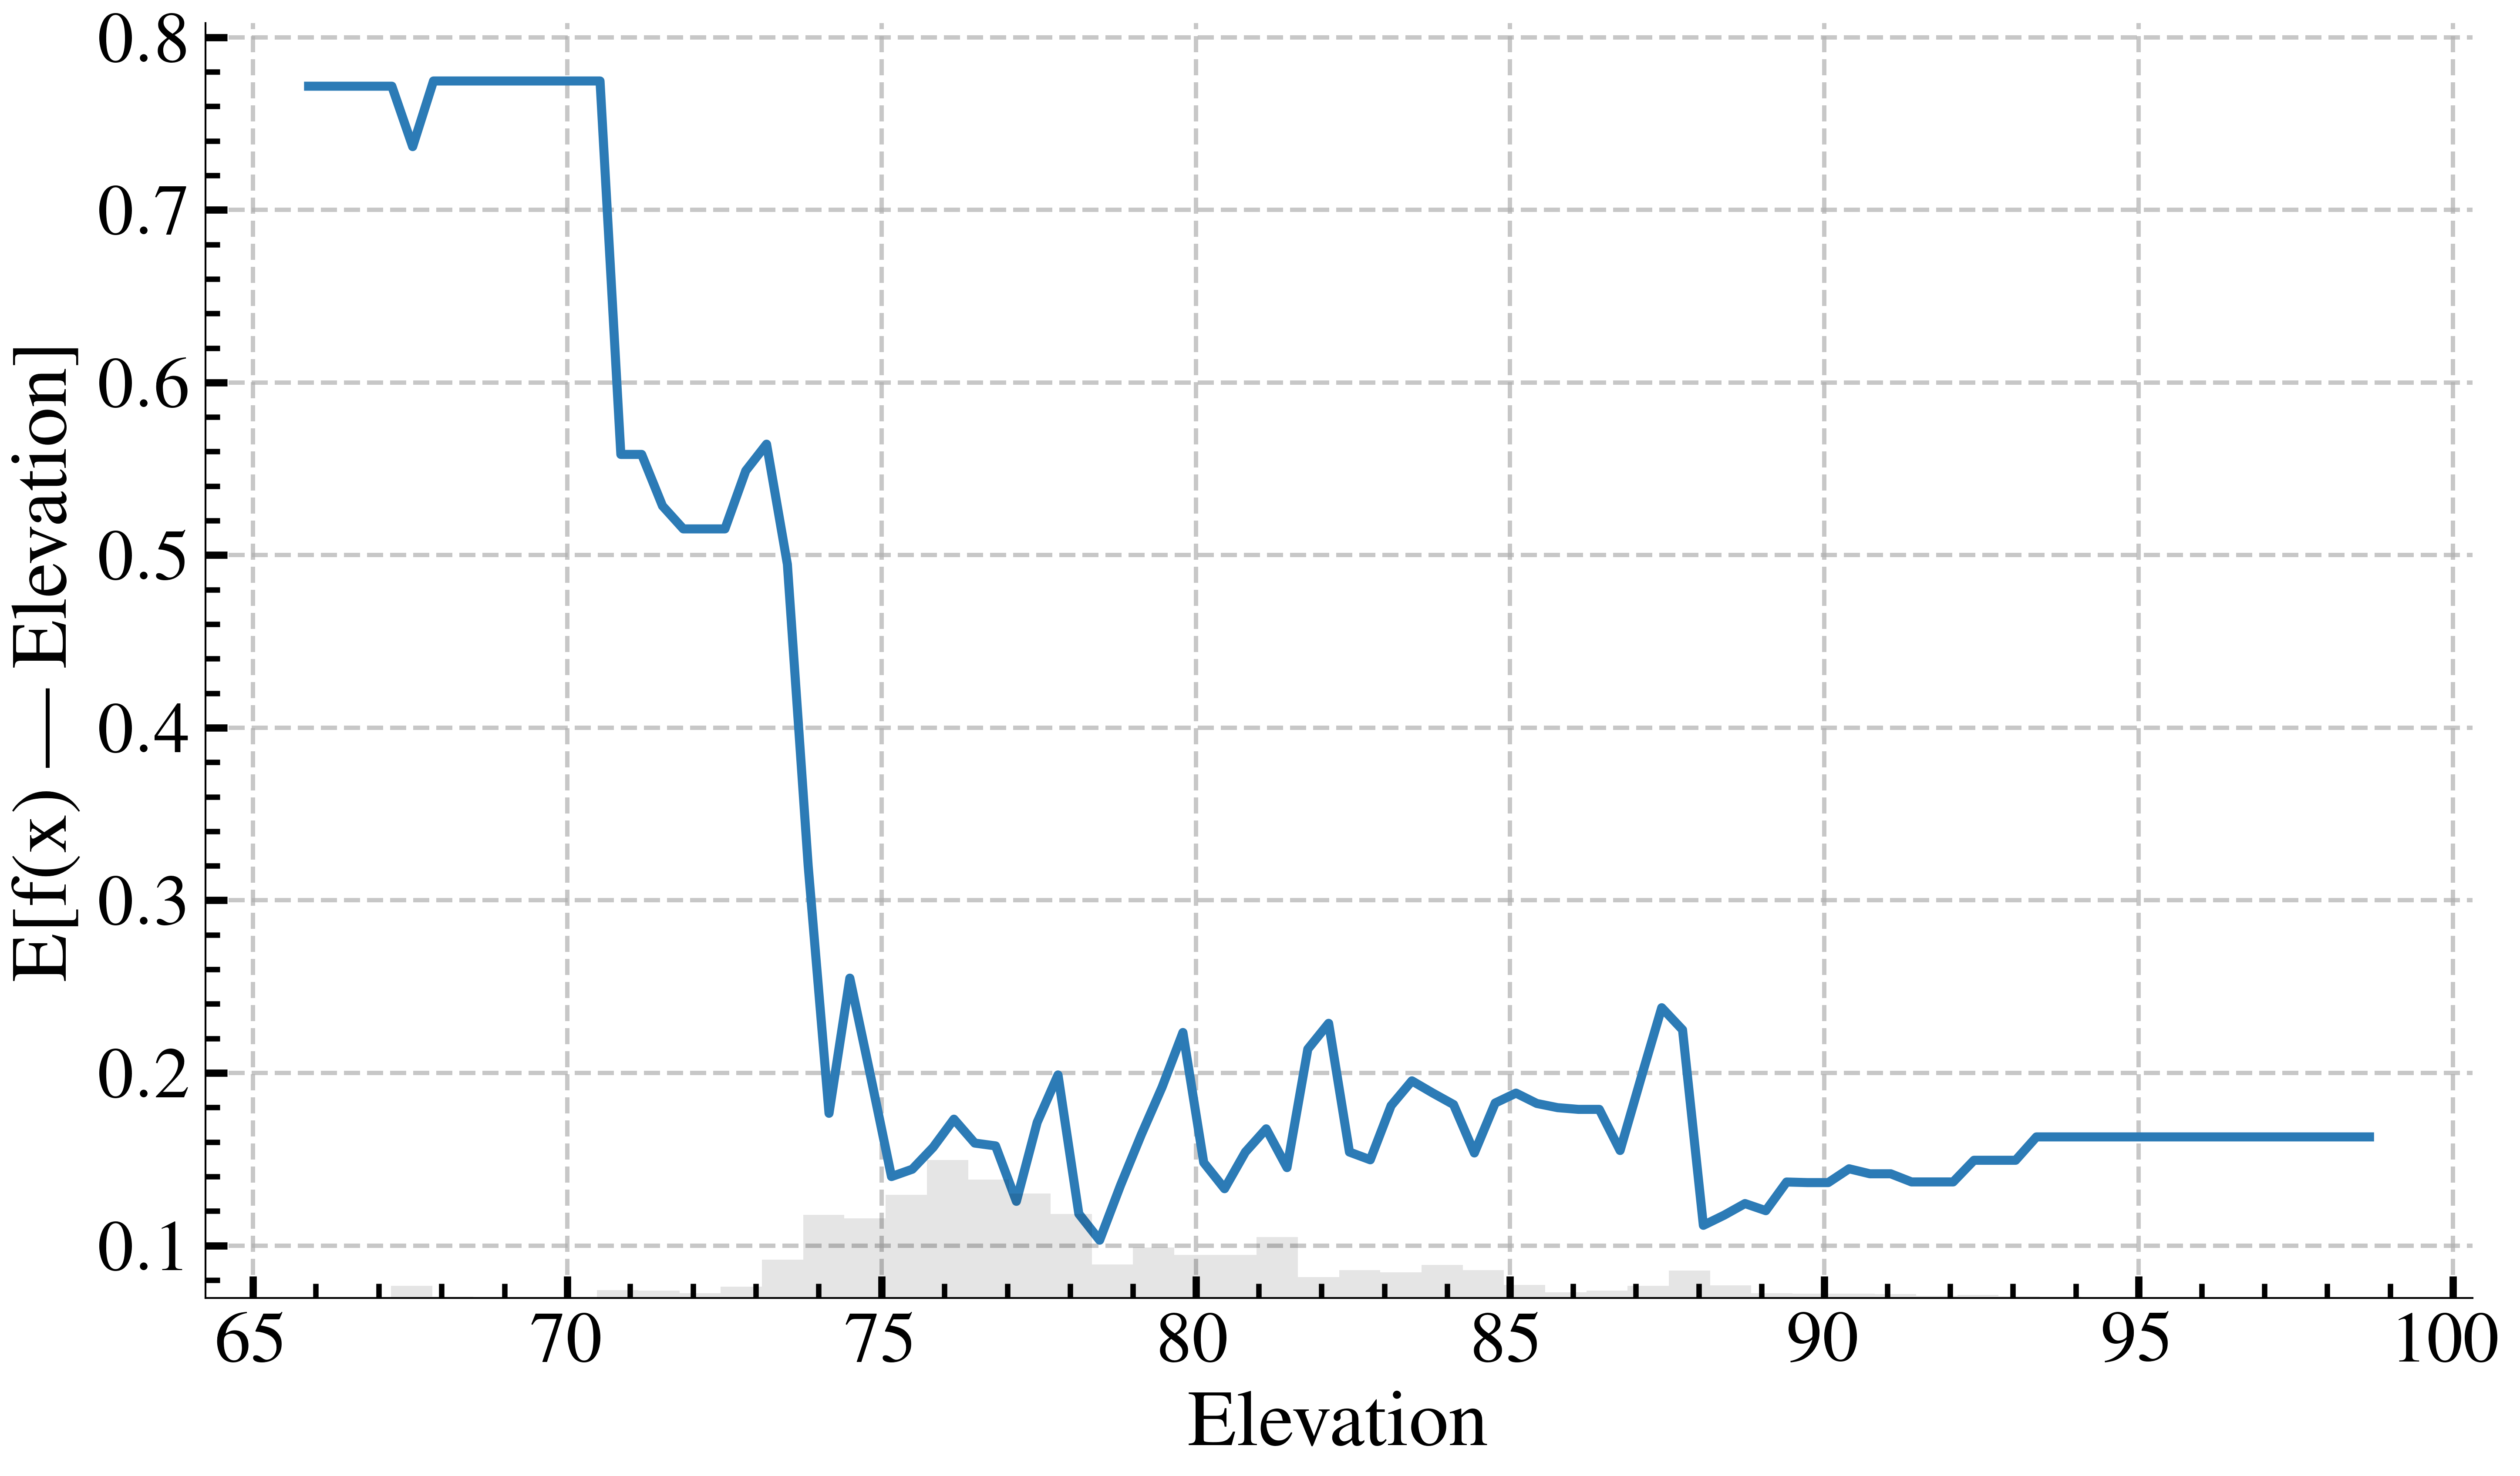

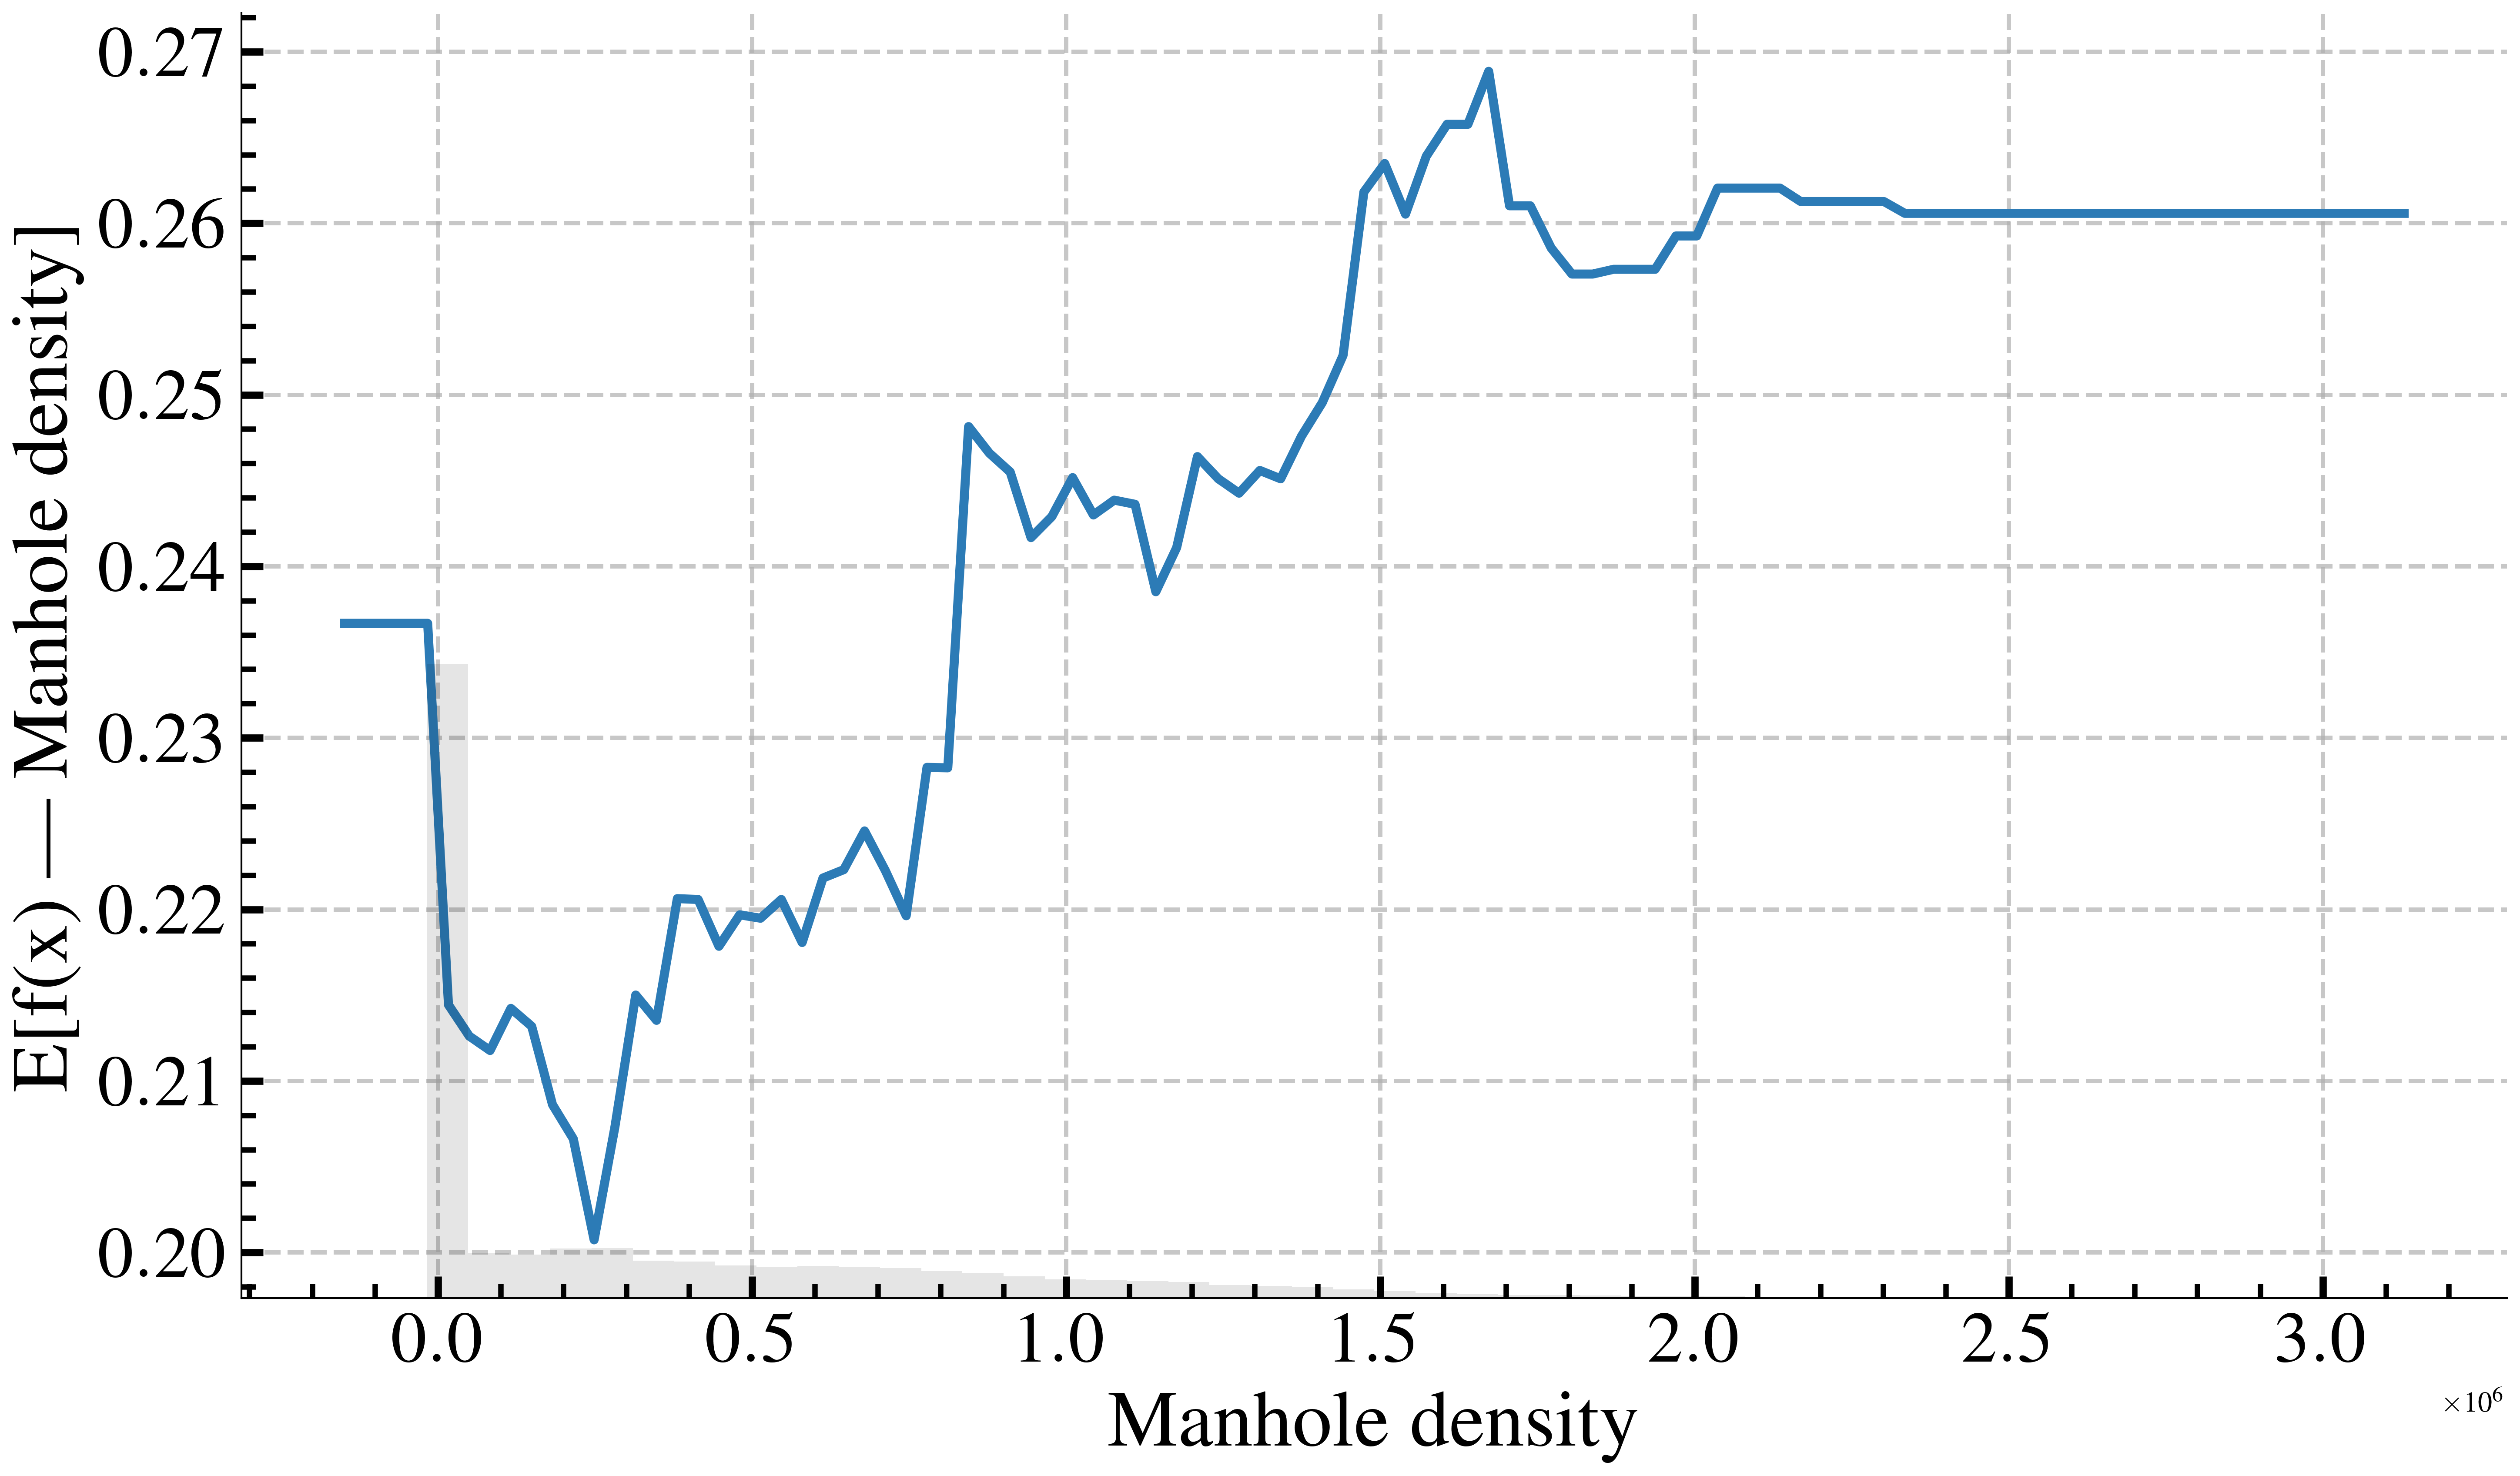

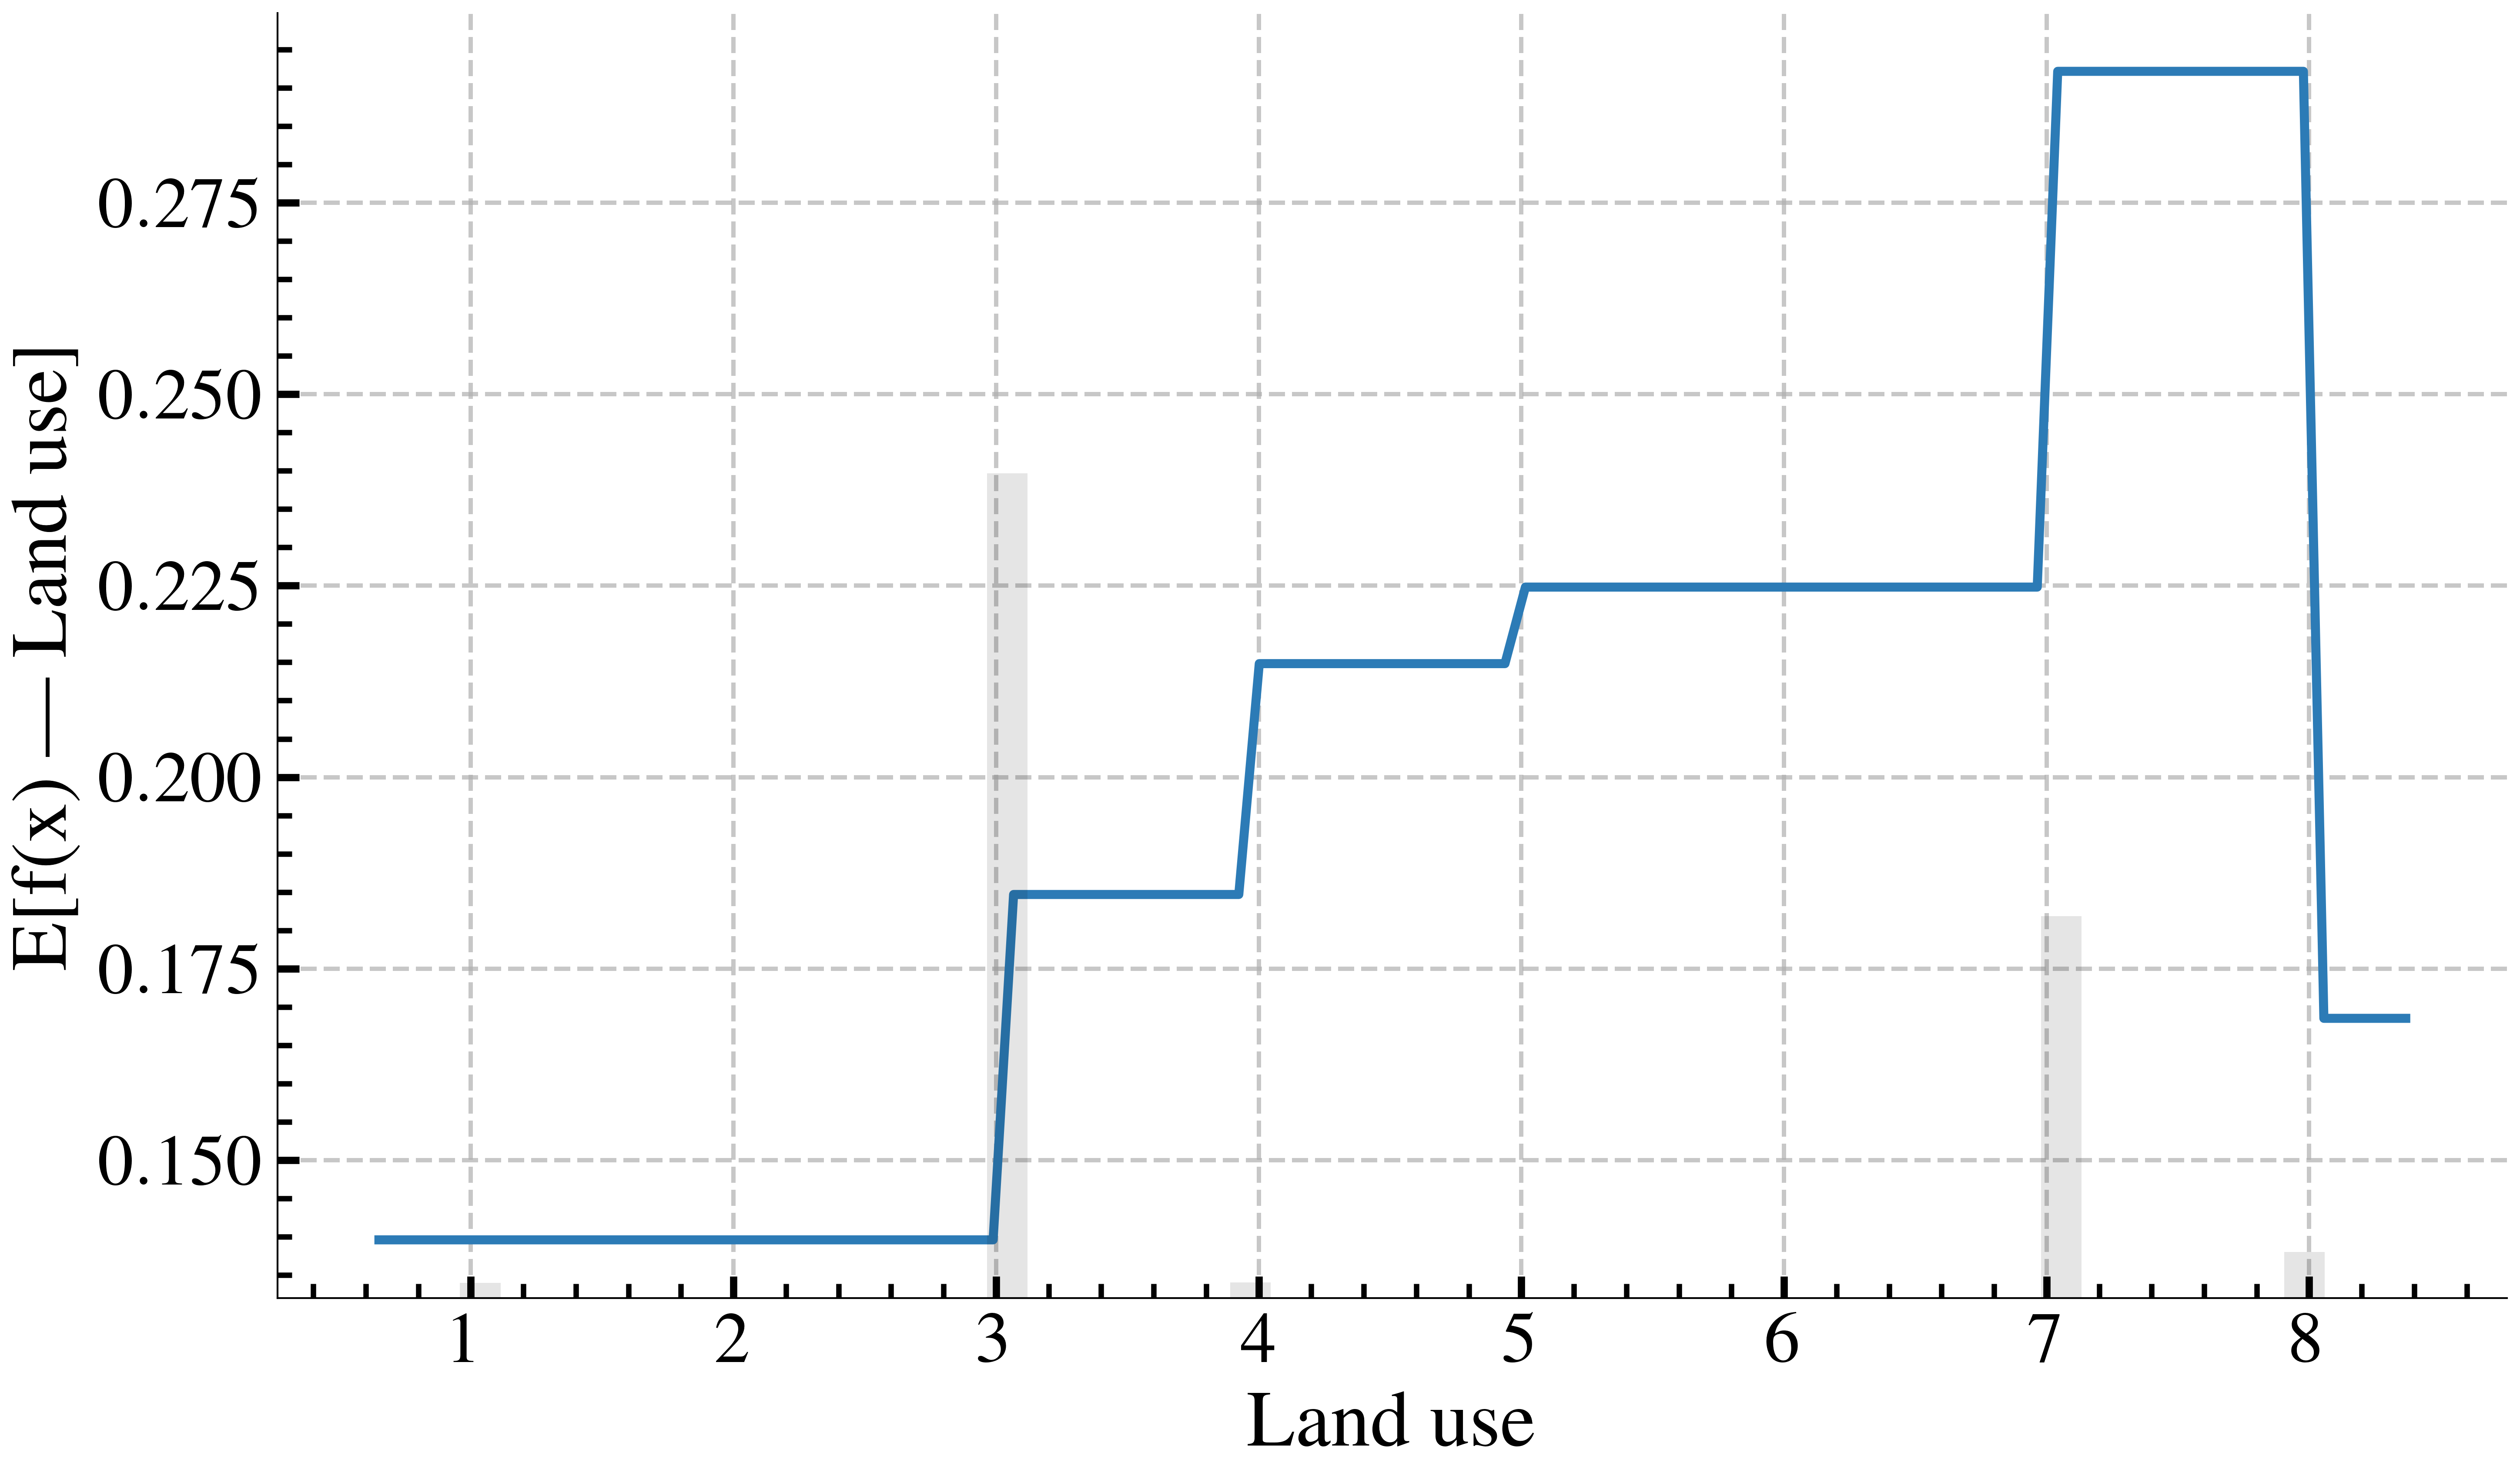

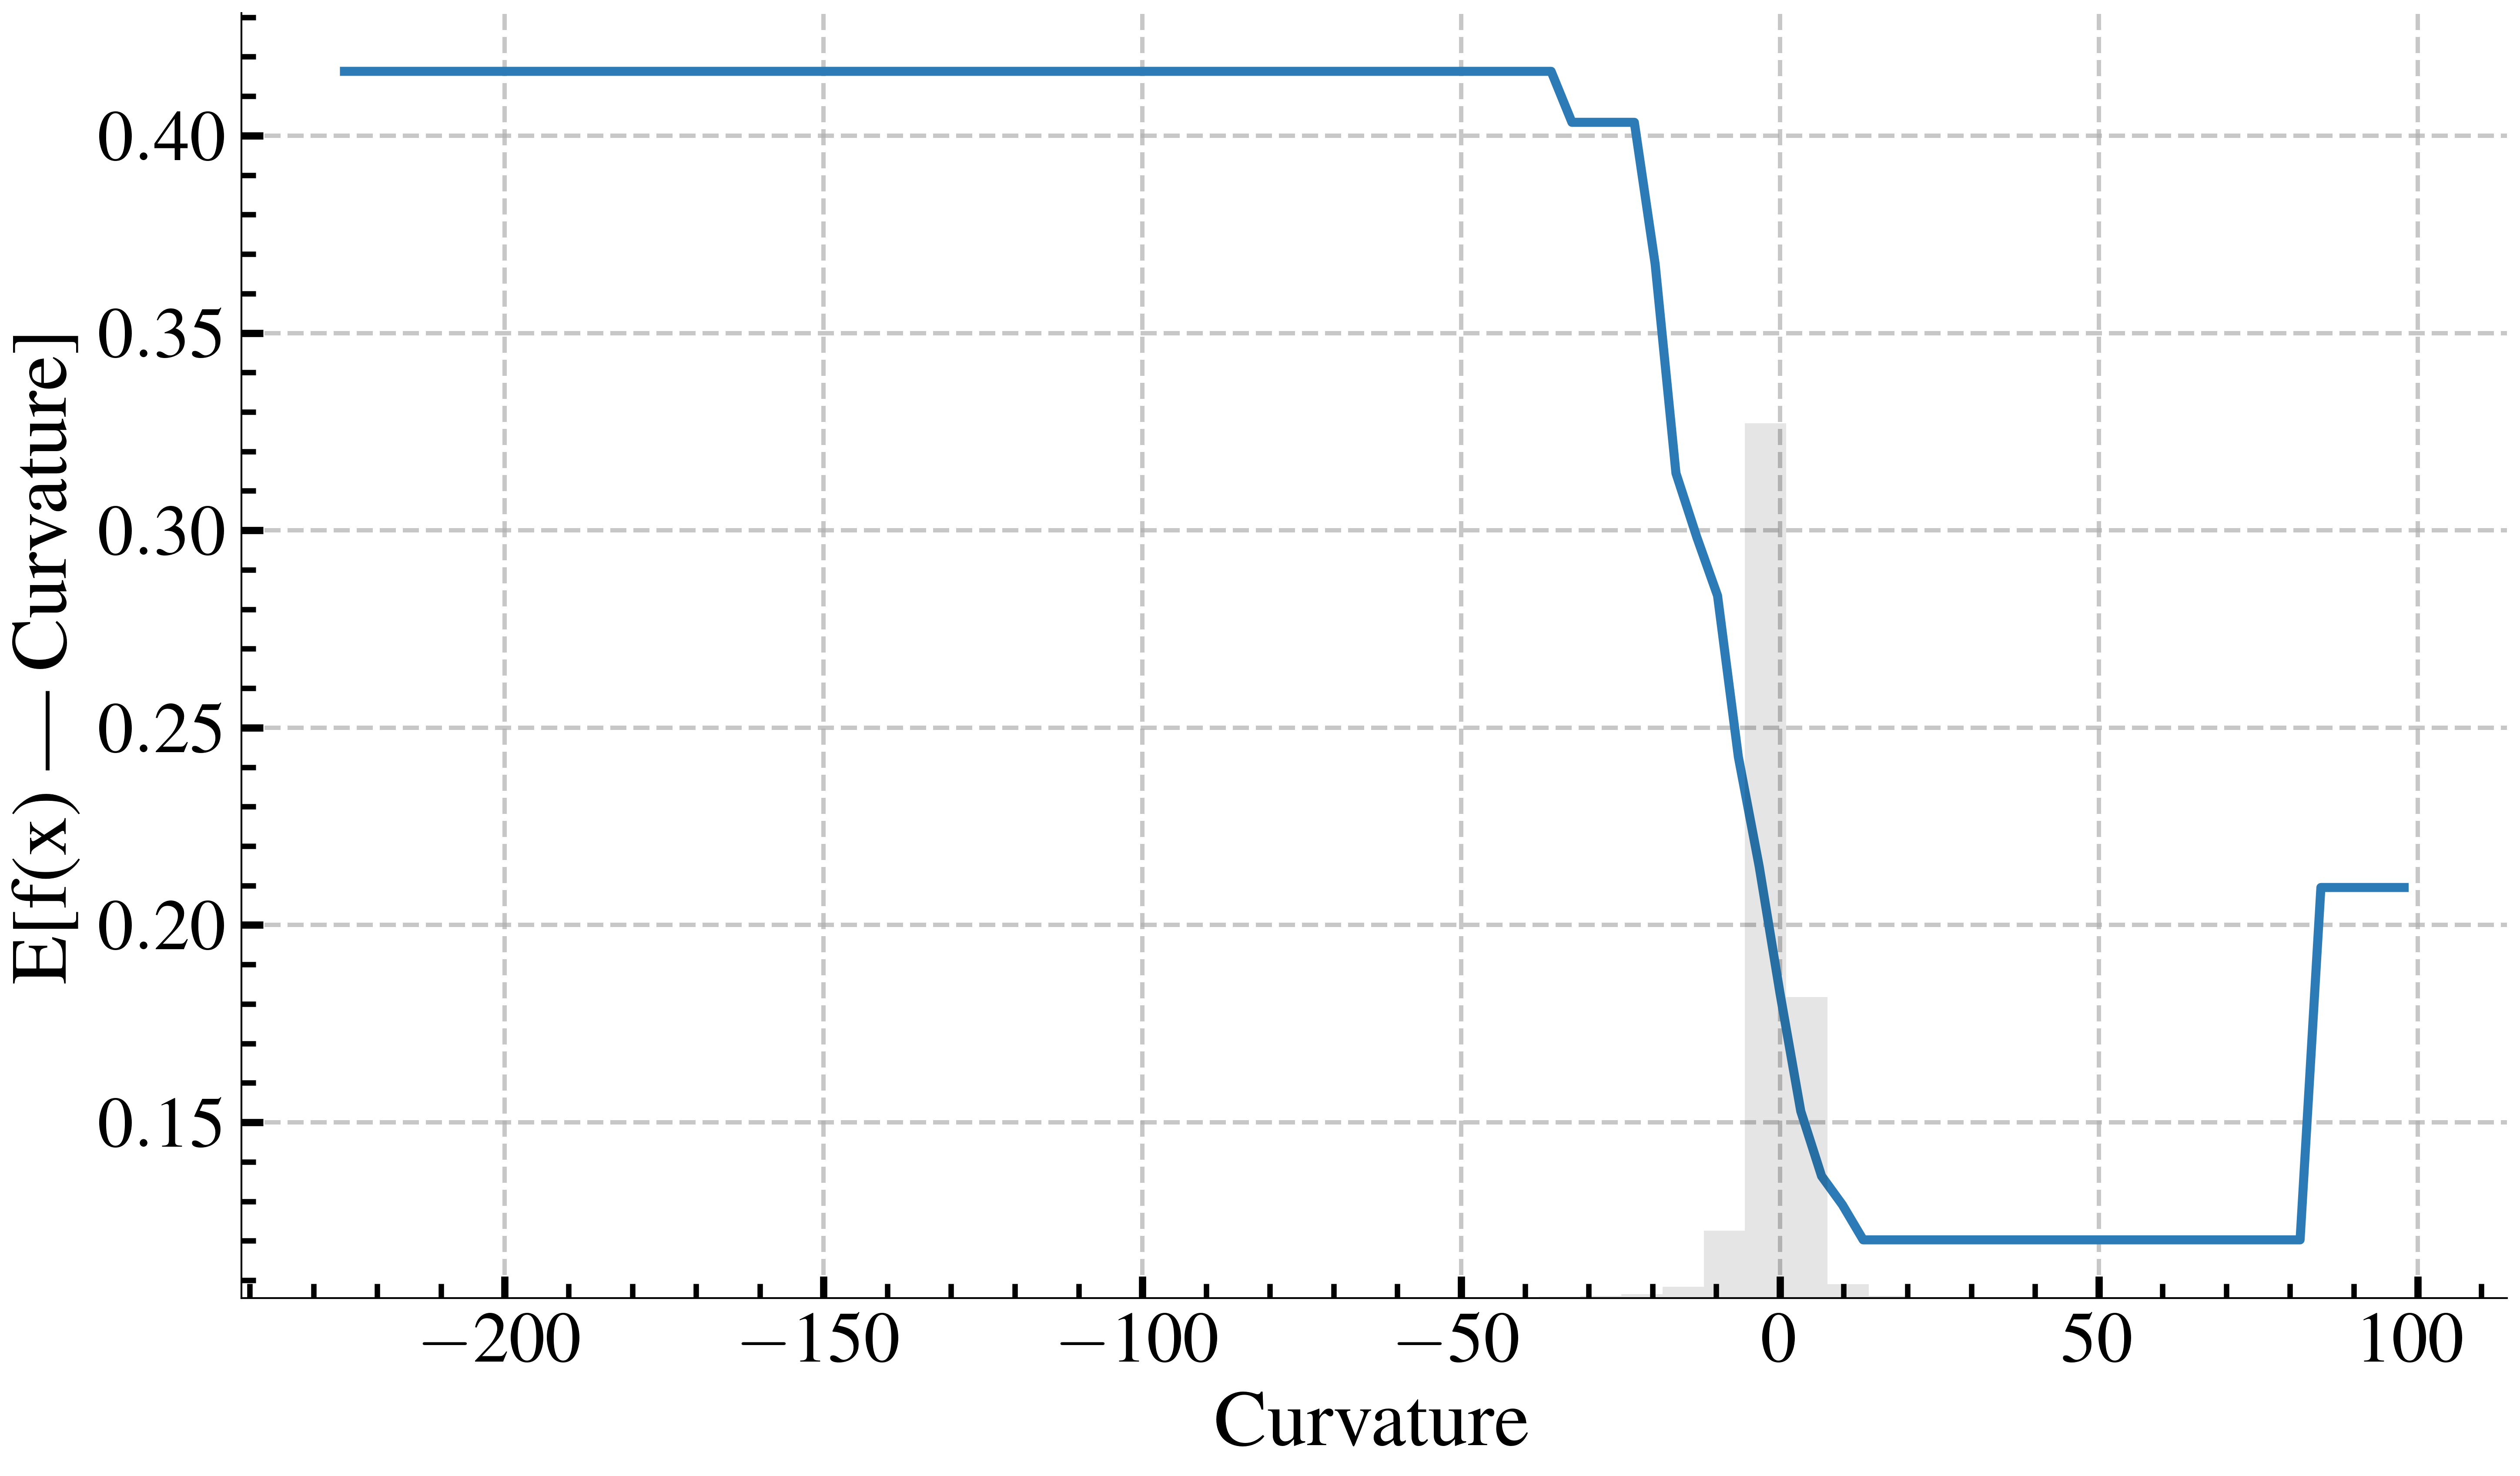

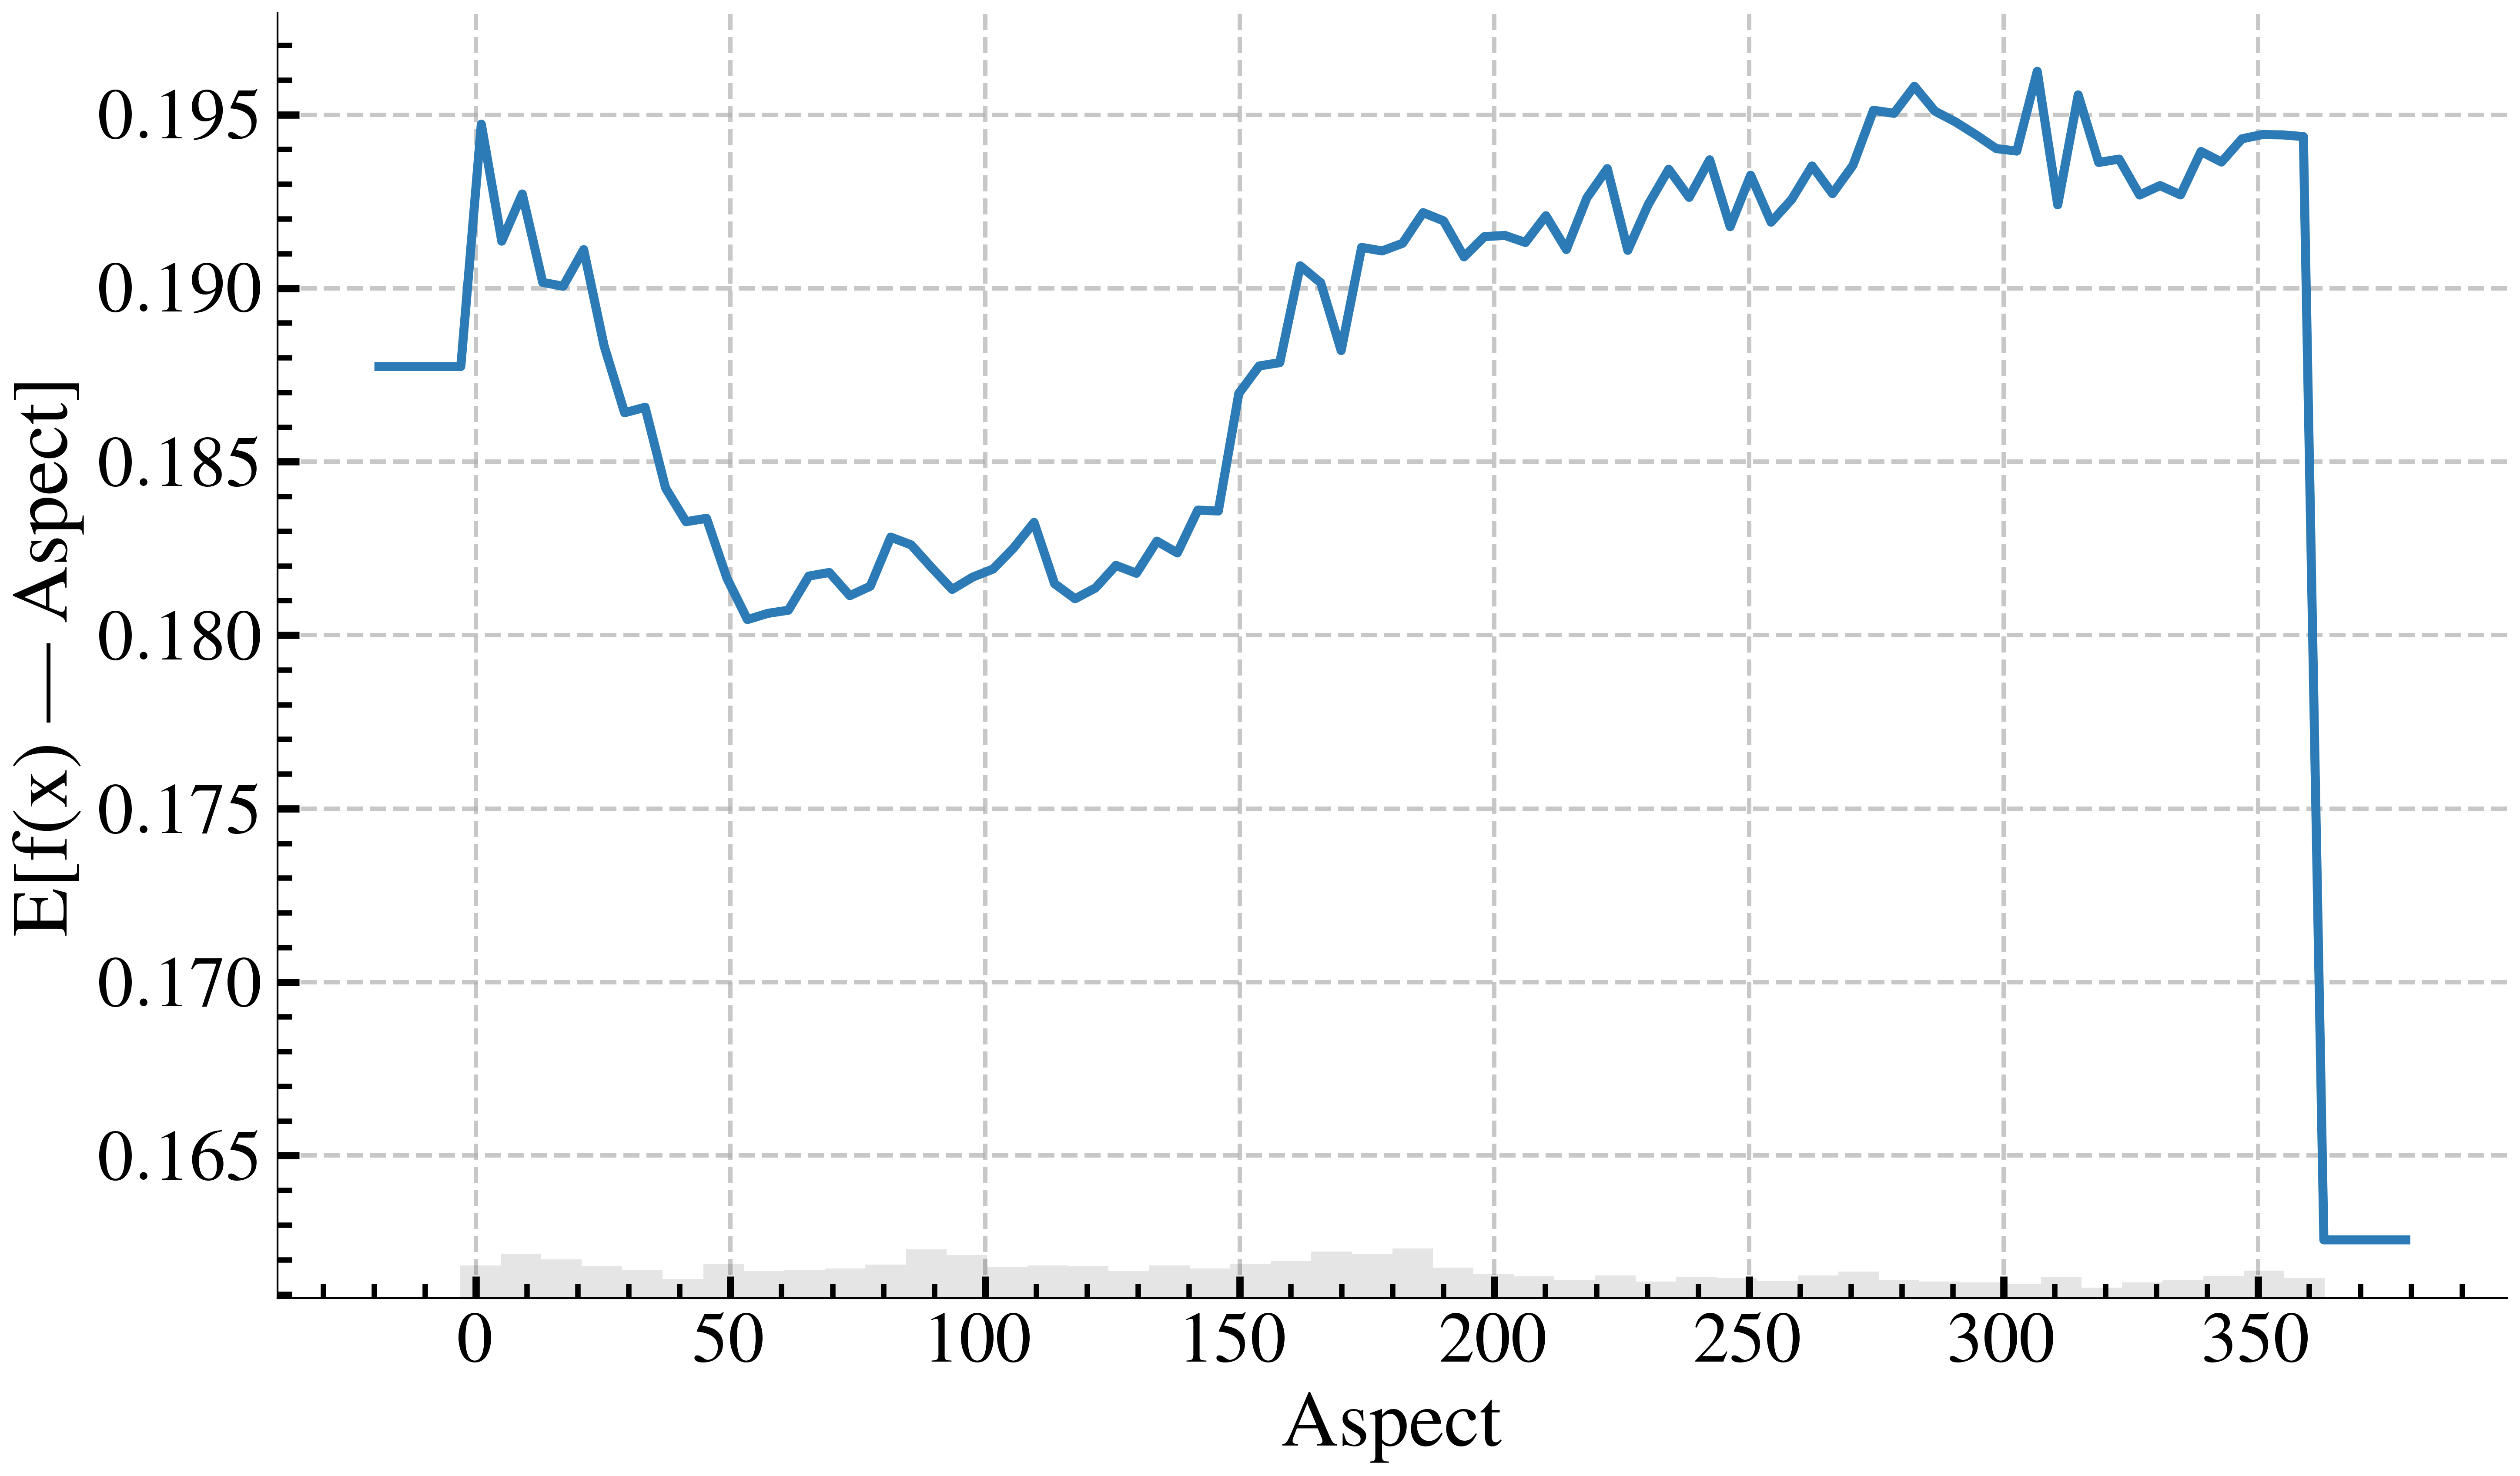

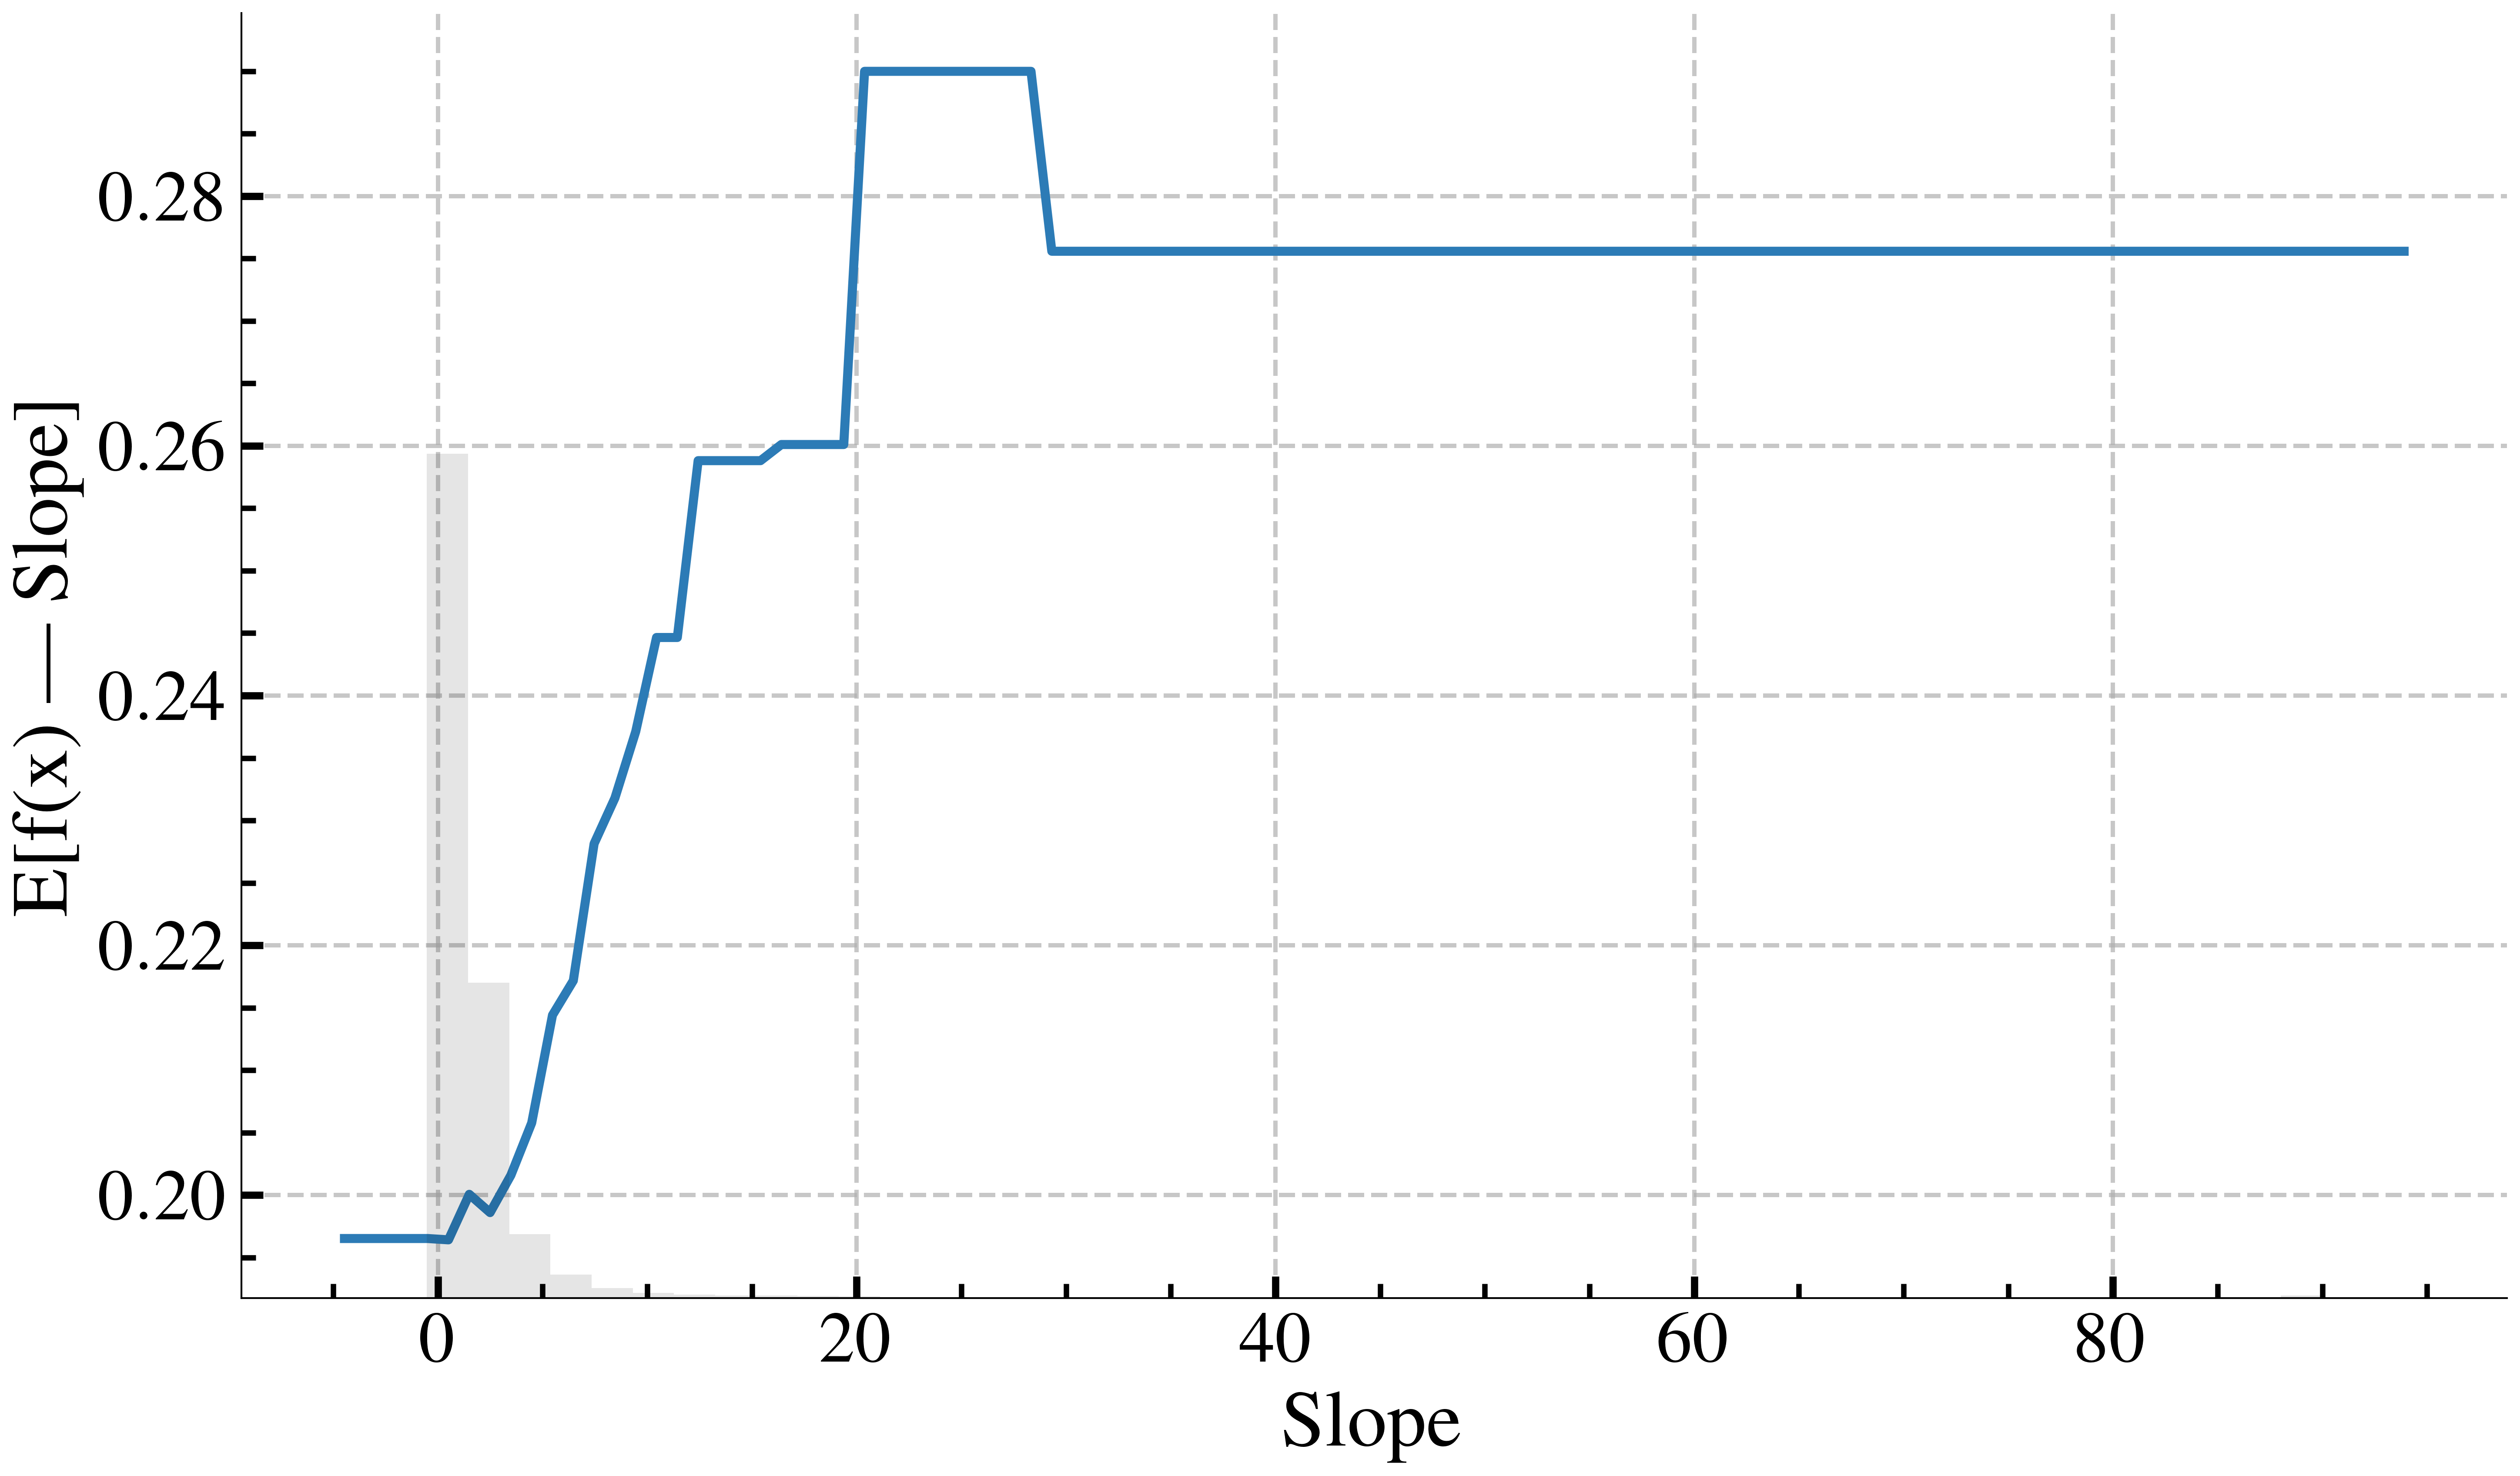

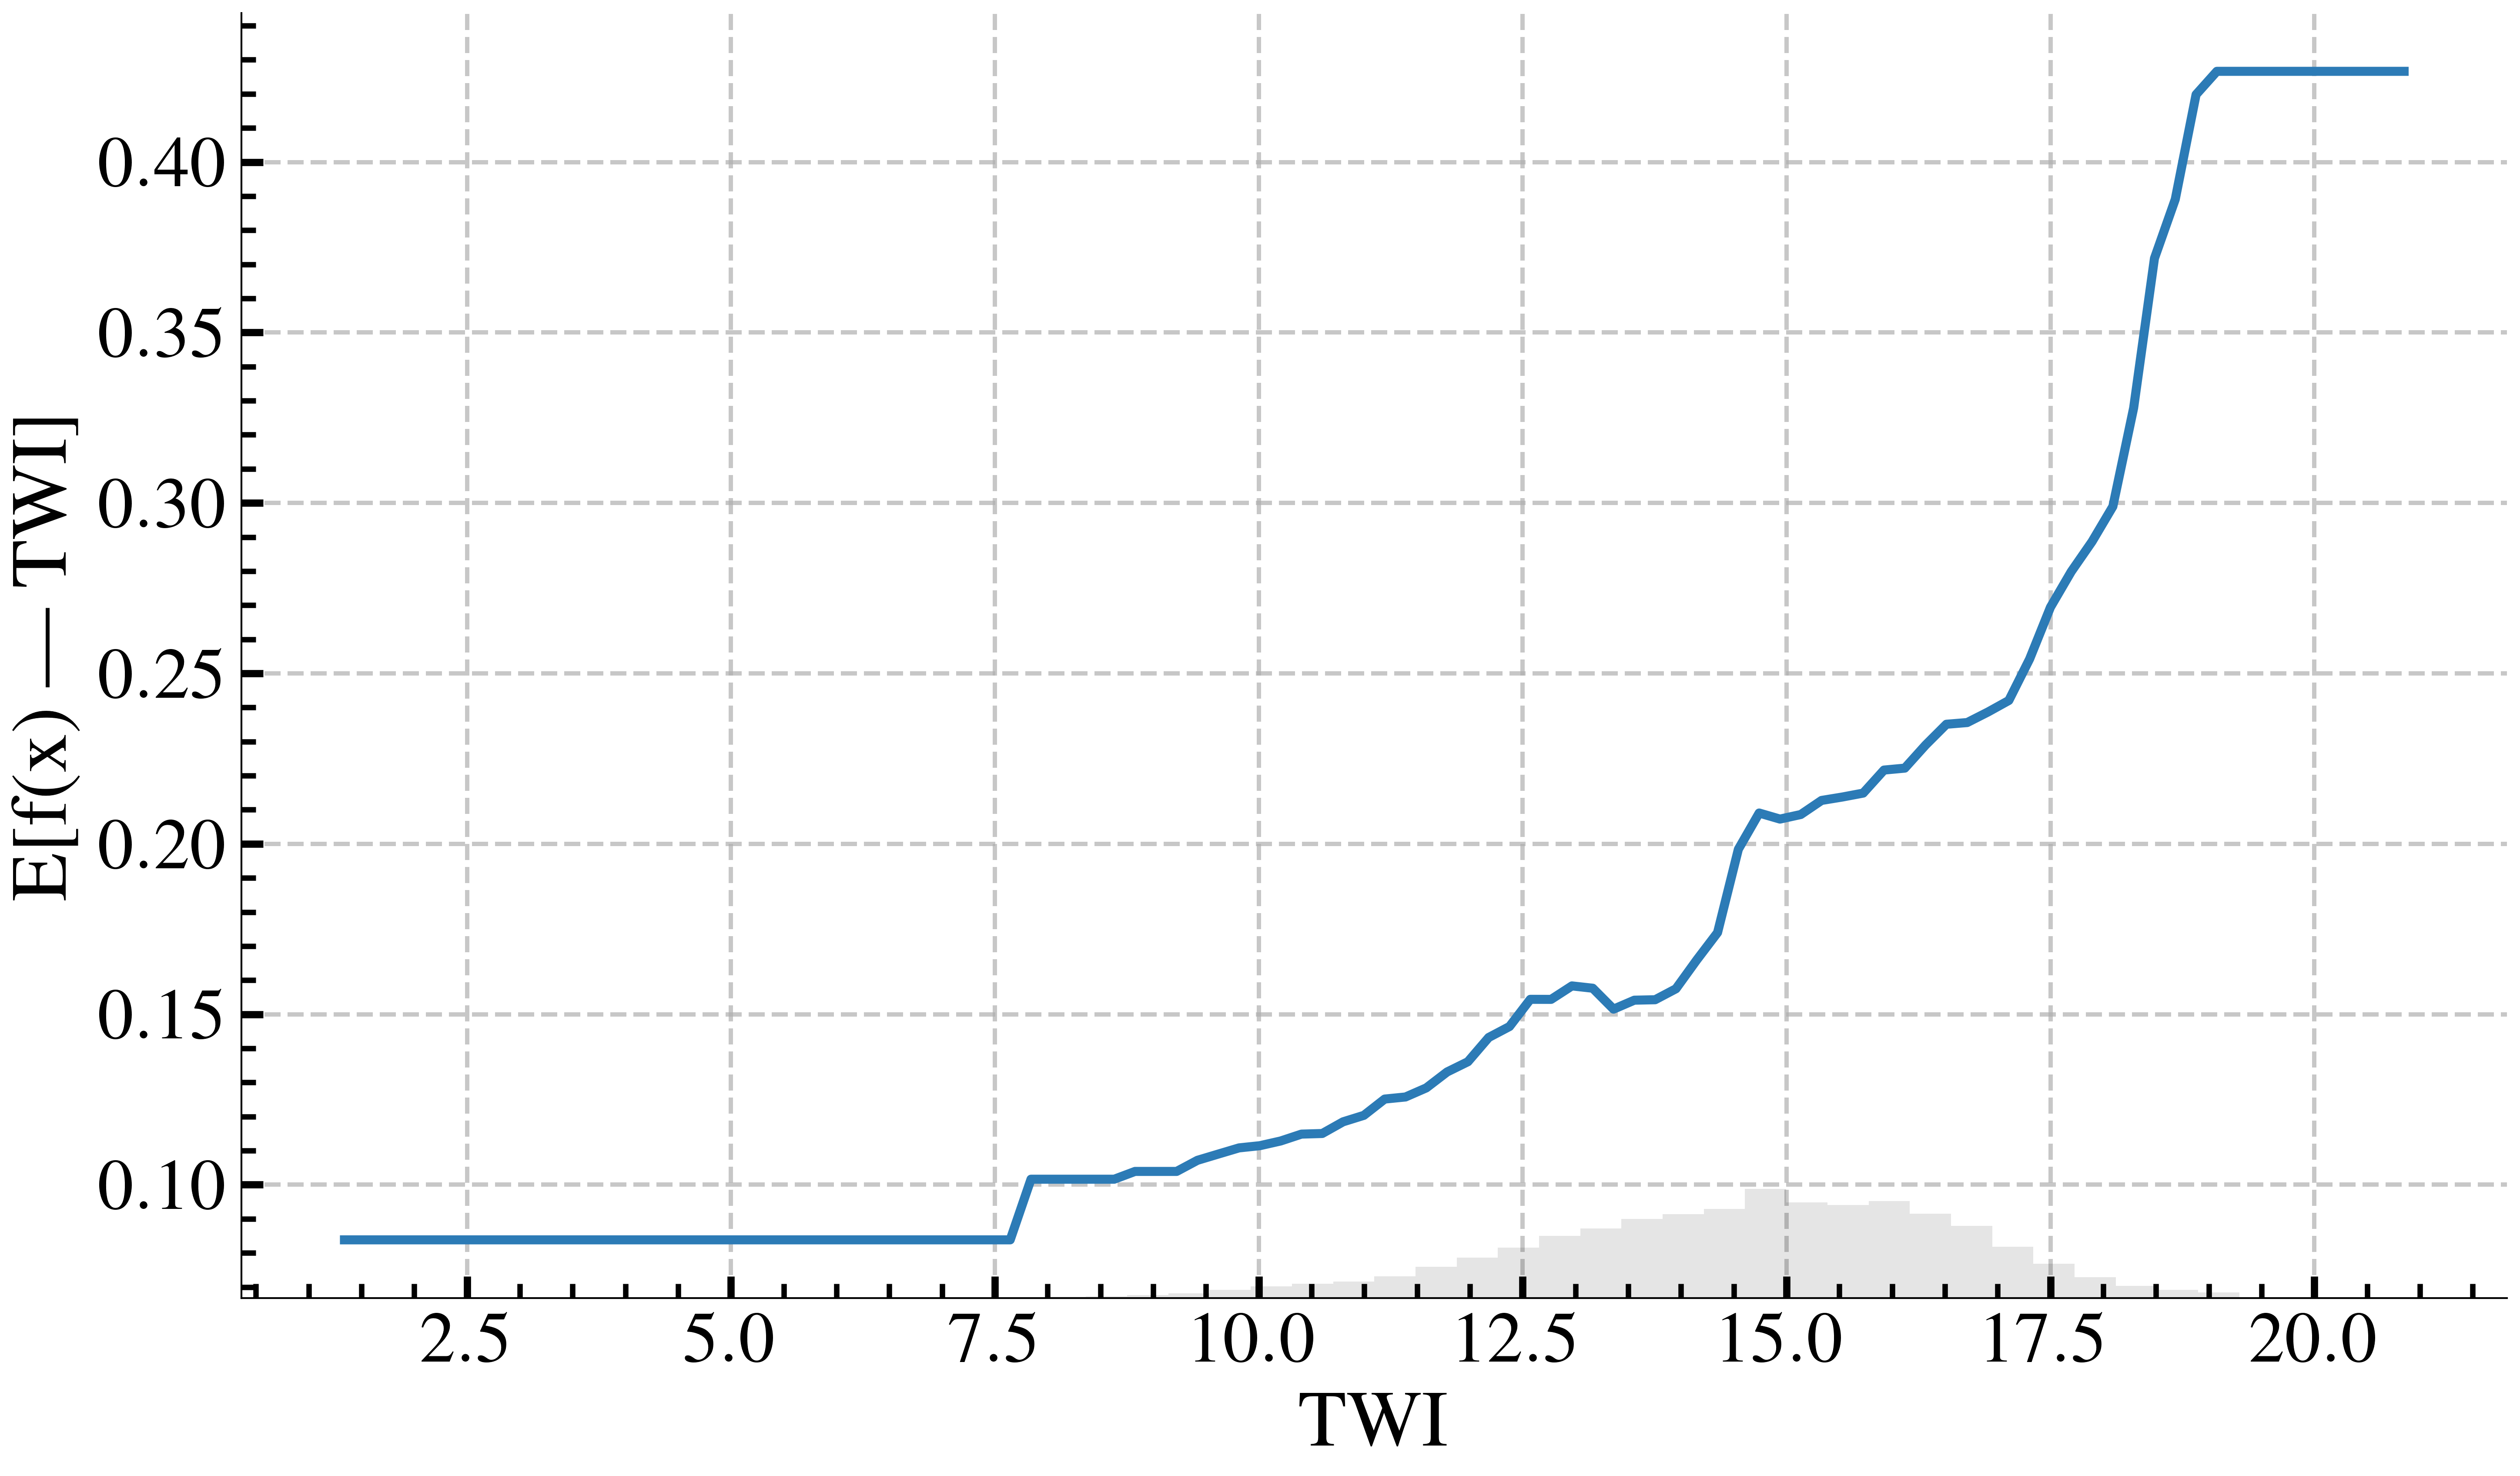

  0%|                                                                                            | 0/6 [13:11<?, ?it/s]


In [61]:
for f in tqdm(test_files[::-1]):
    print(f)
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    print(r2(df1.iloc[:,-1],pred))
    
    for feat in features:
        with plt.style.context(['ieee', 'science']):
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            # 生成PDP图
            shap.plots.partial_dependence(
                feat[0],
                model.predict, 
                df1.iloc[:,:-1],
                ice=False,
                ax=ax,
                show=False
            )

            # 坐标轴字体系统配置
            ax.tick_params(
                axis='both', 
                which='major', 
                labelsize=20,    # 主刻度字体
                length=6,        # 刻度线长度
                width=2,         # 刻度线宽度
                direction='in'   # 刻度方向
            )

            ax.tick_params(
                axis='both',
                which='minor', 
                labelsize=18,    # 次刻度字体
                length=4,
                width=1.5,
                direction='in'
            )

            # 轴标签字体配置
            ax.xaxis.label.set_size(22)  # X轴标签字体（特征名称）
            ax.yaxis.label.set_size(22)  # Y轴标签字体（SHAP值）


            # 网格与样式增强
            ax.grid(True, 
                   linestyle='--', 
                   alpha=0.7,
                   linewidth=1.2)  # 网格线宽

            # 颜色系统升级
            for line in ax.lines:
                line.set_color('#2c7bb6')  
                line.set_linewidth(2.5)
                line.set_antialiased(True)  # 抗锯齿

            for line in ax.lines[1:]:  
                line.set_color('#d7191c') 
                line.set_linestyle((0, (5, 2, 1, 2)))  # 自定义虚线模式
                line.set_linewidth(1.5)

            # 输出前布局优化
            plt.tight_layout(pad=2.0)  # 增加画布边距

            # 多格式保存
            for ext in ['pdf', 'tif', 'jpg']:
                plt.savefig(
                    rf'H:\EXP2\Figs\PDP1\{feat[0]}.{ext}',
                    dpi=600,
                    bbox_inches='tight',
                    facecolor='white',

                )

            plt.show()


    break

In [62]:
files=glob.glob(r"H:\EXP2\Figs\PDP1\*.tif")

In [63]:
len(files)

7

In [64]:
files

['H:\\EXP2\\Figs\\PDP1\\Aspect.tif',
 'H:\\EXP2\\Figs\\PDP1\\Curvature.tif',
 'H:\\EXP2\\Figs\\PDP1\\Elevation.tif',
 'H:\\EXP2\\Figs\\PDP1\\Land use.tif',
 'H:\\EXP2\\Figs\\PDP1\\Manhole density.tif',
 'H:\\EXP2\\Figs\\PDP1\\Slope.tif',
 'H:\\EXP2\\Figs\\PDP1\\TWI.tif']

In [56]:
import patchworklib as pw

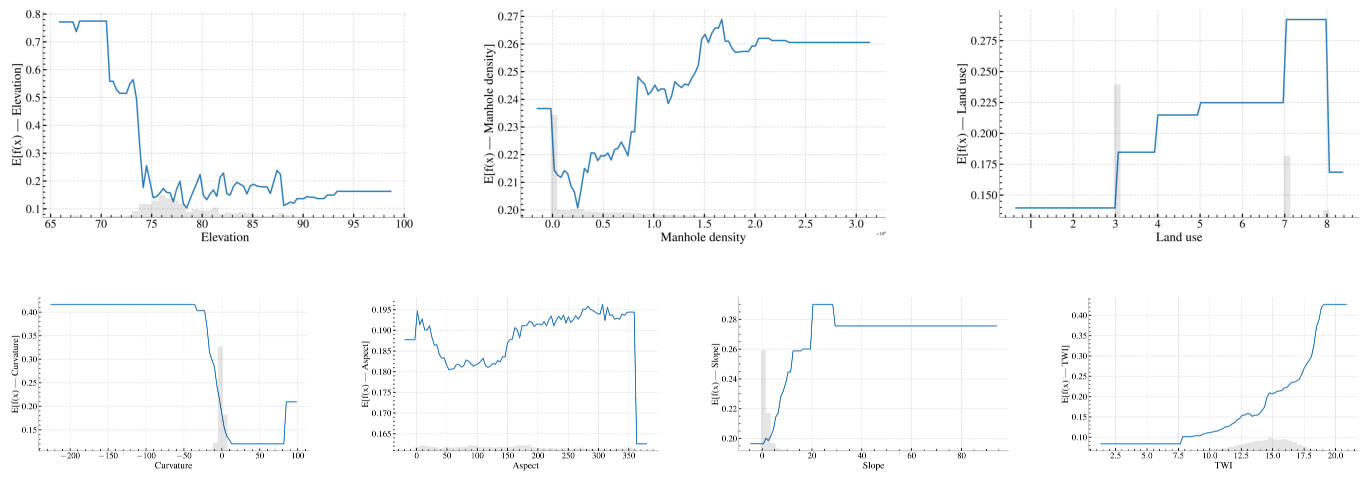

In [65]:
ax1=pw.Brick(figsize=(3,2))
data=gdal.Open(files[0]).ReadAsArray()
ax1.imshow(data.transpose(1,2,0))
ax1.axis("off")

ax2=pw.Brick(figsize=(3,2))
data=gdal.Open(files[1]).ReadAsArray()
ax2.imshow(data.transpose(1,2,0))
ax2.axis("off")

ax3=pw.Brick(figsize=(3,2))
data=gdal.Open(files[2]).ReadAsArray()
ax3.imshow(data.transpose(1,2,0))
ax3.axis("off")

ax4=pw.Brick(figsize=(3,2))
data=gdal.Open(files[3]).ReadAsArray()
ax4.imshow(data.transpose(1,2,0))
ax4.axis("off")

ax5=pw.Brick(figsize=(3,2))
data=gdal.Open(files[4]).ReadAsArray()
ax5.imshow(data.transpose(1,2,0))
ax5.axis("off")

ax6=pw.Brick(figsize=(3,2))
data=gdal.Open(files[5]).ReadAsArray()
ax6.imshow(data.transpose(1,2,0))
ax6.axis("off")

ax7=pw.Brick(figsize=(3,2))
data=gdal.Open(files[6]).ReadAsArray()
ax7.imshow(data.transpose(1,2,0))
ax7.axis("off")
#Arrange "ax1," "ax2," and "ax4" horizontally.

ax124 = (ax3|ax5|ax4)/(ax2|ax1|ax6|ax7)

ax124.savefig("H:\EXP2\Figs\PDP1\pdp_all.png",dpi=600)
ax124.savefig("H:\EXP2\Figs\PDP1\pdp_all.pdf",dpi=600)
ax124.savefig("H:\EXP2\Figs\PDP1\pdp_all.tif",dpi=600)

In [ ]:
for f in tqdm(test_files):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    
    
    print(r2(df1.iloc[:,-1],pred))
    np.save(rf"H:\EXP2\new_shap1\{name}_data",df1)
    
    shap_values = explainer.shap_values(df1.iloc[:,:-1]) 
    
    
    
    break
    np.save(rf"H:\EXP2\new_shap1\{name}_shap",shap_values)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

0.9720813880503122


In [61]:
from sklearn.inspection import partial_dependence

In [74]:
features=[["Elevation"],["Manhole density"],["Land use"], ["Curvature"],["Aspect"],["Slope"],["TWI"],]

In [75]:
test_files[::-1]

['E:\\60Min\\100A60Min500MAXA01.dfs2',
 'E:\\60Min\\50A60Min500MAXA01.dfs2',
 'E:\\60Min\\20A60Min167MAXA01.dfs2',
 'E:\\60Min\\10A60Min382MAXA01.dfs2',
 'E:\\60Min\\5A60Min700MAXA01.dfs2',
 'E:\\60Min\\2A60Min167MAXA01.dfs2']

In [77]:
for f in tqdm(test_files[::-1]):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    
    
    print(r2(df1.iloc[:,-1],pred))
    print(df1.shape)
    
    for i,feat in enumerate(features):
        pdp_results = partial_dependence(
        estimator=model,percentiles=(0,1),
            
        X=df1.iloc[:,:-1],categorical_features=[True if col=="Land use" else False for col in df1.columns.tolist()[:-1]],
        features=feat,feature_names=df1.columns.tolist(),
        grid_resolution=100, 
        kind='average')

    # 或'individual'绘制个体条件期望
        np.save(rf"H:\EXP2\Figs\new\{feat}_{name}.npy",pdp_results)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

0.967904760354401
(223613, 69)


 17%|█████████████▊                                                                     | 1/6 [09:39<48:15, 579.07s/it]

0.9316808642294973
(206622, 69)


 33%|███████████████████████████▋                                                       | 2/6 [18:47<37:25, 561.33s/it]

0.98038555150952
(179275, 69)


 50%|█████████████████████████████████████████▌                                         | 3/6 [27:29<27:09, 543.25s/it]

0.9791049497088802
(161362, 69)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [35:46<17:29, 524.88s/it]

0.970340042237763
(130362, 69)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [43:35<08:24, 504.80s/it]

0.9668012559827021
(102523, 69)


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [51:03<00:00, 510.59s/it]


In [71]:
features=[          ["Elevation","Manhole density"],["Elevation","Land use"],
          ["Elevation","Curvature"],["Elevation","Aspect"],["Elevation","Slope"],["Elevation","TWI"],
          ["Manhole density","Land use"],["Manhole density","Curvature"],["Manhole density","Aspect"],
          ["Manhole density","Slope",],  ["Manhole density","TWI"],
          ["Land use","Curvature",],["Land use","Aspect",],["Land use","Slope"],["Land use","TWI"],
          ["Curvature","Aspect"], ["Curvature","Slope"],["Curvature","TWI"],
          ["Aspect","Slope"],["Aspect","TWI"],["Slope","TWI"],]

In [ ]:
for f in tqdm(test_files[::-1]):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    
    
    print(r2(df1.iloc[:,-1],pred))
    print(df1.shape)
    
    for feat in features:
        pdp_results = partial_dependence(
        estimator=model,
        X=df1.iloc[:,:-1],categorical_features=[True if col=="Land use" else False for col in df1.columns.tolist()[:-1]],
        features=feat,feature_names=df1.columns.tolist(),
        grid_resolution=50, 
        kind='average')

    # 或'individual'绘制个体条件期望
        np.save(rf"H:\EXP2\Figs\new\{feat}_{name}.npy",pdp_results)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

0.967904760354401
(223613, 69)


In [78]:
pred=model.predict(df_test.iloc[:,:-1])


print(r2(df_test.iloc[:,-1],pred))
print(df_test.shape)

for i,feat in enumerate(features):
    pdp_results = partial_dependence(
    estimator=model,percentiles=(0,1),

    X=df_test.iloc[:,:-1],categorical_features=[True if col=="Land use" else False for col in df1.columns.tolist()[:-1]],
    features=feat,feature_names=df_test.columns.tolist(),
    grid_resolution=100, 
    kind='average')

# 或'individual'绘制个体条件期望
    np.save(rf"H:\EXP2\Figs\all\{feat}_all.npy",pdp_results)

0.9638979032436223
(1003757, 69)


# ALE

In [68]:
from PyALE import ale
import matplotlib.ticker as ticker

In [66]:
from matplotlib import ticker

# 在ALE绘图后添加刻度优化模块
def optimize_ticks(ax, axis='y', max_ticks=5):
    """智能刻度优化函数"""
    # 获取原始刻度值
    raw_ticks = getattr(ax, f'get_{axis}ticks')()
    
    # 动态确定小数精度
    data_range = raw_ticks.max() - raw_ticks.min()
    if data_range <= 0.025:
        precision = 3
    elif data_range < 0.04:
        precision = 4 
    else:
        precision = 1
    
    # 设置格式化器
    formatter = ticker.StrMethodFormatter(f"{{x:.{precision}f}}")
    getattr(ax, f'{axis}axis').set_major_formatter(formatter)
    
    # 生成非重复刻度
    tick_generator = ticker.MaxNLocator(
        nbins=max_ticks,
        prune='both',  # 自动修剪边缘空白
        steps=[1, 2, 5, 10]  # 优选步长
    )
    new_ticks = tick_generator.tick_values(raw_ticks.min(), raw_ticks.max())
    
    # 应用优化刻度
    getattr(ax, f'set_{axis}ticks')(new_ticks)
    getattr(ax, f'set_{axis}ticklabels')(
        [formatter(tick) for tick in new_ticks]
    )

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9664196011004981


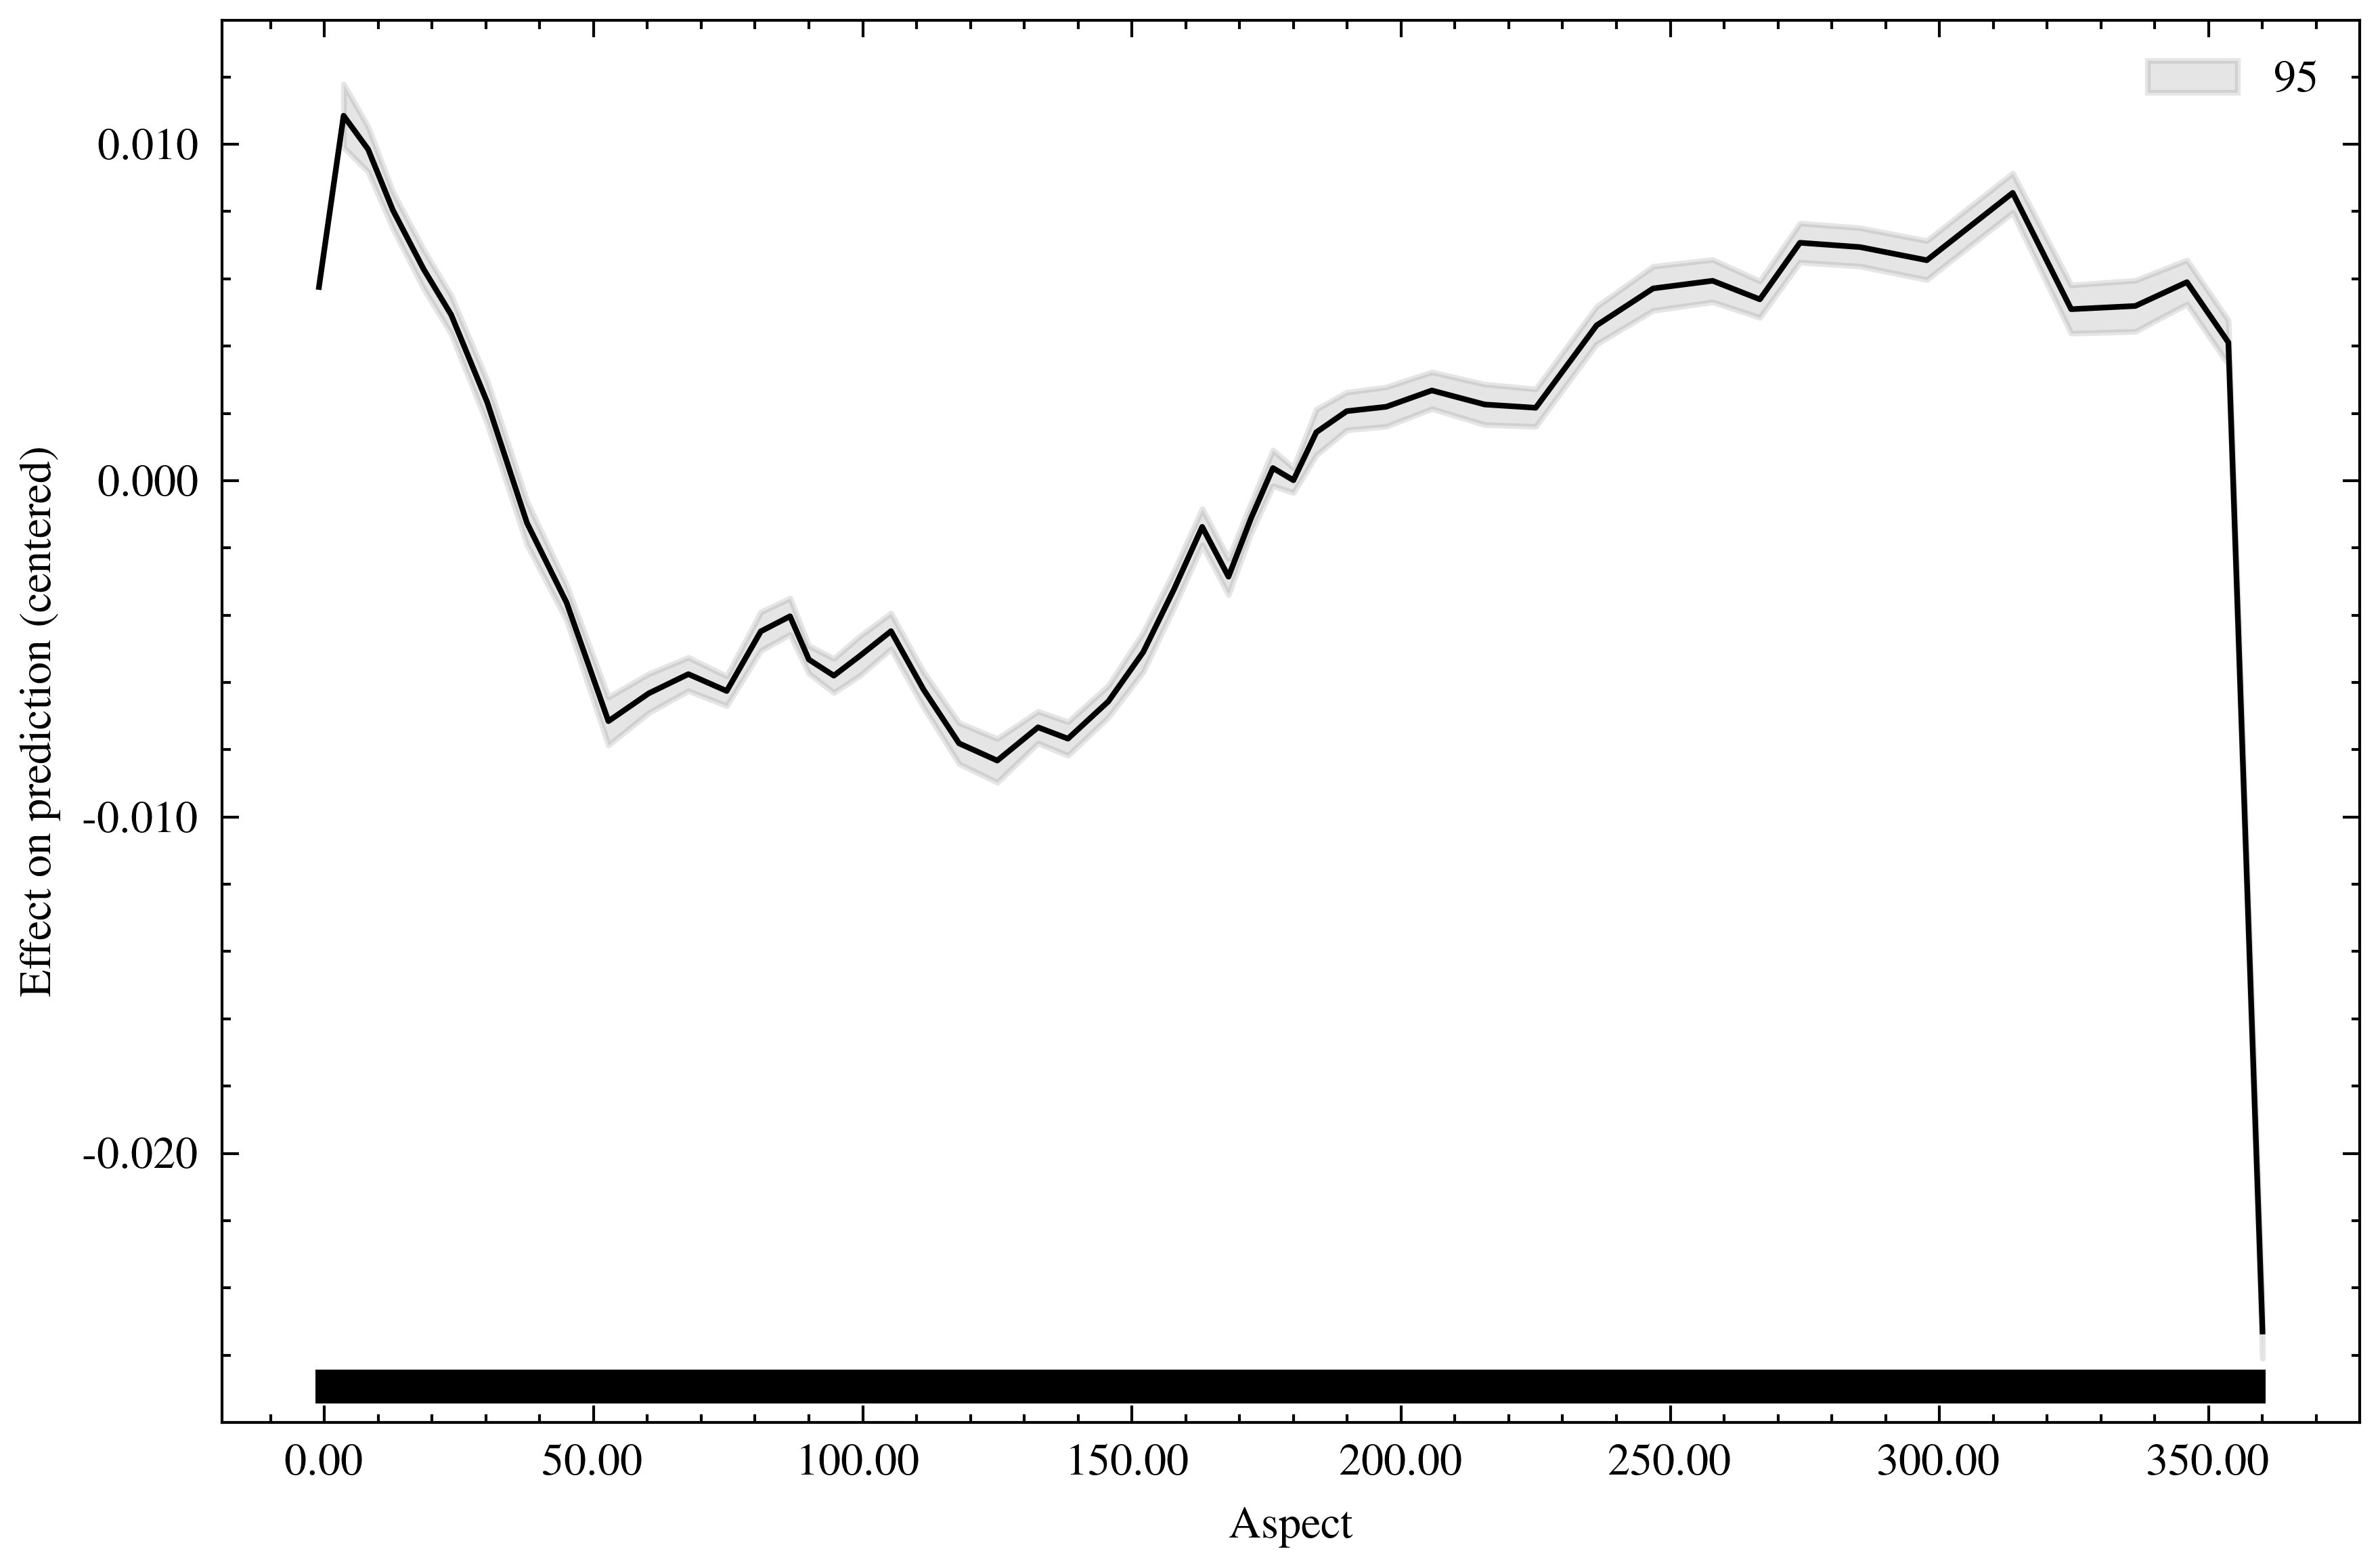

  0%|                                                                                            | 0/6 [10:20<?, ?it/s]


In [74]:
for f in tqdm(test_files[::-1]):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    print(r2(df1.iloc[:,-1],pred))
    features=[["Aspect"]]
    for i, feat in enumerate(features):
        with plt.style.context(['science','ieee']):
            fig,ax=plt.subplots(1,1,figsize=(6,4))
            ale_eff = ale(
                X=df1.iloc[:,:-1], model=model, feature=feat, 
                grid_size=50, include_CI=True, C=0.95,ax=ax,fig=fig,
            )
            # 设置 x 轴显示为三位小数
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
            optimize_ticks(ax, axis='y', max_ticks=6)
            # 设置 y 轴显示为两位小数
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
            ax.set_title("")

            plt.tight_layout()

            save_path = rf"H:\EXP2\Figs\PDP1\ale_{feat}.pdf"  # 按特征命名更清晰
            plt.savefig(save_path, bbox_inches='tight', dpi=600)

            plt.show()


    break

In [72]:
ax.get_yticks()

array([-0.015, -0.01 , -0.005,  0.   ,  0.005])

In [70]:
locator = MaxNLocator(nbins=max_ticks, prune='both', steps=[1, 2, 5, 10])
ax.yaxis.set_major_locator(locator)
# 获取当前刻度值并去重
y_ticks = ax.get_yticks()
unique_ticks = sorted(list({round(t, 5) for t in y_ticks}))  # 保留5位小数去重
ax.set_yticks(unique_ticks)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

# 不同事件对应的人孔密度

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9664196011004981


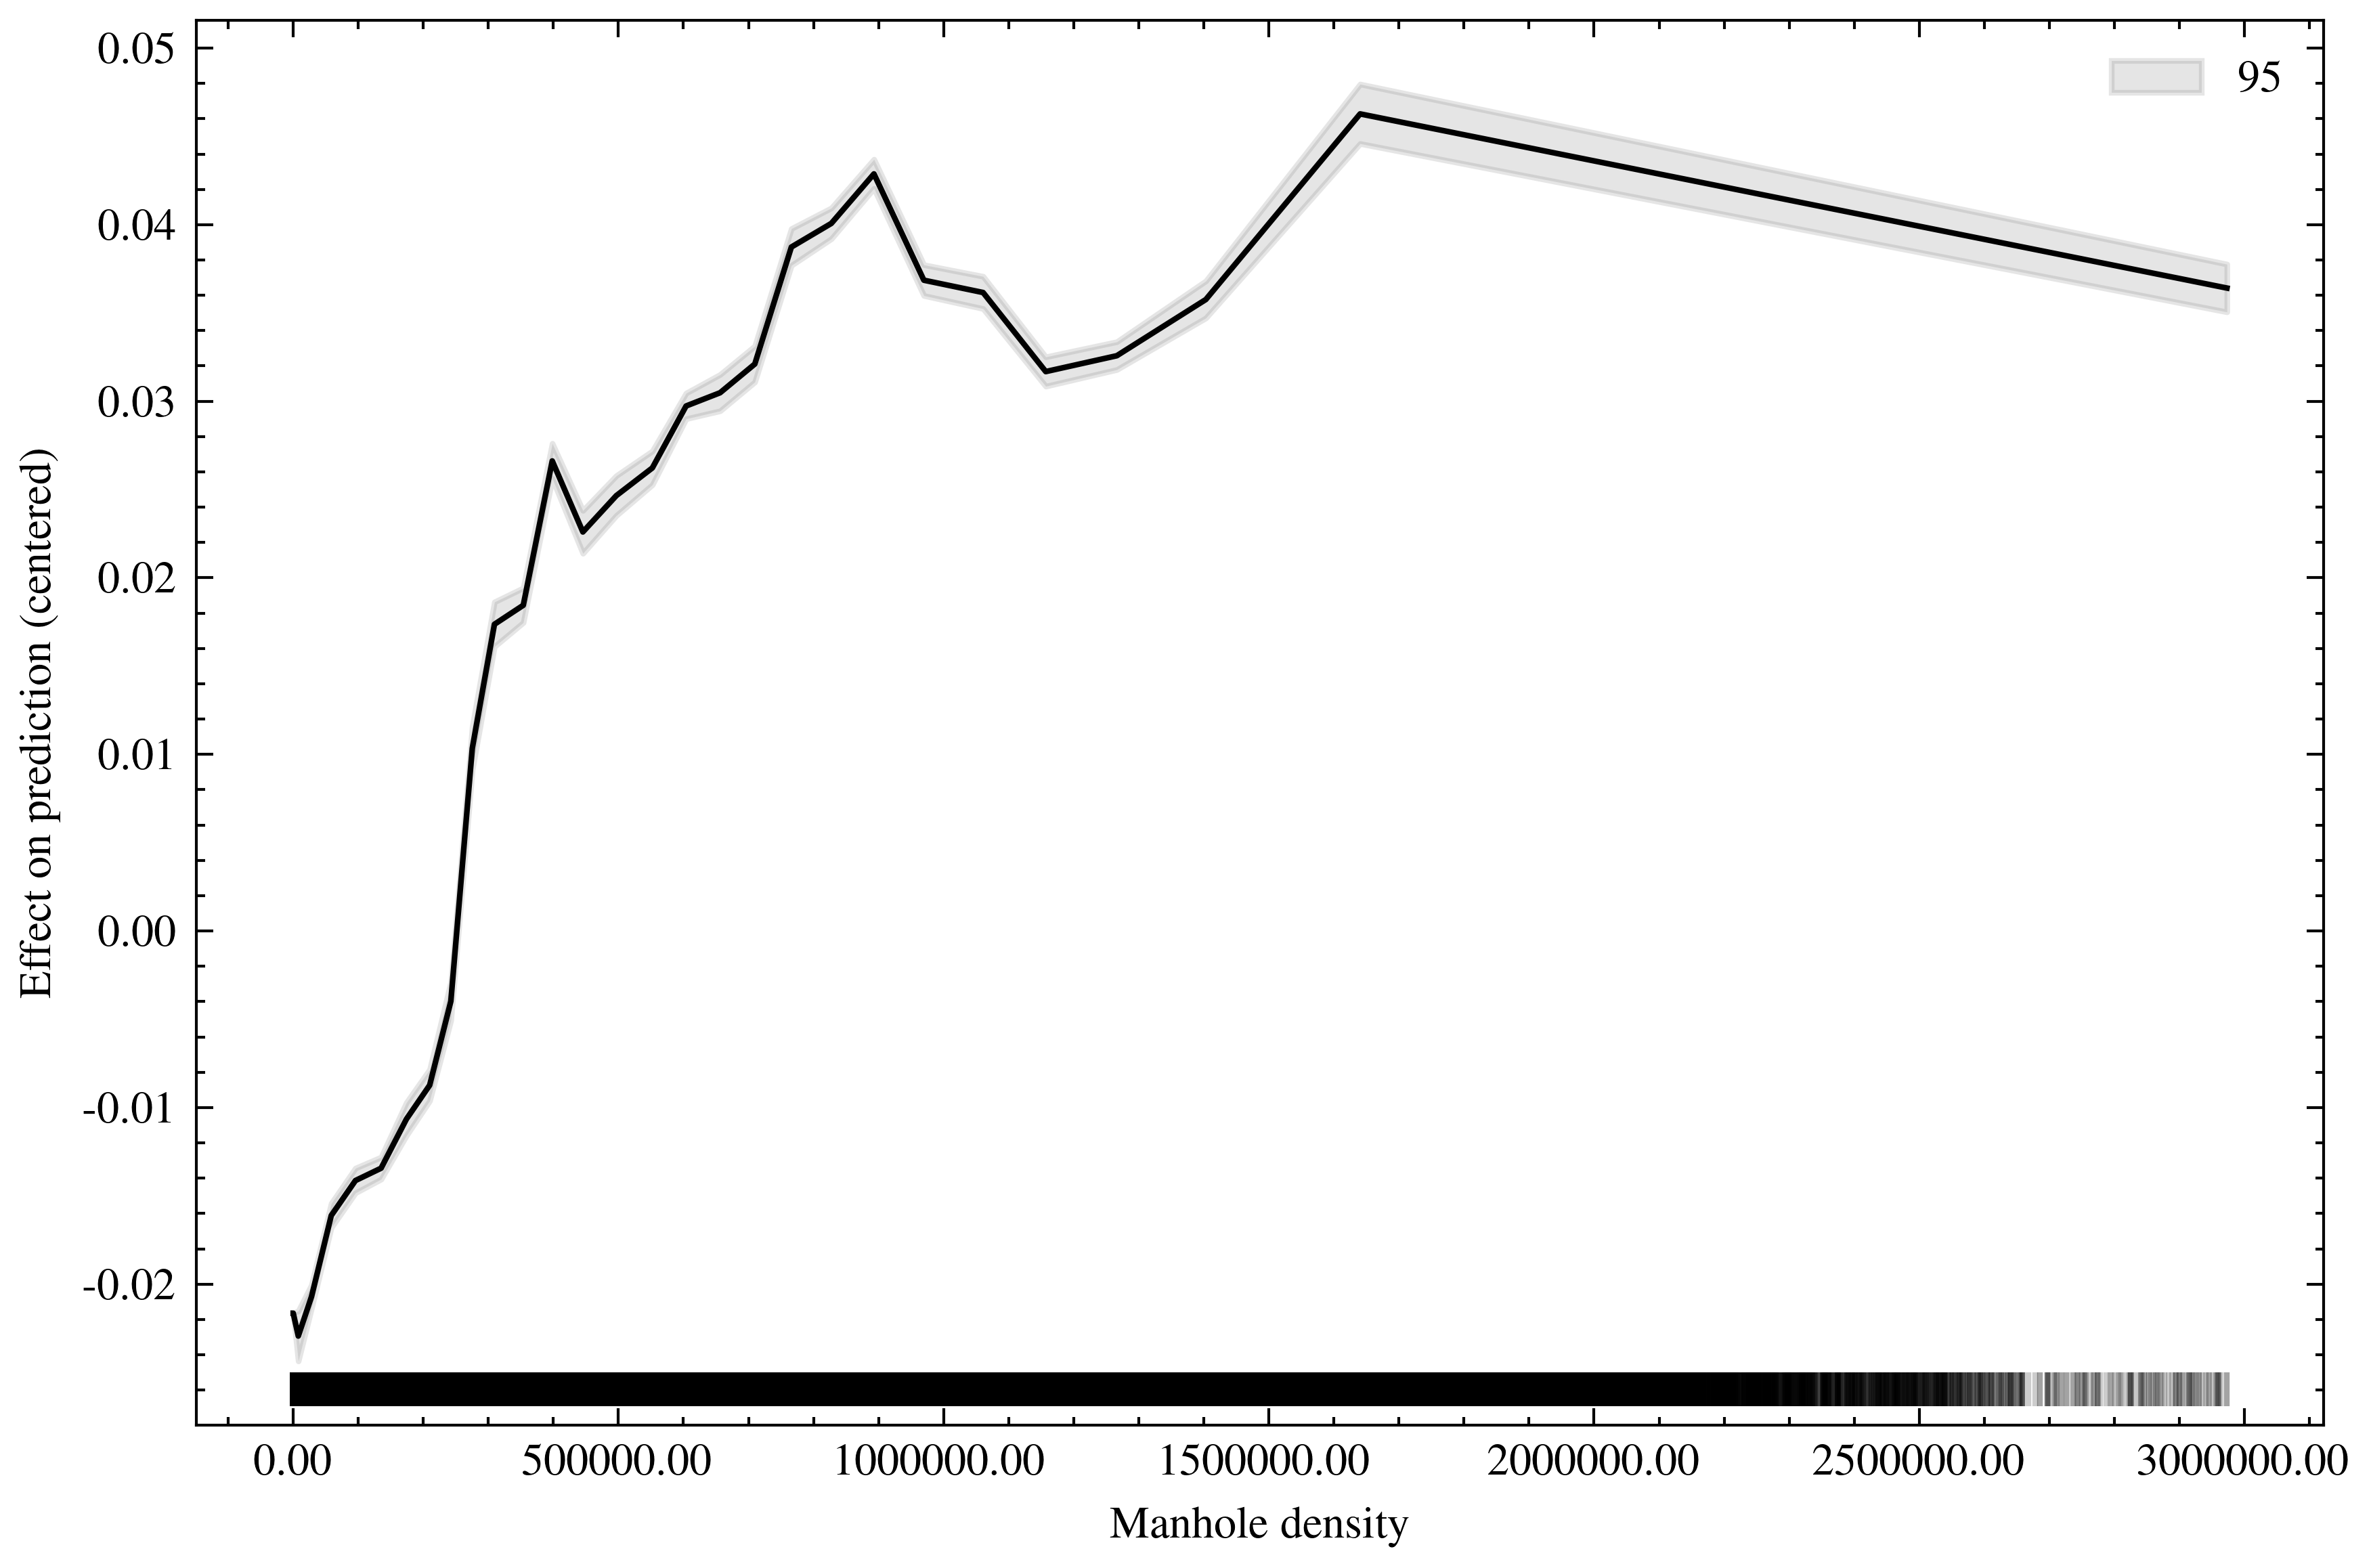

 17%|█████████████▊                                                                     | 1/6 [03:11<15:59, 192.00s/it]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9264831894215024


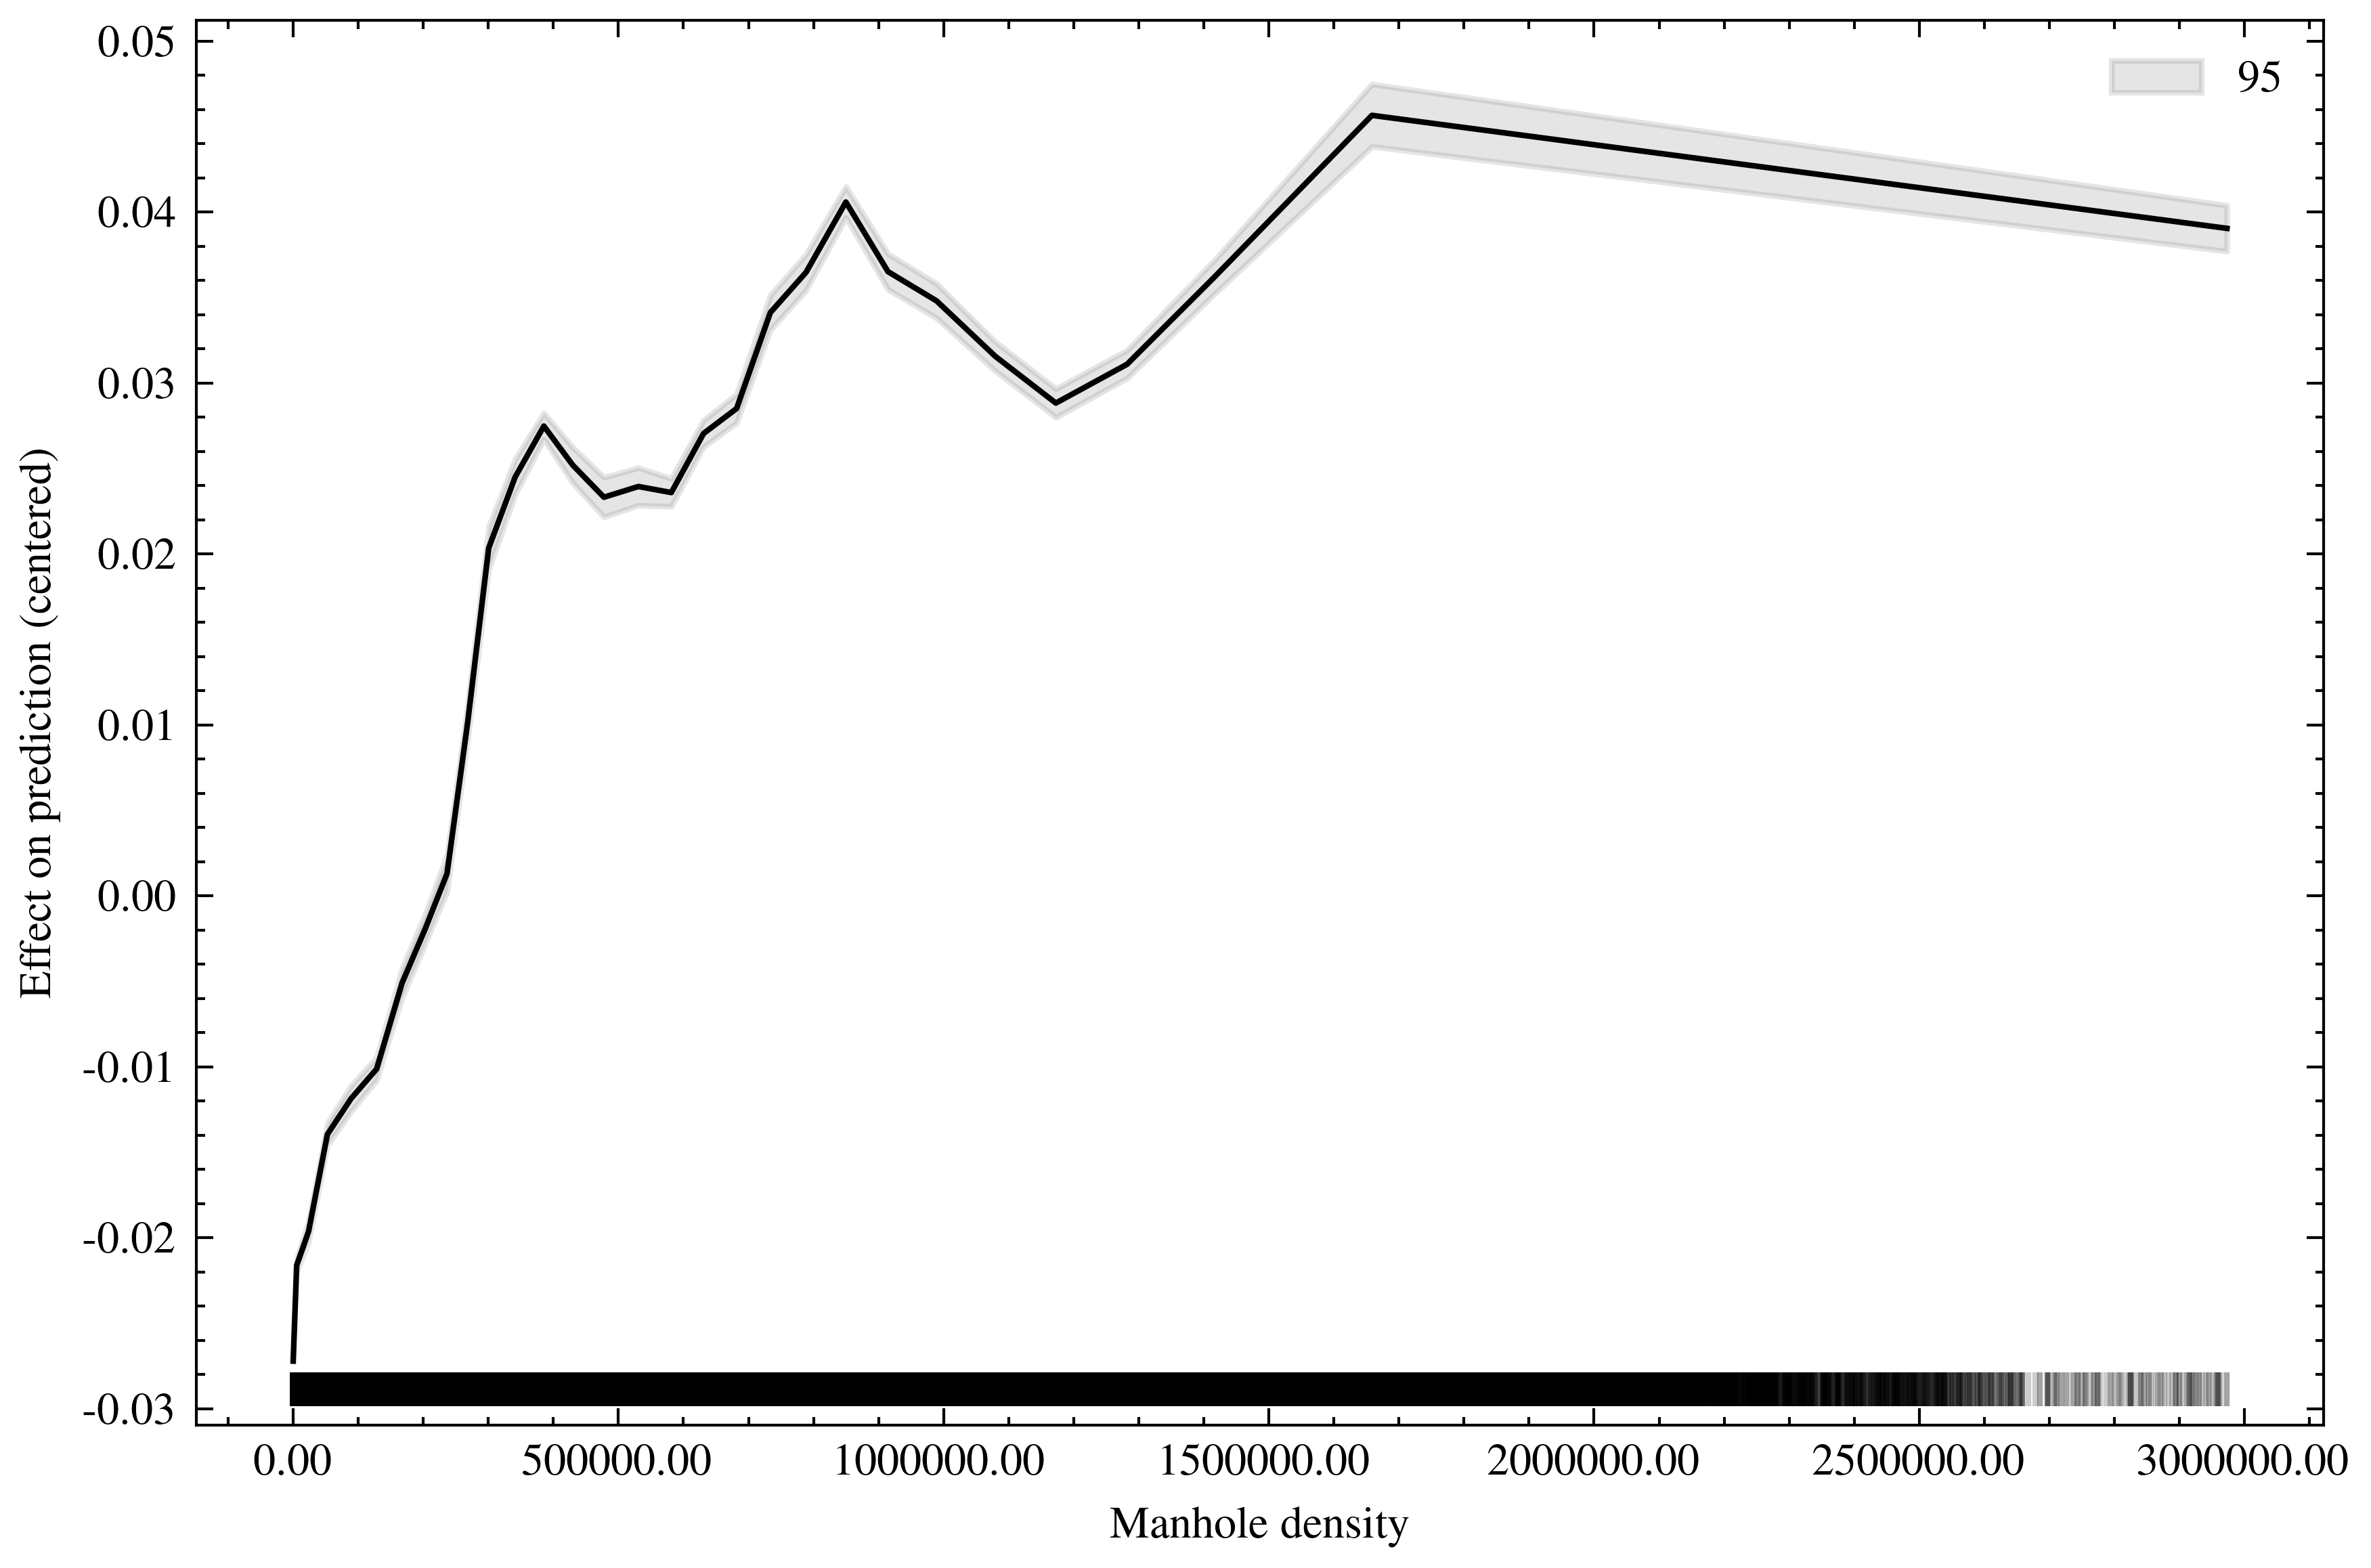

 33%|███████████████████████████▋                                                       | 2/6 [06:01<11:53, 178.48s/it]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9763461709766665


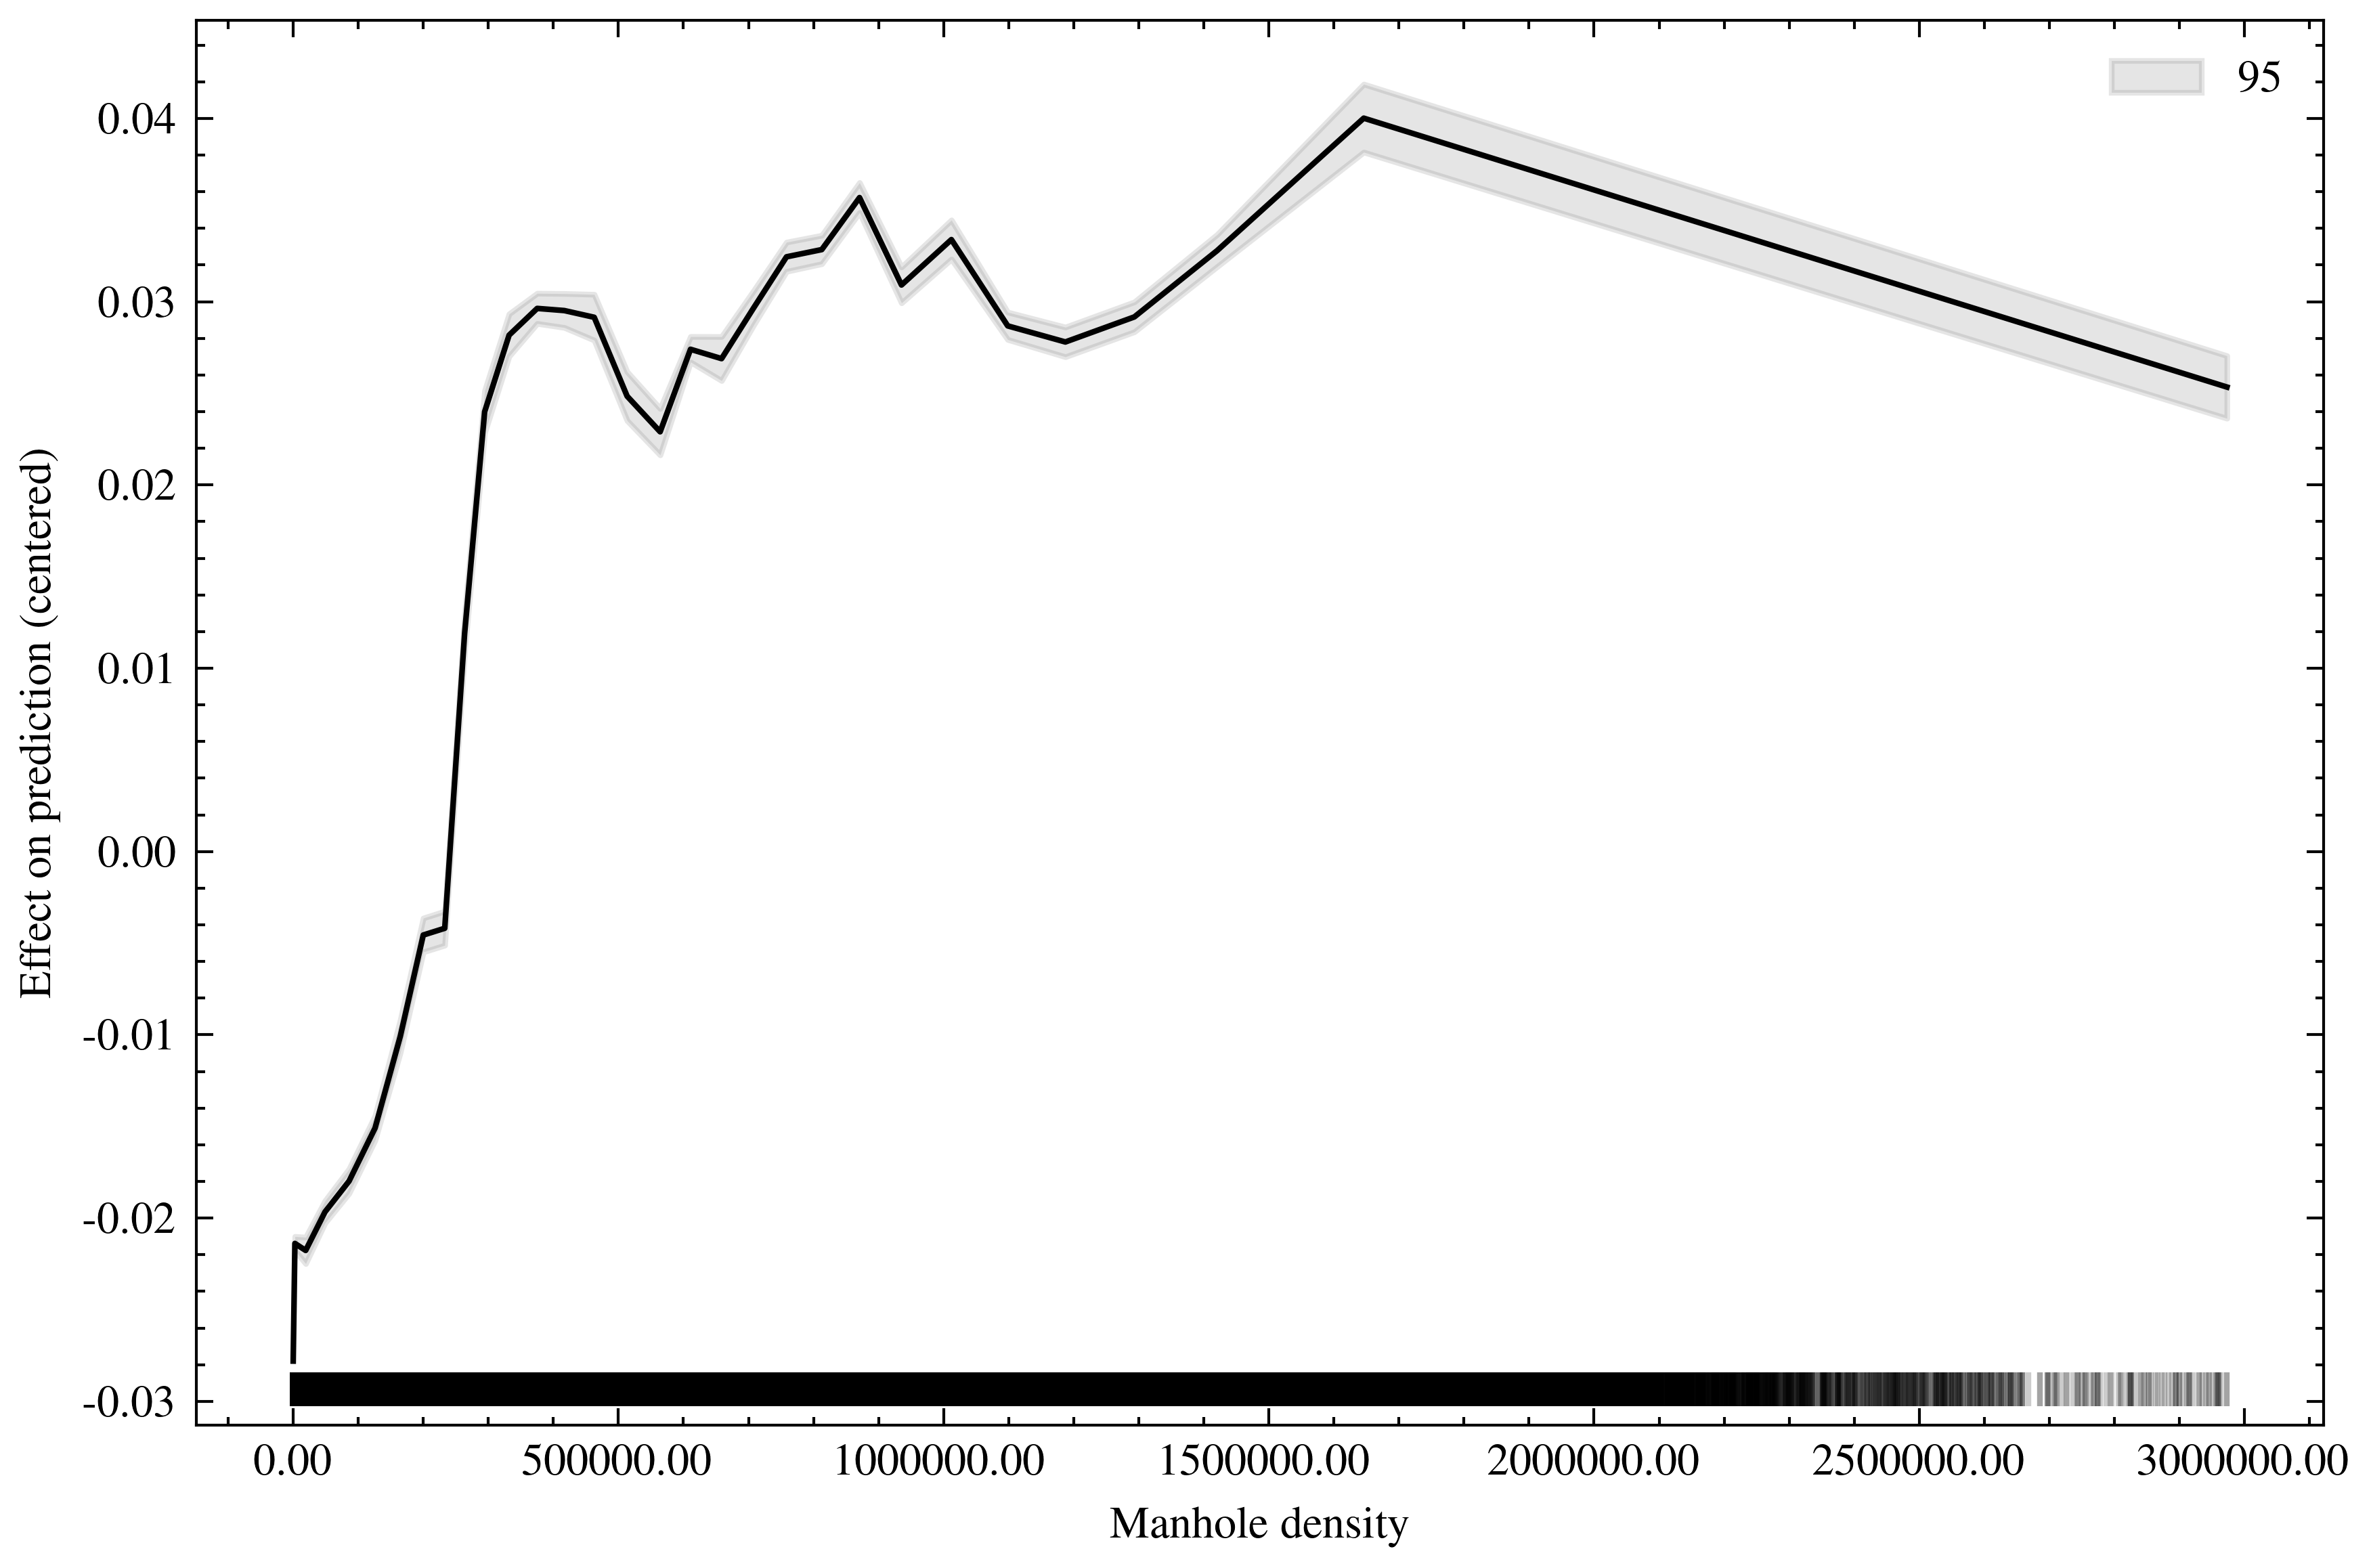

 50%|█████████████████████████████████████████▌                                         | 3/6 [08:16<07:56, 158.90s/it]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9784861694211177


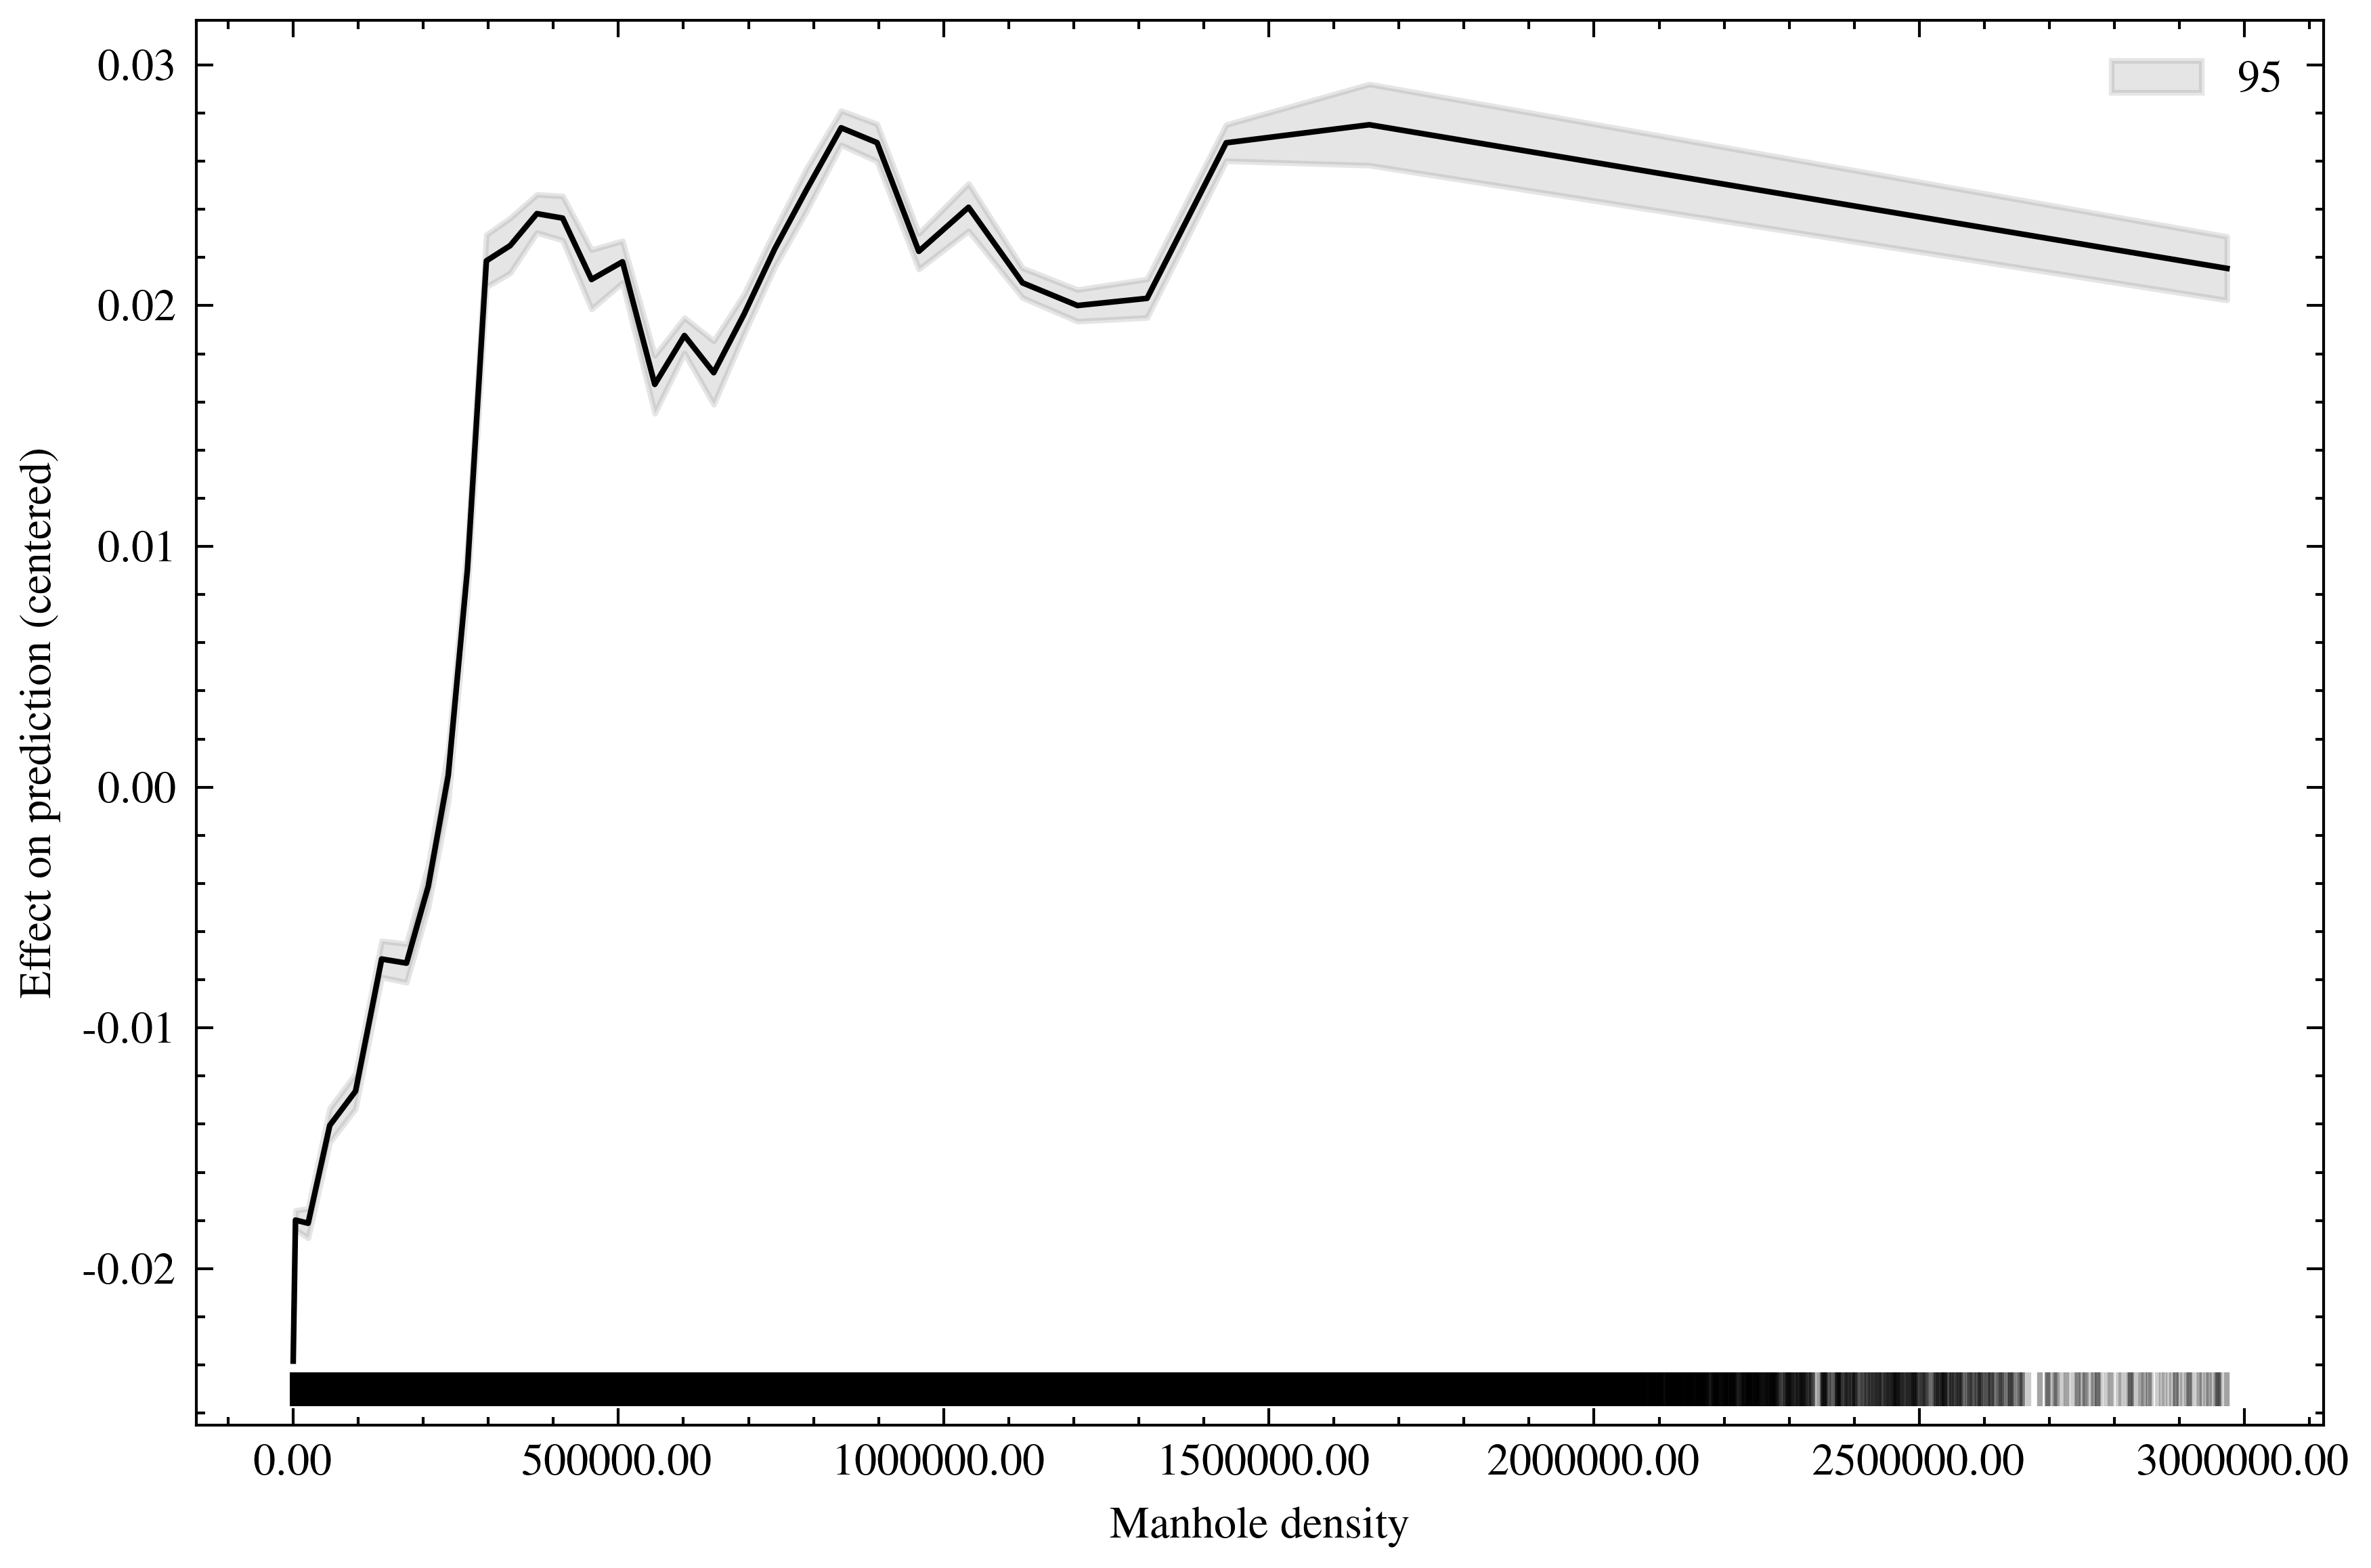

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [10:06<04:38, 139.41s/it]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9630230450595014


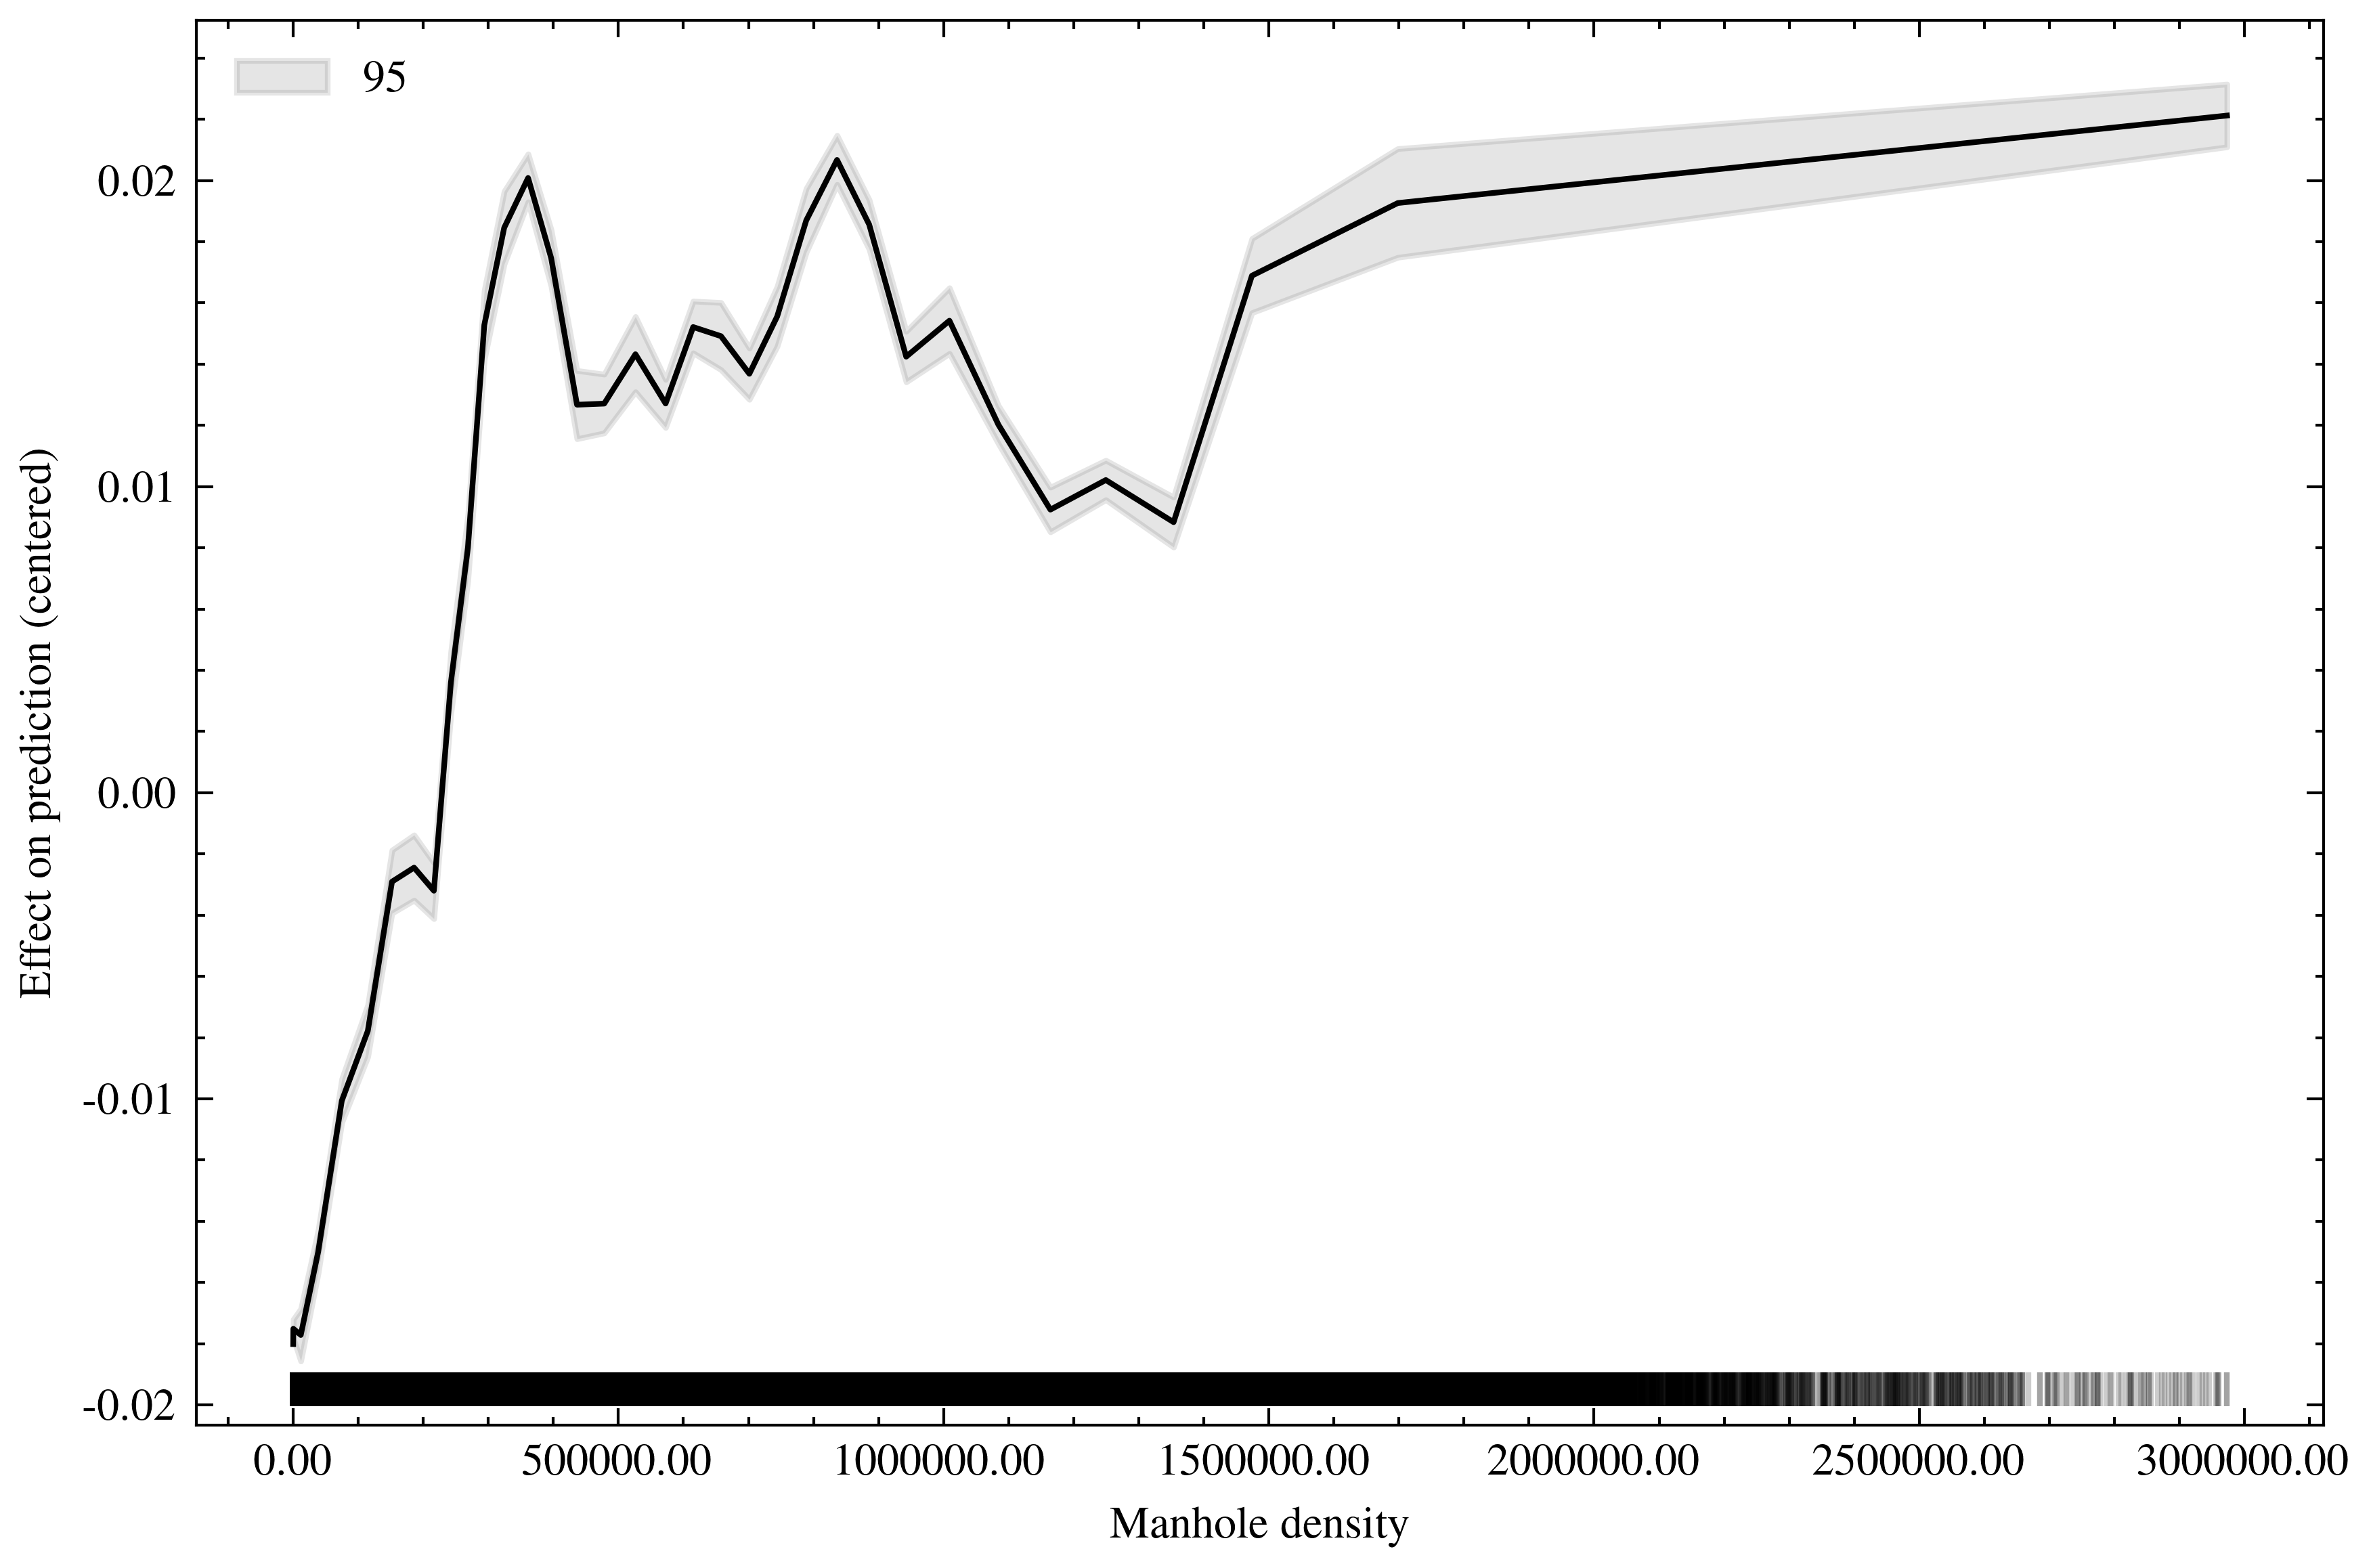

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [11:26<01:58, 118.08s/it]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9664513694951897


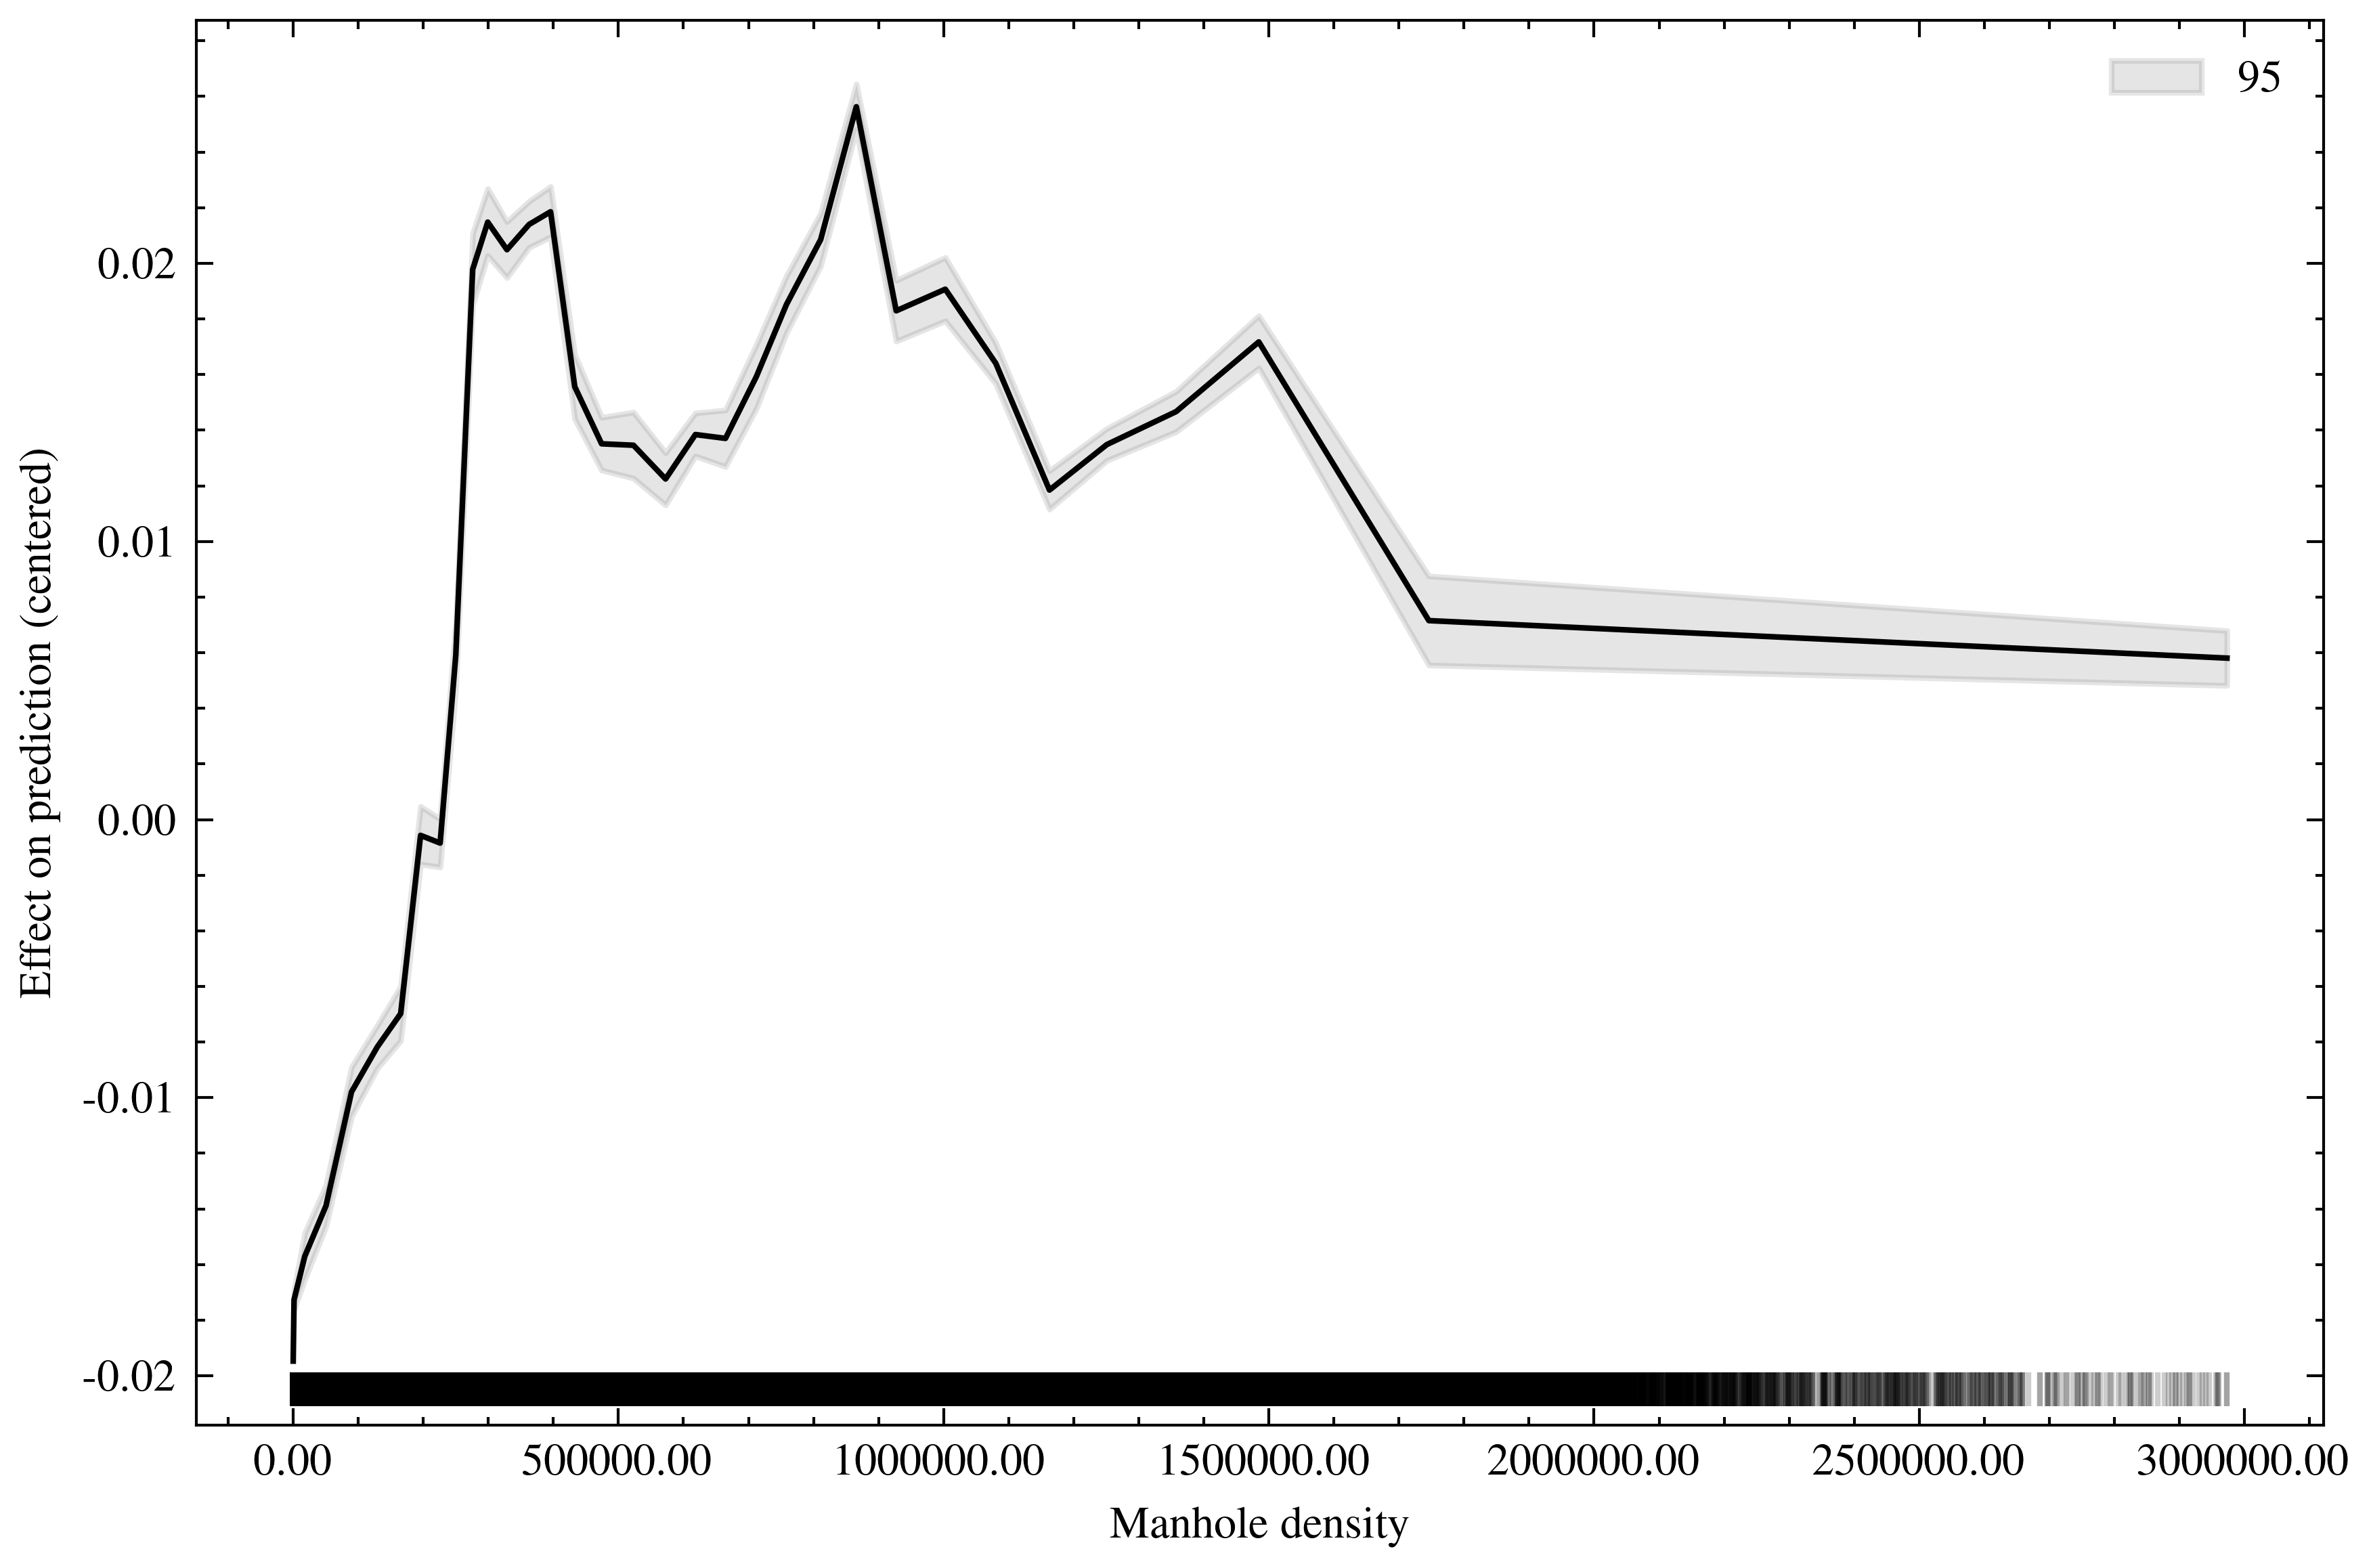

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [12:20<00:00, 123.39s/it]


In [59]:
for f in tqdm(test_files[::-1]):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    print(r2(df1.iloc[:,-1],pred))
    
    feat=["Manhole density"]
    with plt.style.context(['science','ieee']):
        fig,ax=plt.subplots(1,1,figsize=(6,4))
        ale_eff = ale(
            X=df1.iloc[:,:-1], model=model, feature=feat, 
            grid_size=50, include_CI=True, C=0.95,ax=ax,fig=fig,
        )
        # 设置 x 轴显示为三位小数
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

        # 设置 y 轴显示为两位小数
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        yticks=sorted(set(list(ax.get_yticks())))

        ax.set_title("")

        plt.tight_layout()

        save_path = rf"H:\EXP2\Figs\PDP1\ale_{feat}_{name}.pdf"  # 按特征命名更清晰
        plt.savefig(save_path, bbox_inches='tight', dpi=600)
        plt.show()
        plt.close()  # 关闭图像释放内存



# 不同类别的土地利用对应的人孔密度

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]PyALE._ALE_generic:INFO: Continuous feature detected.


0.9664196011004981


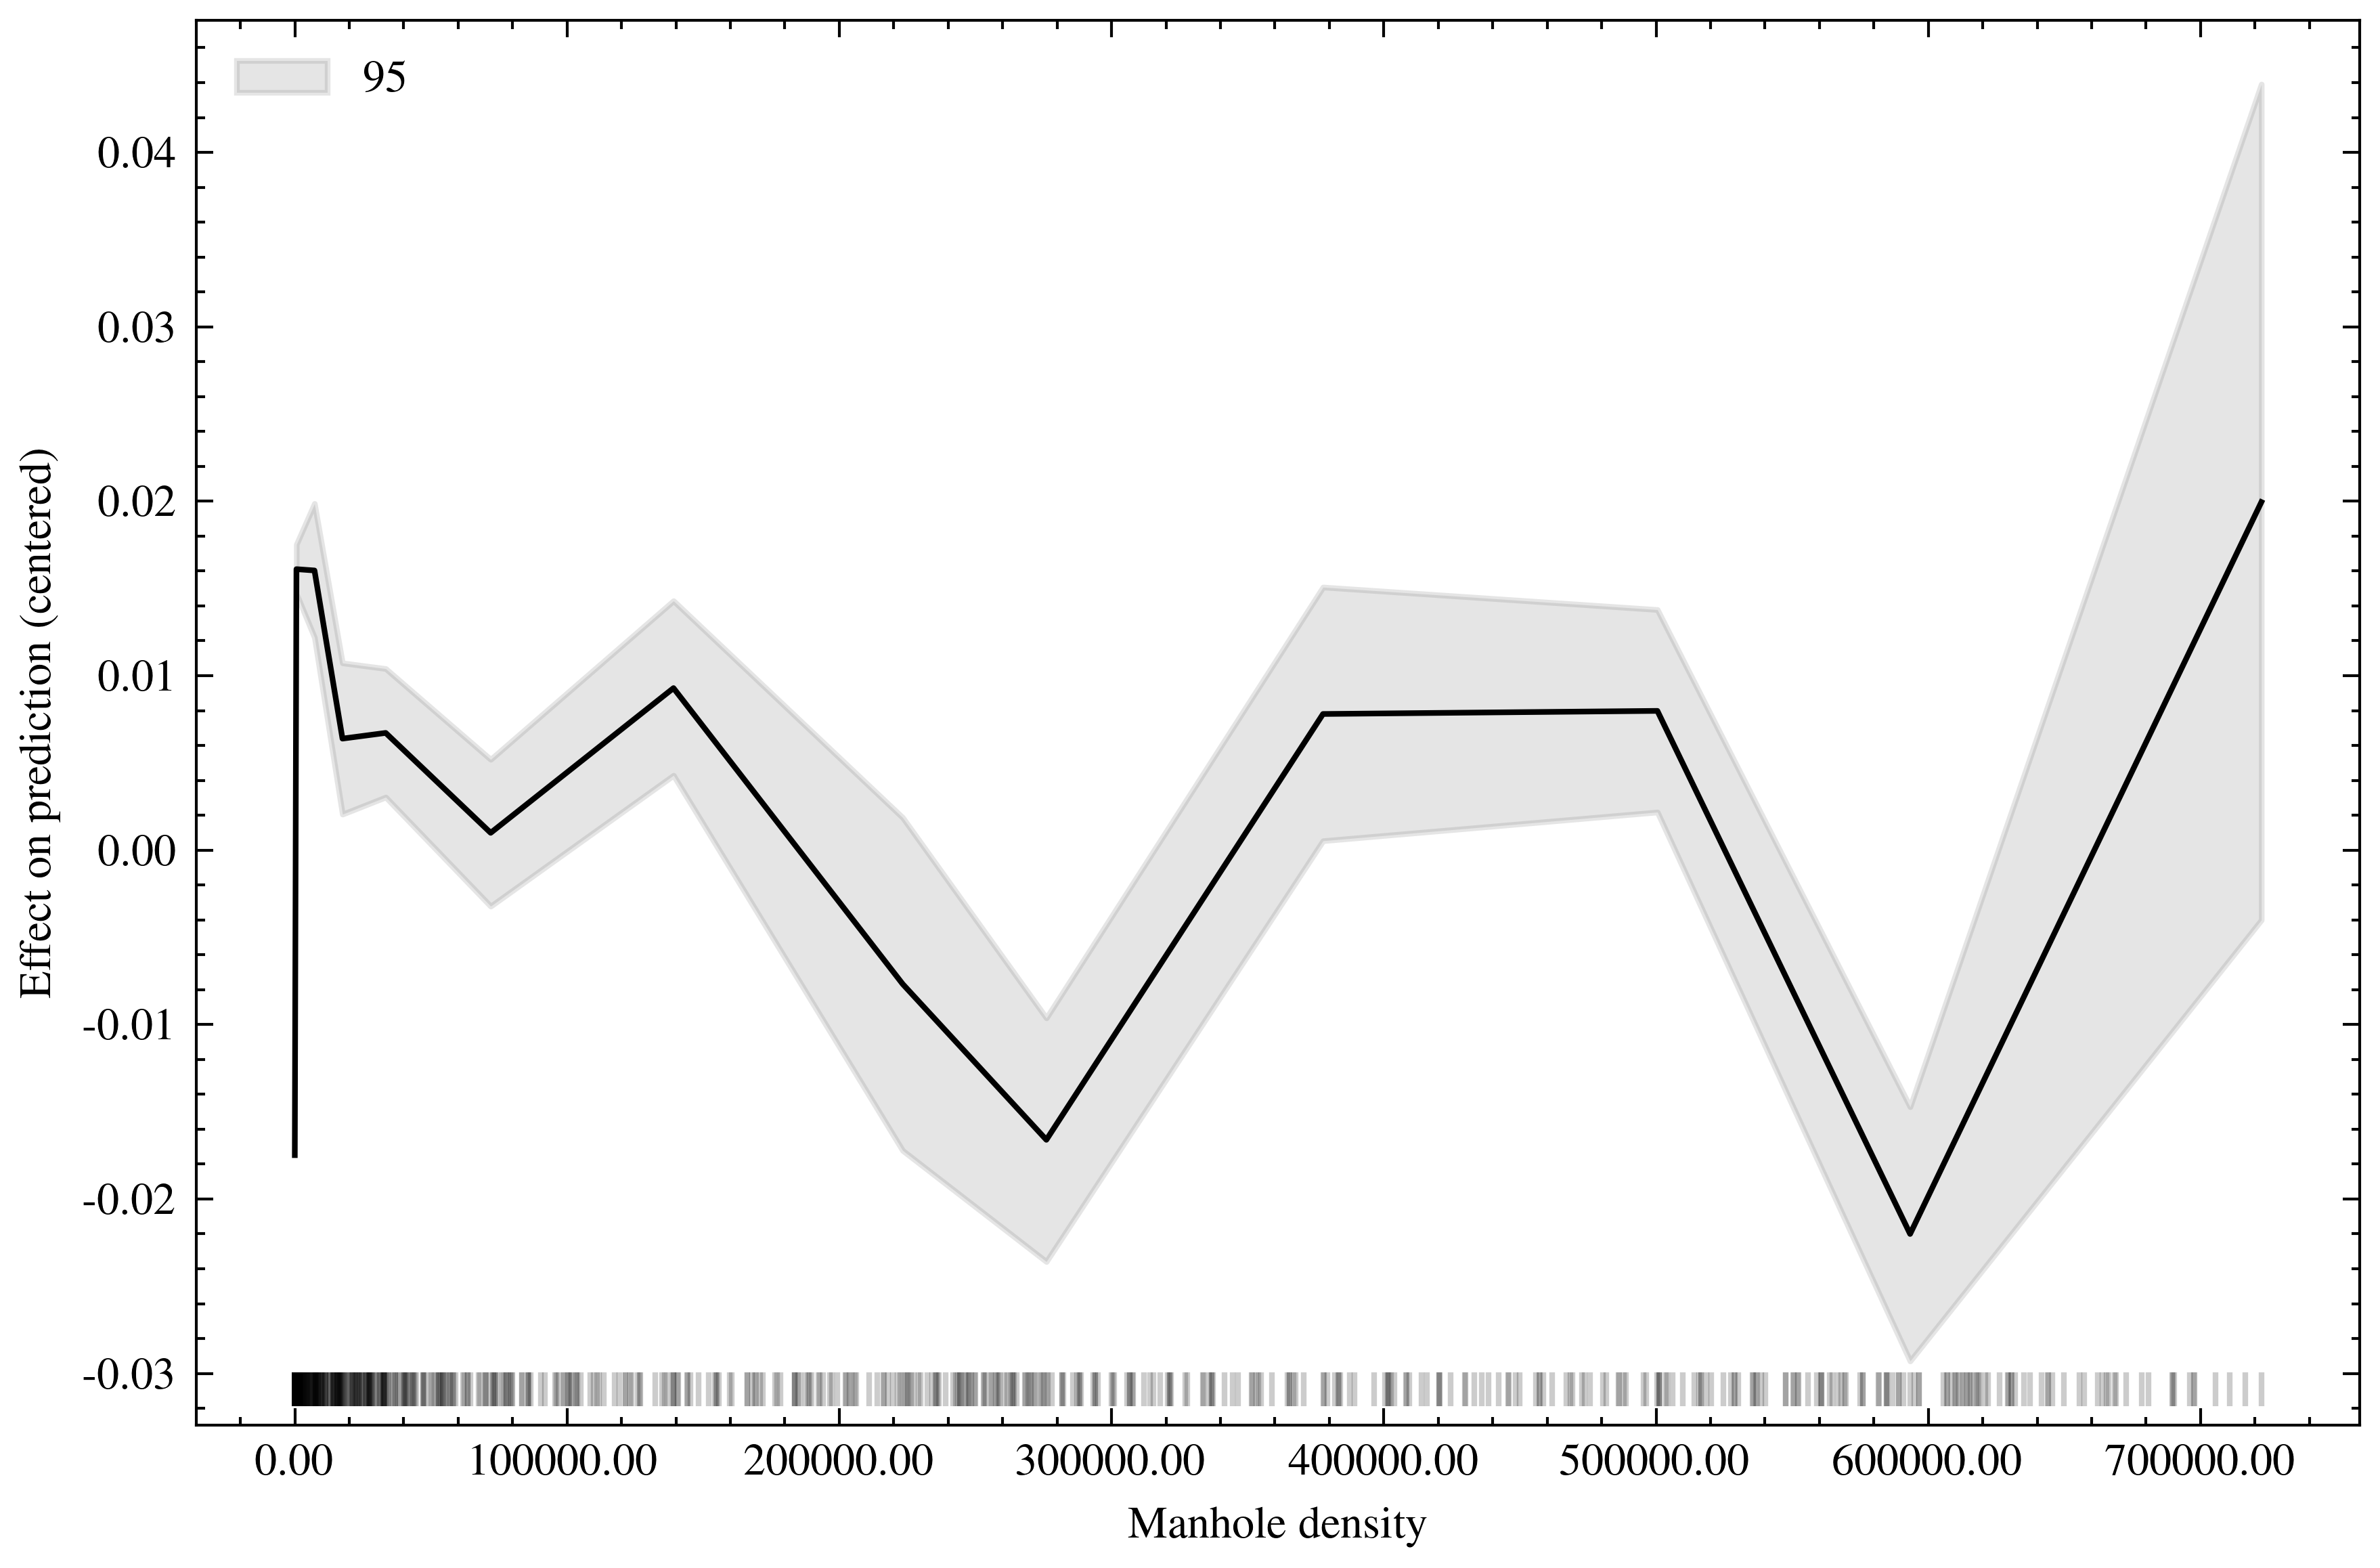

PyALE._ALE_generic:INFO: Continuous feature detected.


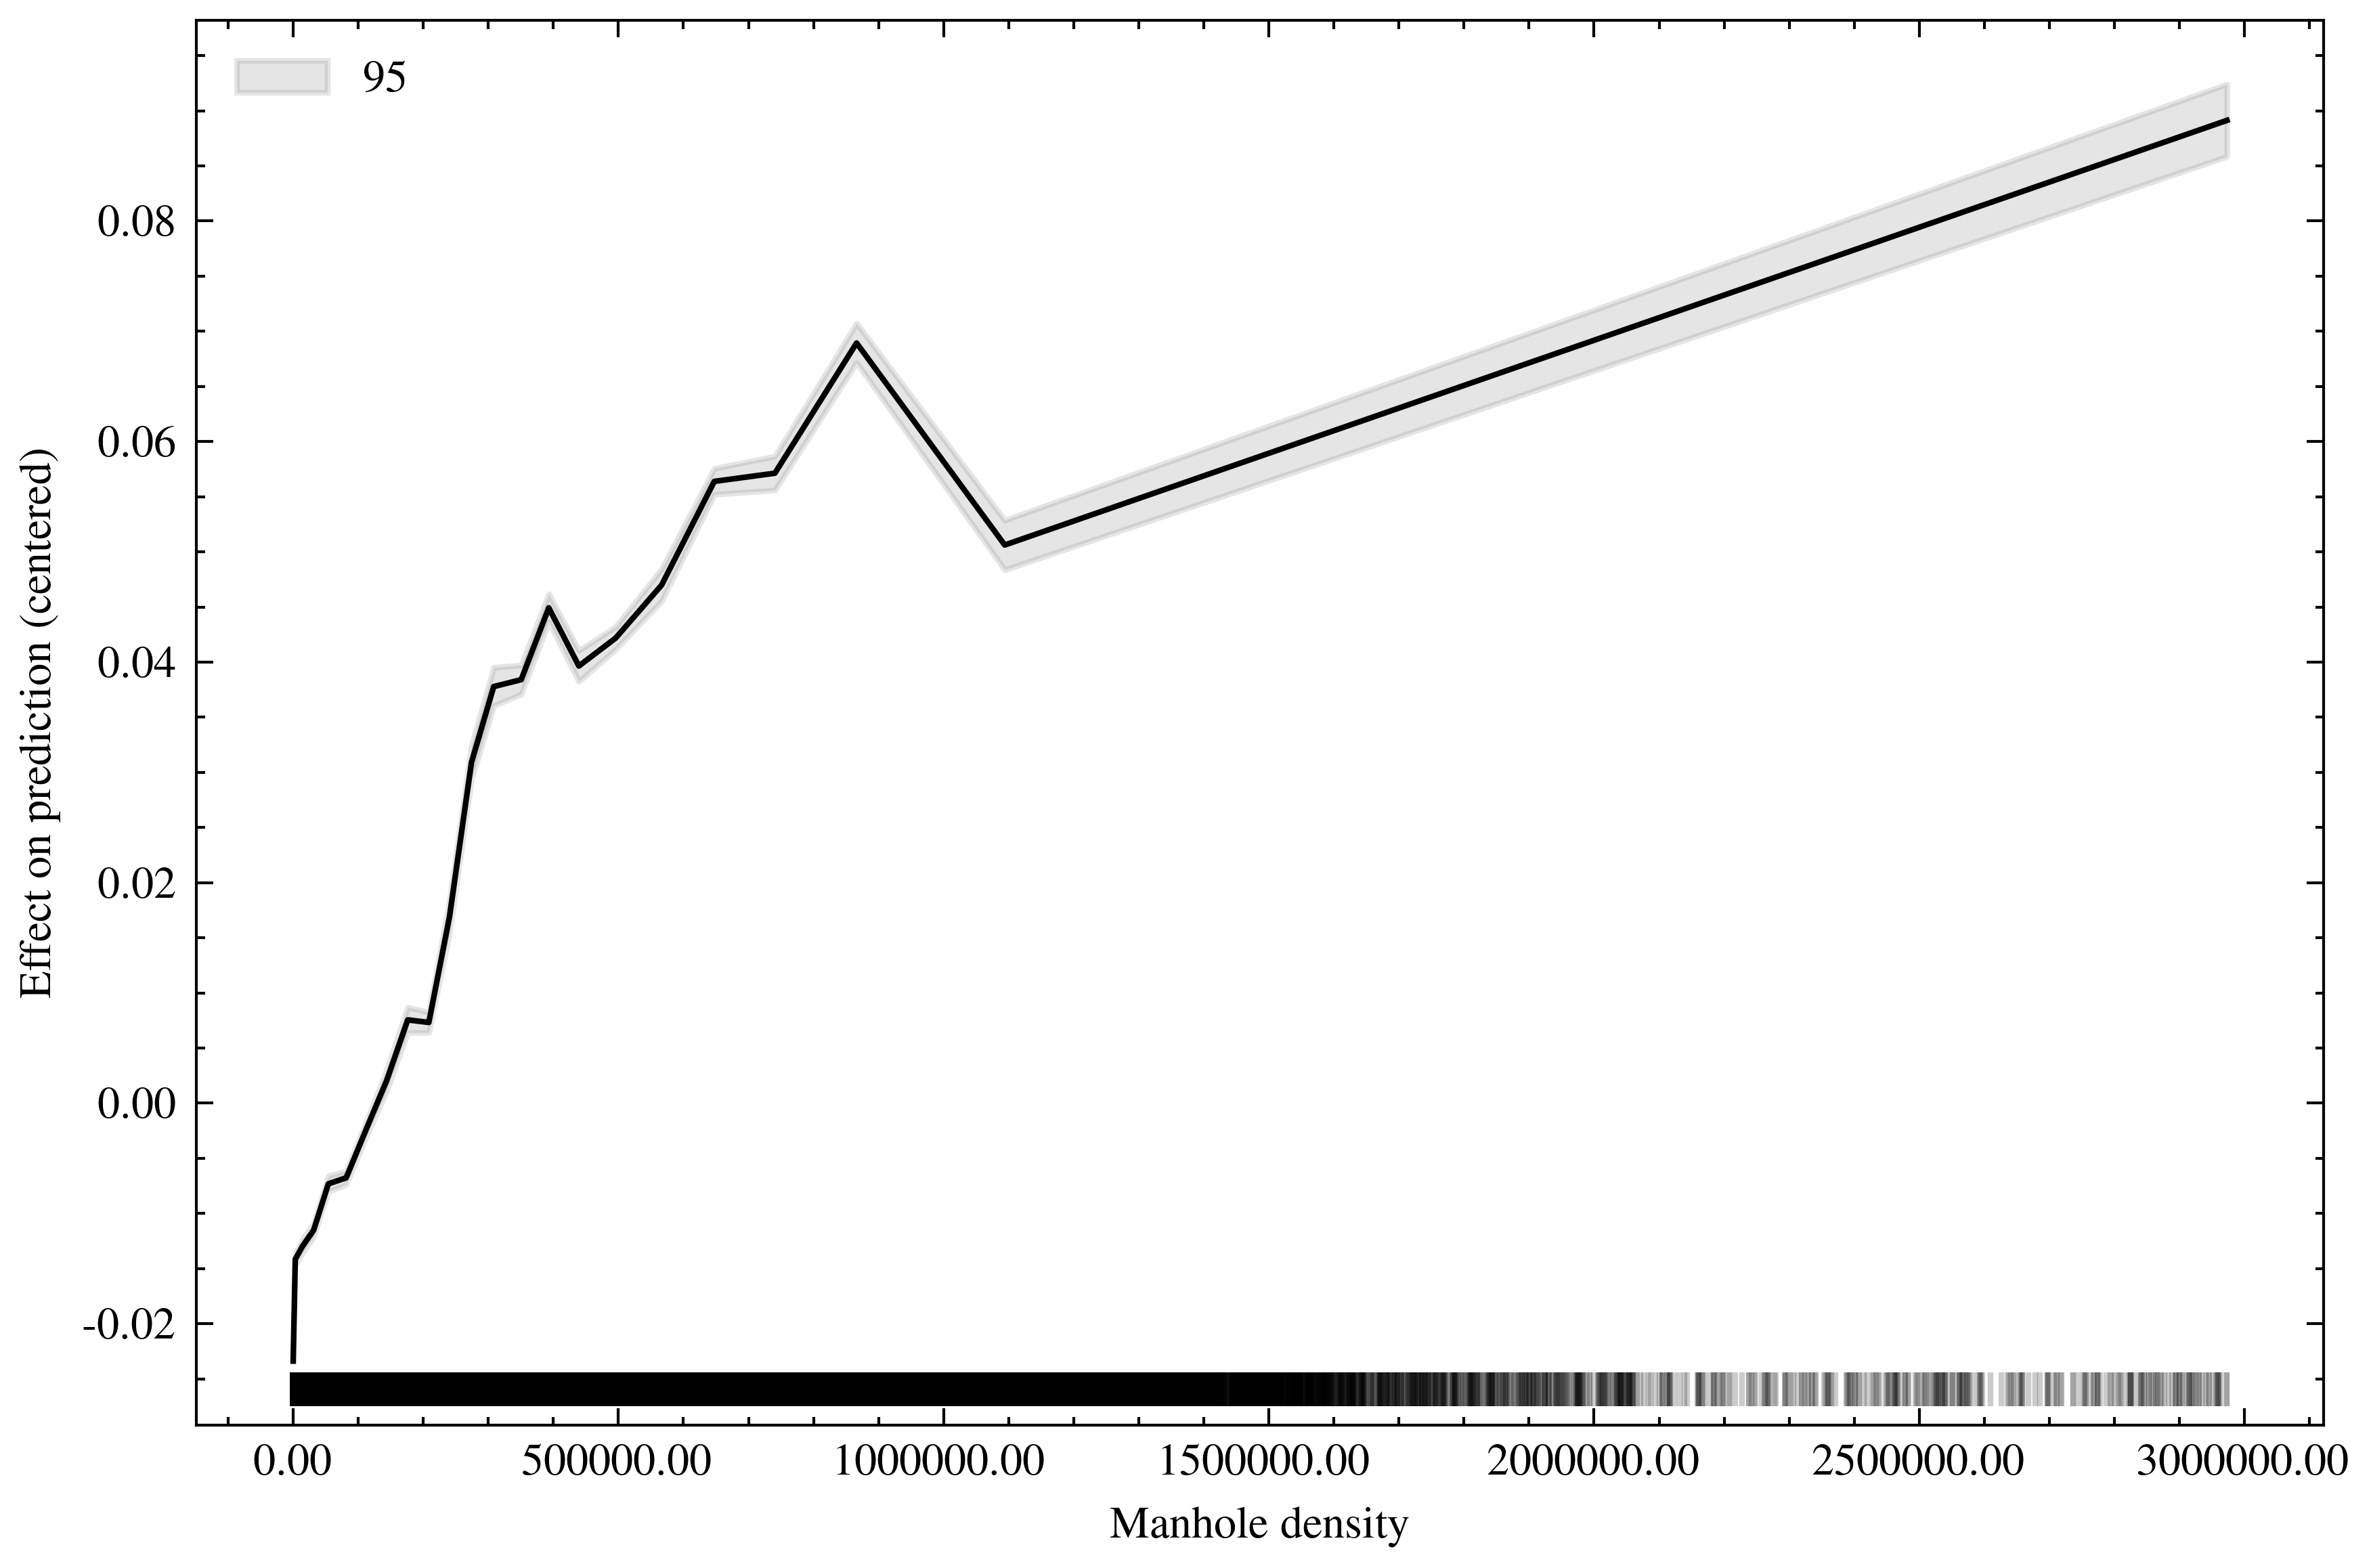

PyALE._ALE_generic:INFO: Continuous feature detected.


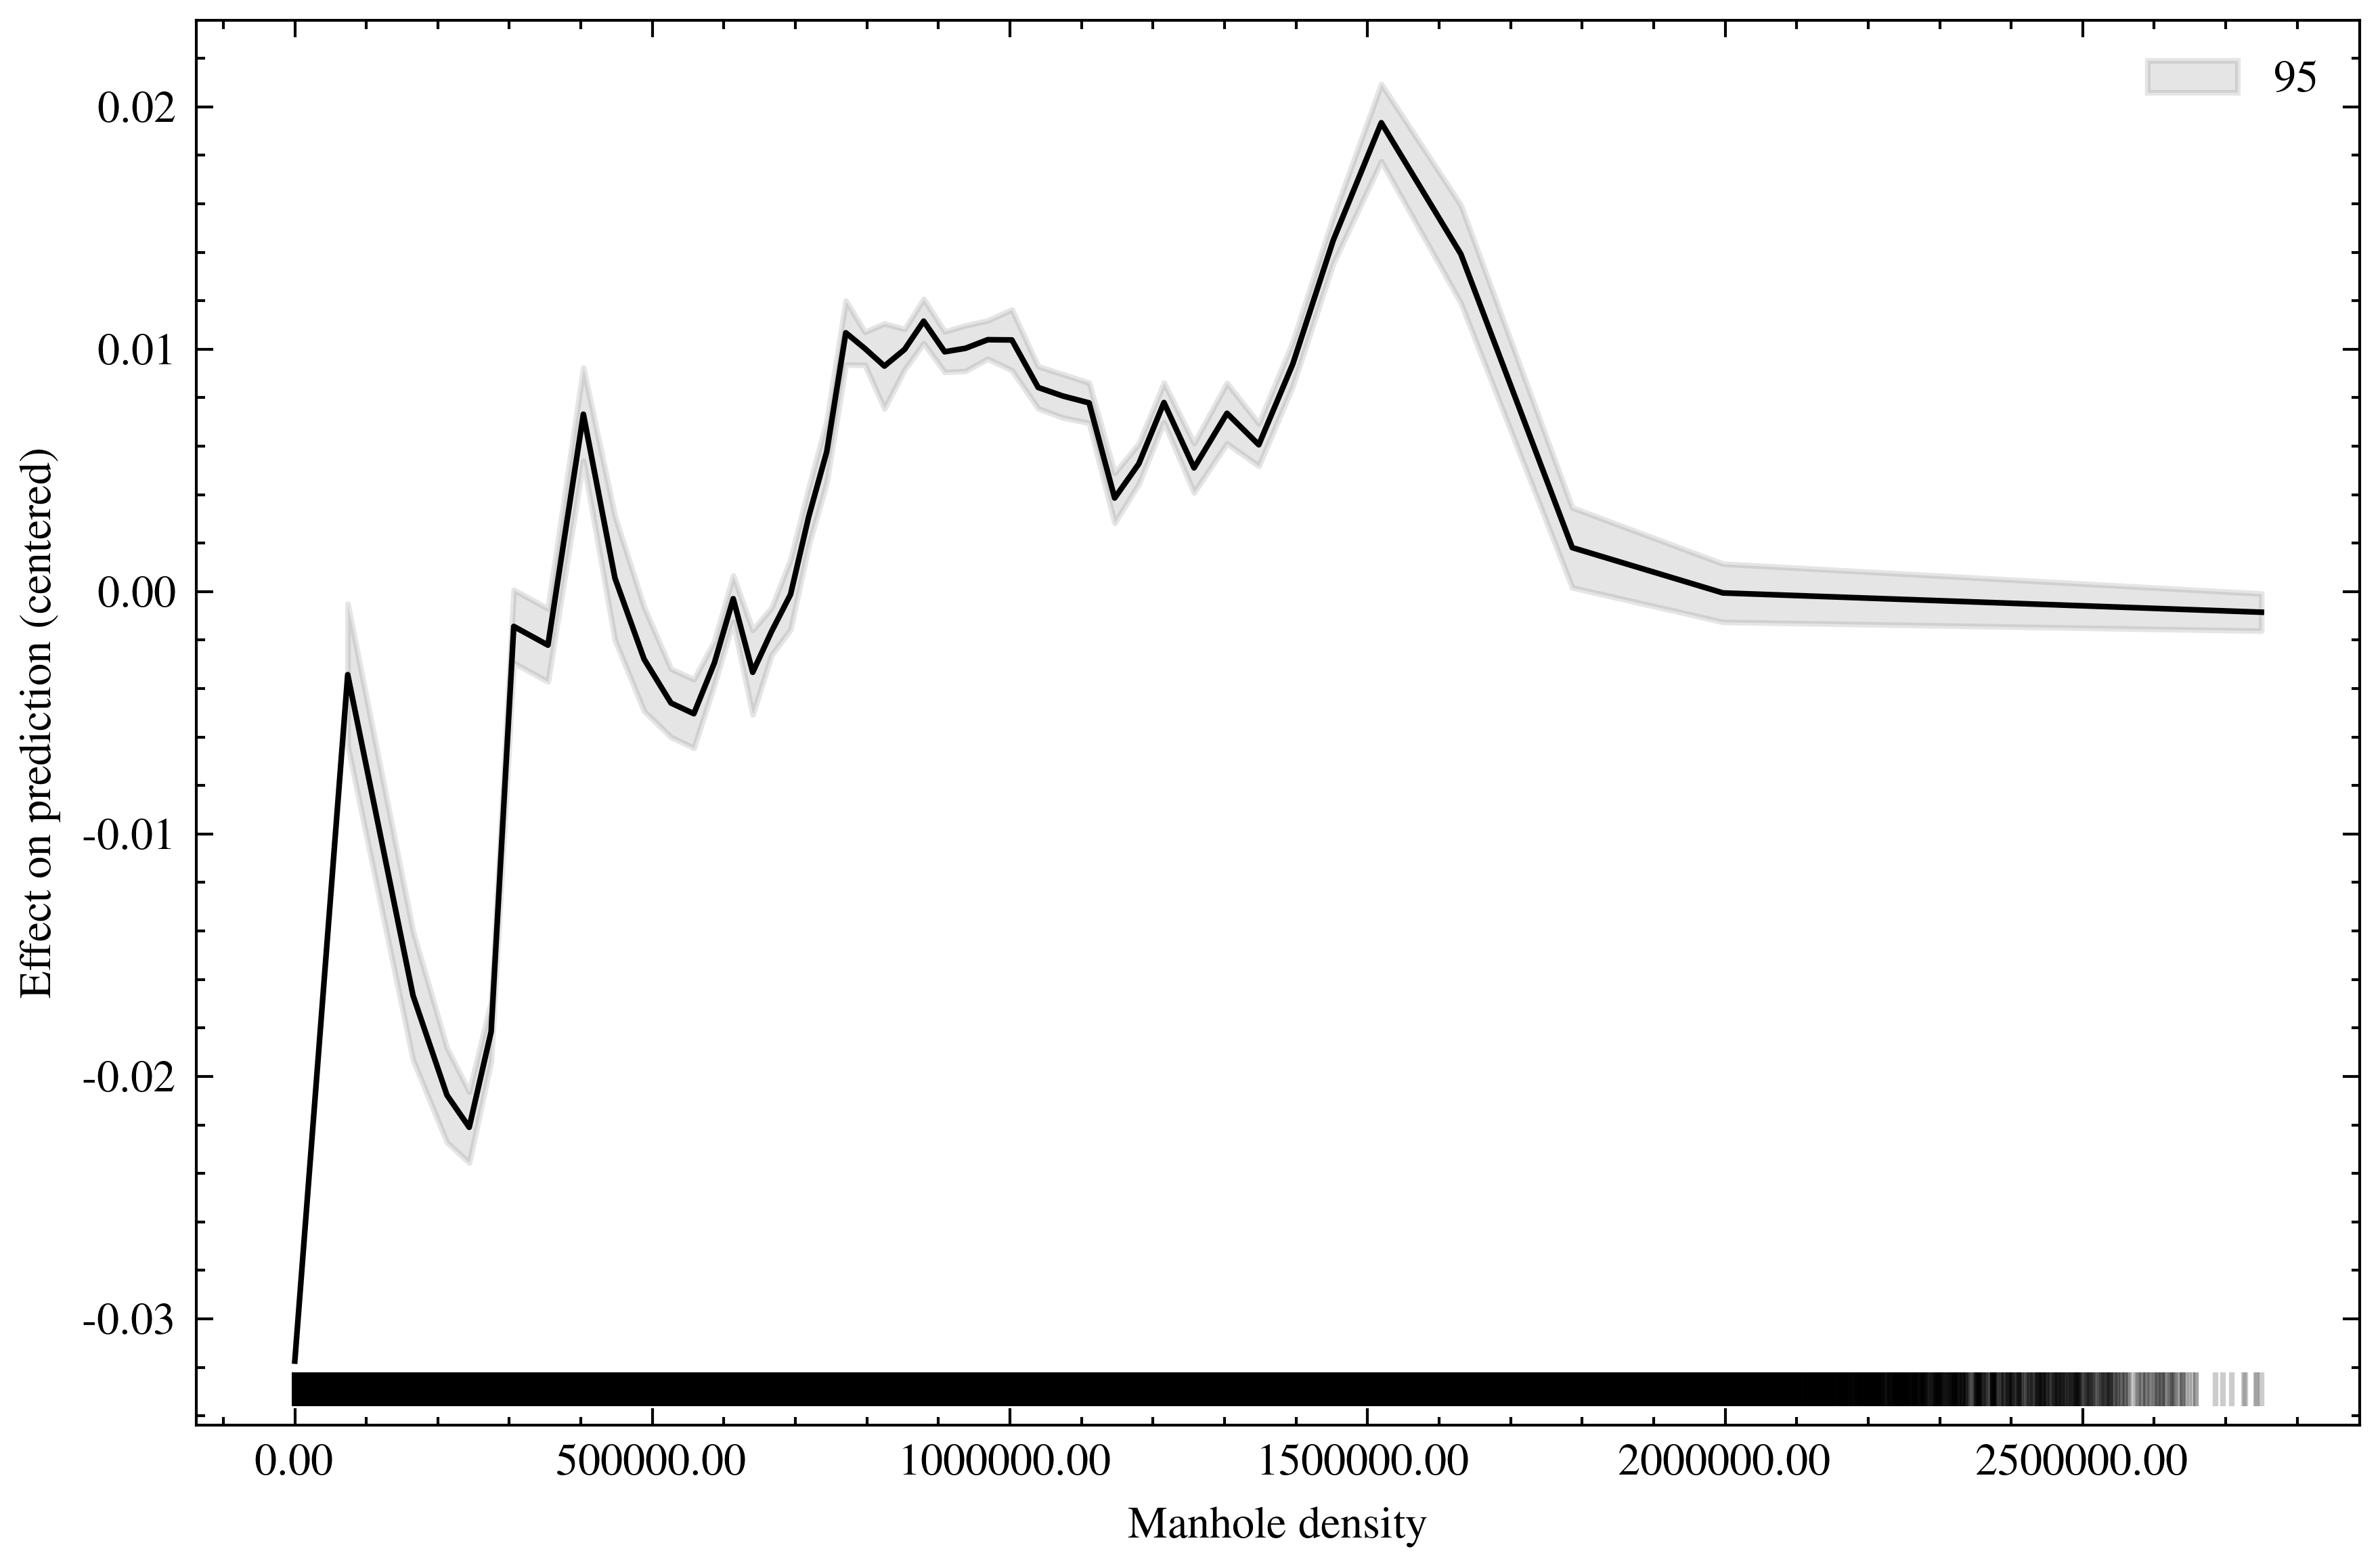

PyALE._ALE_generic:INFO: Continuous feature detected.


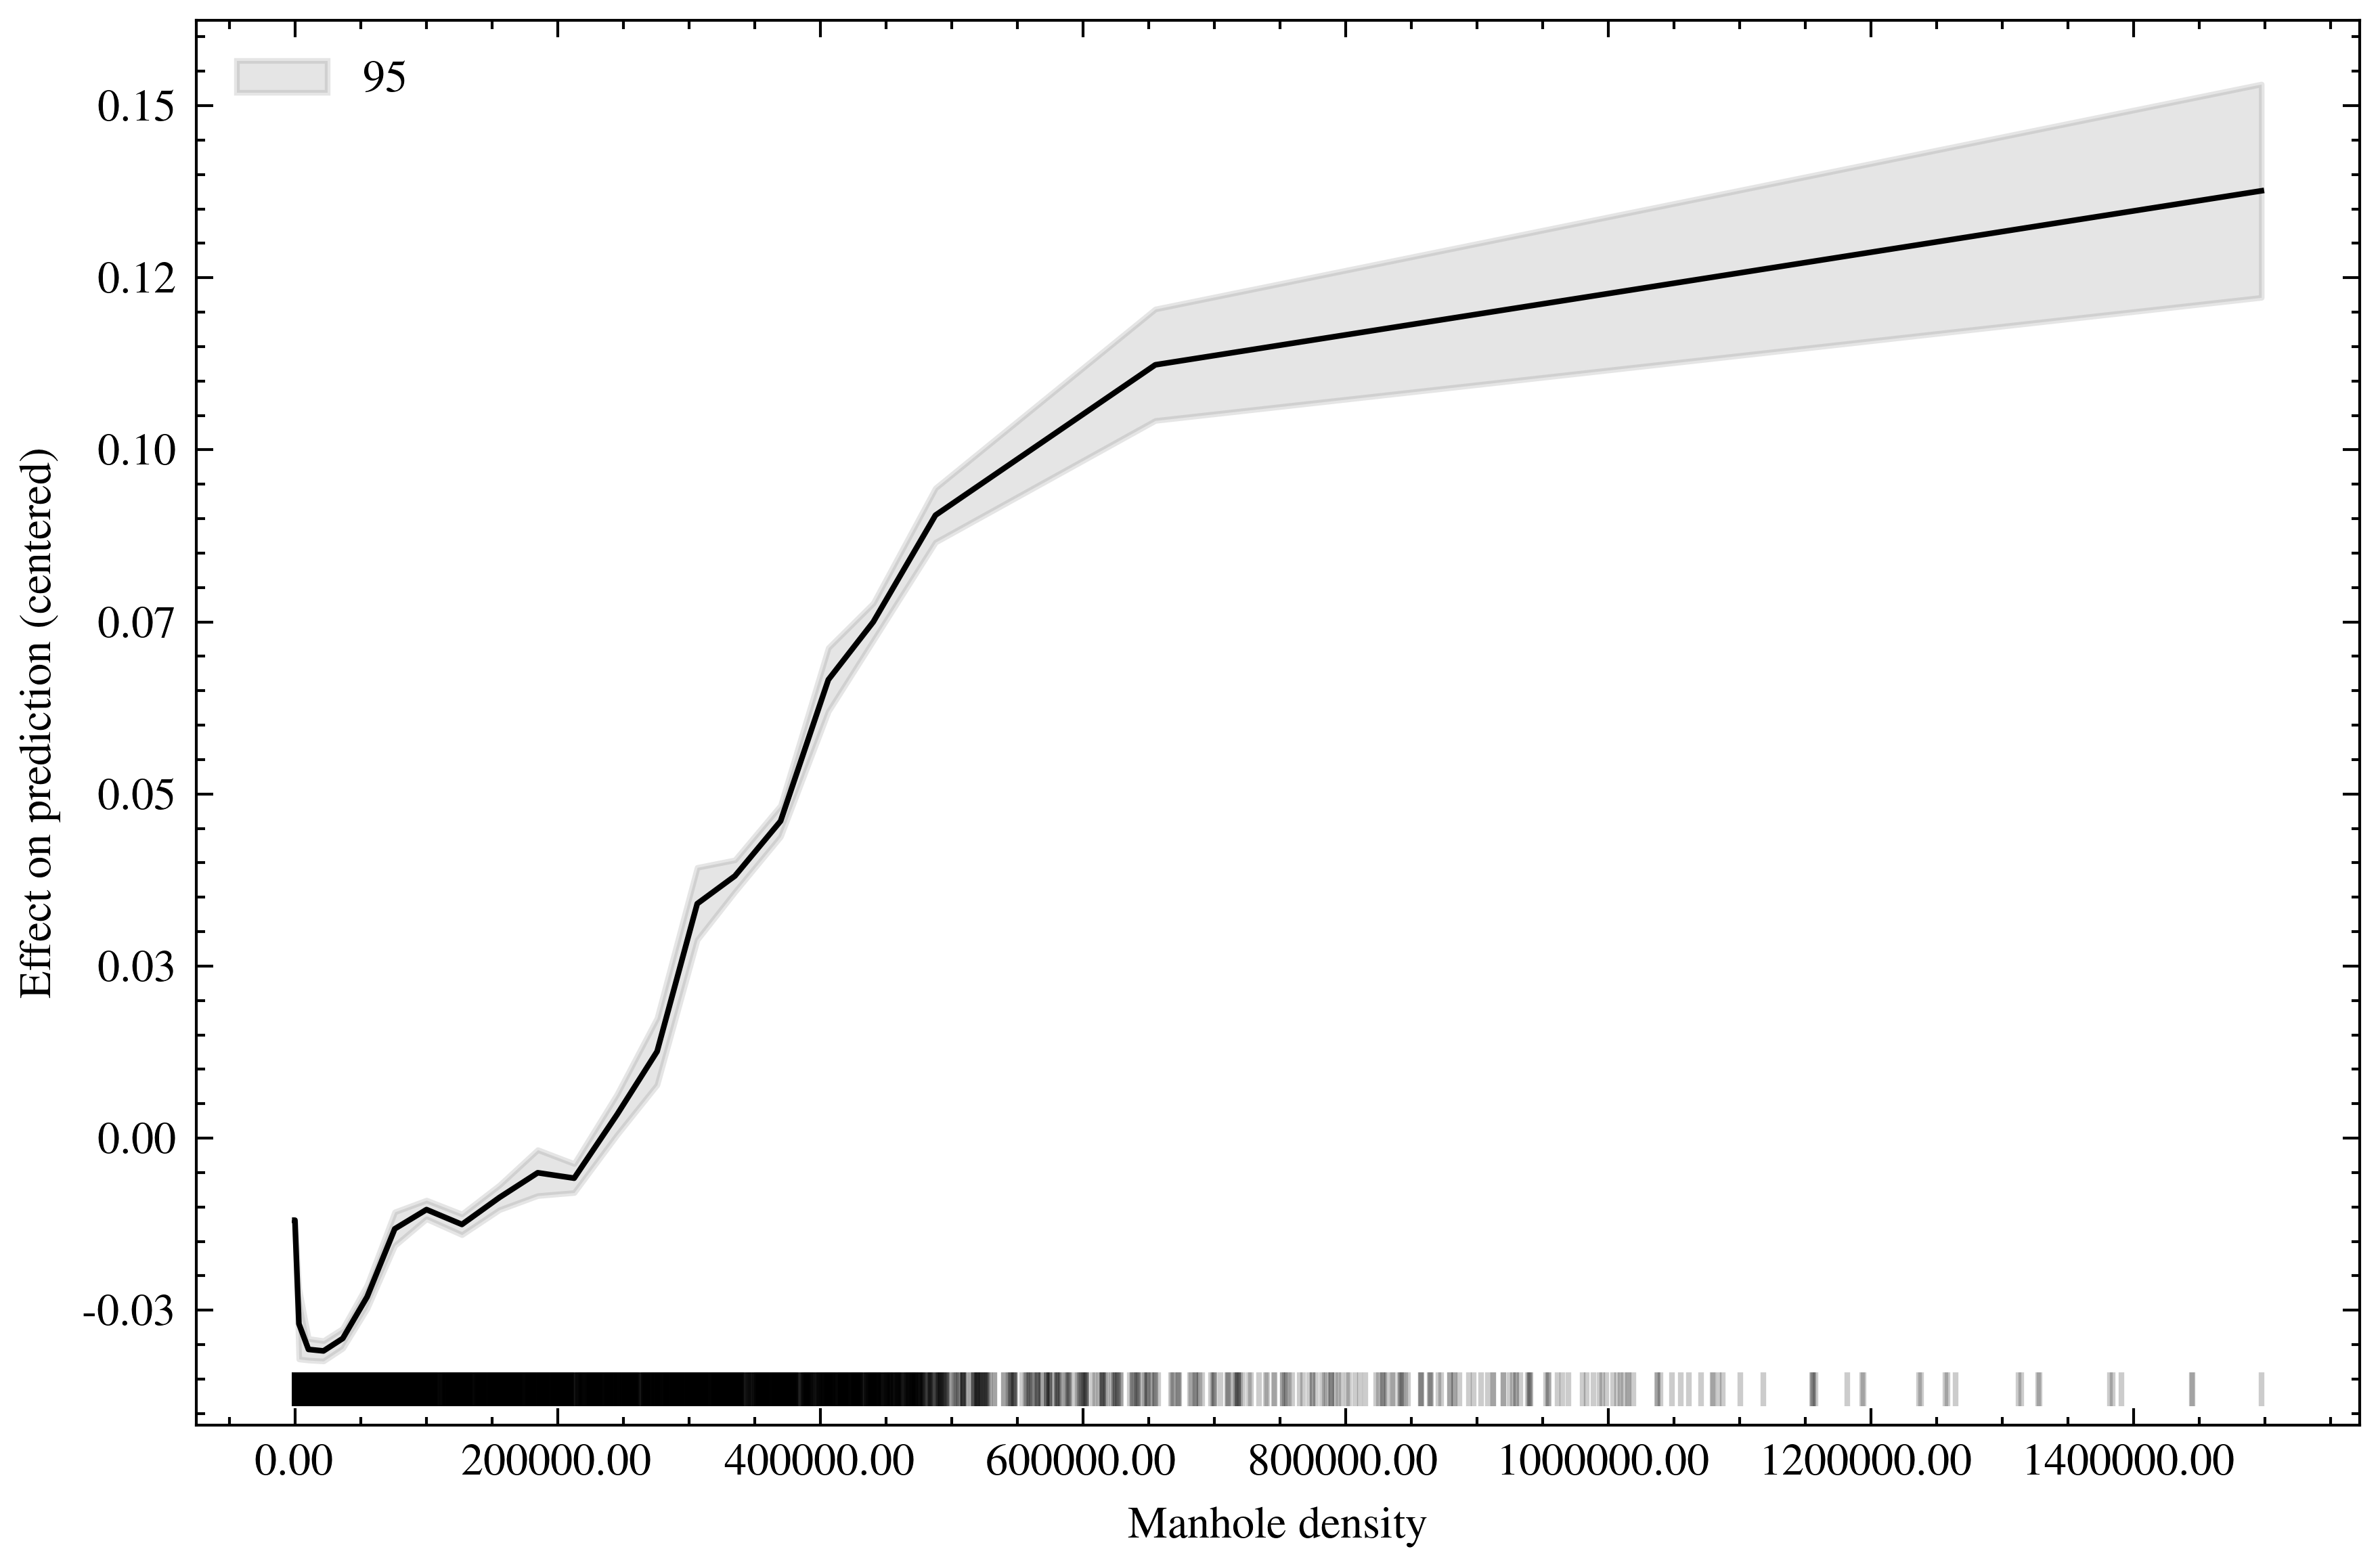

  0%|                                                                                            | 0/6 [01:52<?, ?it/s]


In [106]:
for f in tqdm(test_files[::-1]):
    name=f.split("\\")[-1][:-5]
    ds_temp=mikeio.read(f)['max H'].to_numpy().squeeze()
    ds_temp=np.flip(ds_temp,axis=0)  #Y
    ds_temp=np.expand_dims(ds_temp,axis=0).reshape(1,-1)
    
    ds_all=np.concatenate((dem_feature.reshape(7,-1),ds_temp),axis=0)
    
    nums=np.where((np.isnan(ds_temp)==False)&(ds_temp>=0.003)) #忽略掉NAN值以及极小的淹没深度

    ds_all=ds_all[:,nums[1]].transpose(1,0)
    df1=pd.DataFrame(ds_all)
    
    rain_file=r"H:\MIKE\Rainfall\Designs\{}.dfs0".format(f.split("\\")[-1].split("MAX")[0])
    rain=mikeio.read(rain_file).to_numpy()
    rain=np.repeat(np.expand_dims(rain,axis=0),ds_all.shape[0],axis=0).squeeze()

    df1=pd.concat([df1.iloc[:,:-1],pd.DataFrame(rain),df1.iloc[:,-1]],axis=1)
    df1.columns=cols
    
    pred=model.predict(df1.iloc[:,:-1])
    print(r2(df1.iloc[:,-1],pred))
    
    feat=["Manhole density"]
    for j in [1,3,7,8]:
        with plt.style.context(['science','ieee']):

            fig,ax=plt.subplots(1,1,figsize=(6,4))
            nums=np.where(df1['Land use']==j)[0]
            ale_eff = ale(
                X=df1.iloc[nums,:-1], model=model, feature=feat, 
                grid_size=50, include_CI=True, C=0.95,ax=ax,fig=fig,
            )
            # 设置 x 轴显示为三位小数
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

            # 设置 y 轴显示为两位小数
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
            ax.set_title("")

            plt.tight_layout()

            #save_path = rf"H:\EXP2\Figs\PDP1\ale_{feat}_{name}.pdf"  # 按特征命名更清晰
            #plt.savefig(save_path, bbox_inches='tight', dpi=600)
            plt.show()
            plt.close()  # 关闭图像释放内存
    break

